In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


AIm:
Clean survey dataset
- unify commata to decimals
- clean columns from typos
- define correct datatype to the columns
- select columns which could be later needed for model development
- combine targets based on compared damage variables and flood times


For reasons of reusability and comparability the workflow of the data preprocessing was kept similar to previous preprocessings of the same questionnaire. This was achieved by dealing with missing or erroneous values in a similar way likewise erroneous values with commas or points in the beginning were converted to decimal numbers beginning with zero. 

In [1]:
import sys, os

import numpy as np
import pandas as pd
import geopandas as gpd
import re

#from itertools import compress
from sklearn.preprocessing import MinMaxScaler
#from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer

import matplotlib.pyplot as plt
import plotly.express as ex
import seaborn as sns

sys.path.insert(0, "../")
import utils.figures as f
import utils.preprocessing as pp
import utils.feature_selection as fs

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


c:\Anaconda\envs\py396_c3\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Anna\AppData\Local\Temp\ipykernel_6240\1841744584.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you ar

In [3]:
# load raw survey data

#raw_data = pd.read_excel("../../input_survey_data/all-attributes_shophouses.xlsx")#, thousands=',')
raw_data = pd.read_excel("../input_survey_data/raw_data_vietnamese_geolocations_no_dublicates.xlsx") # Niveditas dataset with vietnamese addresses and improved geolocations and building information from Tuebingen
raw_data.tail(3)                                 

,id_x,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Se,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Se,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Se,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Se,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Se,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Se,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2.

In [6]:
raw_data.geometry

0                                                    NaN
1      MULTIPOINT (106.6990667908692 10.796493095049405)
2      MULTIPOINT (106.70080527790017 10.797540370705...
3      MULTIPOINT (106.70113583213717 10.797534729984...
4      MULTIPOINT (106.70003992972188 10.797443653167...
                             ...                        
247                                                  NaN
248                                                  NaN
249                                                  NaN
250    MULTIPOINT (106.70275096630547 10.685547905672...
251                                                  NaN
Name: geometry, Length: 252, dtype: object

### Overview

In [5]:
## Fix erroneous coordinate pair by removing second decimal point
raw_data.GPS = raw_data.geometry.astype(str).replace({"10.722.546,106.62888":"10.722546,106.62888",
                                     "10797626106701100":"10.797626,106.701100",  # idx 24
                                     "10722187106.63":"10.722187,106.63"})  # idx 152

In [6]:
# get coords in readable format for gpd
raw_data_geometry = raw_data

raw_data["geometry"] = raw_data["geometry"].str.findall(r'(\d+\.\d+)').astype(str)
geom_col = raw_data["geometry"].str.split(' ', n=1, expand=True)
geom_col

raw_data = gpd.GeoDataFrame(raw_data,  
           geometry=gpd.points_from_xy(
               geom_col[0].str.extract(r'(\d+\.\d+)')[0],
               geom_col[1].str.extract(r'(\d+\.\d+)')[0],
    ))
print(raw_data.shape)

## save shp locations to disk, 
# extract elevation based on shop locations in datapoints_vars_bui.shp via QGIS due to loading size and process with gdal
#print(raw_data_geometry.crs)
raw_data = raw_data.set_crs(4326) 
# raw_data_geometry.geometry.to_file('../input_survey_data/DEM_LiDAR/datapoints_vars_bui_tuebingen.shp')  

(252, 555)


In [7]:
## visual check of SMEs locations

glimpse = raw_data[~ raw_data.is_empty]   # drop emtpy geoms
glimpse.geometry.explore()  


Map shows spatial distribution of business locations from the HCMC survey dataset.
It can be seen that a few shops are probably outside the admininstrative area of HCMC. 

#### Businesses outside HCMC


Update: With tuebingen dataset the geolocations are quite exact

Archive: It is decided to keep these cases , one reason is that their variable values seems reasonable (i.e. both targets, hydrological and building variables), the other reason is that removing them from the dataset would shrink the moderate large dataset; as more cases, potentially the better the algorithms can be trained. 

In [8]:
## TODO add remove of GPS from outliers /see develop branch



### rename columns

All variables based on the most recent event are ending with "_r", all variables for the most serious event since 2010 are ending with "_s".
"hh" is used as abbreviation for households, single "b" for building 



*Targets*

In [9]:
df = raw_data

# target var for direct cost on content loss [VND]
df.insert(0, "Target_contentloss_mVND_r", df.pop("P1Q5.6.1")) 
df.insert(1, "Target_contentloss_mVND_s", df.pop("P1Q5.6.2"))

# explanatory var: monthly reduction of business [%] 
df.insert(2, "Target_businessreduction_r", df.pop("P1Q5.9.1"))  
df.insert(3, "Target_businessreduction_s", df.pop("P1Q5.9.2"))



*possible relevant columns*
Including candidate predictors and features to derive certain predictors

In [10]:
## for candidate predictors: With which reason a certain candidate predictor is selected is written after # (more detailed description in master thesis)

col_names = {        'P1Q1':'flood_experience',  
                     'P1Q2.2.1':'flood_time_r', 
                     'P1Q2.2.2':'flood_time_s',
                     'P1Q2.3.1':'inundation_duration_h_r',
                     'P1Q2.3.2':'inundation_duration_h_s',
                     'P1Q2.4.1':'water_depth_cm_r',  
                     'P1Q2.4.2':'water_depth_cm_s',    
                     'P1Q2.5.1':'contaminations_r',    
                     'P1Q2.5.2':'contaminations_s',    
                     'P1Q2.6.1':'flowvelocity_r',     
                     'P1Q2.6.2':'flowvelocity_s',  
                     'P1Q2.7.1':'flood_type_r',      
                     'P1Q2.7.2':'flood_type_s',      
                     'P1Q2.9.1':'warning_time_h_r',   
                     'P1Q2.9.2':'warning_time_h_s',   
                     'P1Q2.10.1':'emergency_measures_r',   
                     'P1Q2.10.2':'emergency_measures_s',   
                     #'P1Q2.11.1.1':'overall_problem_house_r', # binary problem / no problem
                     #'P1Q2.11.2.1':'overall_problem_house_s',  
                     'P1Q2.11.1':'overall_problem_house_r', # multi class
                     'P1Q2.11.2':'overall_problem_house_s',  

                     'P1Q3.2.1':'damage_level_floor_r',
                     'P1Q3.2.2':'damage_level_floor_s',
                     'P1Q3.3.1':'damage_level_walls_r',
                     'P1Q3.3.2':'damage_level_walls_s',
                     'P1Q3.4.1':'damage_level_foundation_r',
                     'P1Q3.4.2':'damage_level_foundation_s',
                     'P1Q3.5.1':'damage_level_doors_r',
                     'P1Q3.5.2':'damage_level_doors_s',
                     'P1Q3.6.1':'damage_level_roof_r',
                     'P1Q3.6.2':'damage_level_roof_s',
                     'P1Q3.7.1':'damage_level_basement_r',
                     'P1Q3.7.2':'damage_level_basement_s',
                     'P1Q3.88.1':'damage_level_other_r',
                     'P1Q3.88.2':'damage_level_other_s',
                     
                     'P1Q3.88.1.specify':'damage_level_specify_r',
                     'P1Q3.88.2.specify':'damage_level_specify_s',
                     'P1Q3.8.1':'repair_costs_building_VND_r',
                     'P1Q3.8.2':'repair_costs_building_VND_s',
                     'P1Q3.10.1':'reason_why_not_repaired_business_r', 
                     'P1Q3.10.2':'reason_why_not_repaired_business_s',
                     'P1Q3.11.1':'repair_costs_building_complete_mVND_r',
                     'P1Q3.11.2':'repair_costs_building_complete_mVND_s',
                     'P1Q5.2.1':'shp_damage_level_furniture_r',
                     'P1Q5.3.1':'shp_damage_level_electronics_r',
                     'P1Q5.4.1':'shp_damage_level_equipment_r',
                     'P1Q5.5.1':'shp_damage_level_products_r',
                     'P1Q5.88.1':'shp_damage_level_others_r',
                     'P1Q5.2.2':'shp_damage_level_furniture_s',
                     'P1Q5.3.2':'shp_damage_level_electronics_s',
                     'P1Q5.4.2':'shp_damage_level_equipment_s',
                     'P1Q5.5.2':'shp_damage_level_products_s',
                     'P1Q5.88.2':'shp_damage_level_others_s',
                     'P1Q5.7.1':'shp_closed_d_r',
                     'P1Q5.7.2':'shp_closed_d_s',
                     'P1Q5.8.1':'shp_duration_back2normal_r',
                     'P1Q5.8.2':'shp_duration_back2normal_s',
  
                     'P2Q1.1.implement':'protect_valuables_impl',
                     'P2Q1.1.spend':'protect_valuables_VND_spnd',
                     'P2Q1.2.implement':'water_barriers_impl',
                     'P2Q1.2.spend':'water_barriers_VND_spnd',
                     'P2Q1.3.implement':'pumping_equipment_impl',
                     'P2Q1.3.spend':'pumping_equipment_VND_spnd',
                     'P2Q1.4.implement':'elevation_building_impl',
                     'P2Q1.4.spend':'elevation_building_VND_spnd',
                     'P2Q1.5.implement':'resistant_material_building_impl',
                     'P2Q1.5.spend':'resistant_material_building_VND_spnd',
                     'P2Q1.6.implement':'electricity_higher_impl',
                     'P2Q1.6.spend':'electricity_higher_VND_spnd',
                     'P2Q1.7.implement':'flood_protections_impl',
                     'P2Q1.7.spend':'flood_protections_VND_spnd',
                     'P2Q2.1.1':'elevation_building_year',
                     'P2Q2.2':'elevation_building_height_cm',
                     'P2Q3.1.1':'insurance_building_VND',
                     'P2Q3.2.1':'insurance_business_VND',
                     
                     'P3Q1.1':'resilience_city_protection',
                     'P3Q1.2':'resilience_more_future_affected',
                     'P3Q1.3':'resilience_govern_warnings_helpful',
                     'P3Q1.4':'resilience_govern_careing',
                     'P3Q1.5':'resilience_govern_careing_increases',
                     'P3Q1.6':'resilience_left_alone',
                     'P3Q1.7':'resilience_neighbor_management',
                     'P3Q2.3':'perception_who_responsible4protection',  
                     'P3Q2.4':'perception_govern_support_past',  
                     'P3Q2.5':'perception_govern_support_future',  
                     'P3Q2.6':'perception_private_economy_future',  
  
                     'P4Q1.8':'hh_education',
                     'P4Q1.10':'hh_monthly_income_cat',
                     'P4Q2.1':'b_movingin',
                     'P4Q2.2':'b_year', 
                     'P4Q2.3':'b_area',
                     'P4Q2.5':'b_value_mVND',
                     'P4Q2.4':'lu_cert',
                     'P4Q3.1':'b_material_foundation', 
                     'P4Q3.2':'b_material_floor',
                     'P4Q3.3':'b_material_wall',
                     'P4Q3.4':'b_material_roof',
                     'P4Q3.5':'b_material_doors',
                     r'P4Q3.6$':'elevation_rel2surrounding_cat', 
                     'P4Q4.2.1':'ren1',  
                     'P4Q4.2.2':'ren2', 
                     'P4Q4.4.1':'b_renovation_reasons_r',   
                     'P4Q4.4.2':'b_renovation_reasons_s', 
                     'P4Q4.5.1':'b_renovation_cost_mVND_r', 
                     'P4Q4.5.2':'b_renovation_cost_mVND_s',  

                     r'P5Q1.1$':'shp_owner',
                     'P5Q1.3':'shp_sector', 
                     'P5Q1.4':'shp_employees',
                     'P5Q1.5':'shp_avgmonthly_sale_cat',
                     'P5Q1.6.1':'shp_finance_investments',
                     'P5Q1.7':'shp_registered_capital_mVND',
                     'P5Q1.9':'shp_suppliers_location',
                     'P5Q1.10':'shp_profits_last5years',
                     'P5Q1.11':'shp_risk_tolerance',
                     'P5Q1.12':'shp_monetary_resources4prevention',
}

for k, v in col_names.items():
    df.rename(columns ={ i: re.sub(k, v, i) for i in  df.columns }, inplace=True )


### Flood times 

If the month and the day of the flood time is missing only the year is selected. If only the day of a flood event is unknown it is set to the first day of the respective month.

Pandas datetime fills missing information by 01 which would change the original information e.g if only the year is known, datetime would set it to the first January of the year. Due to this reason and many incomplete dates, the flood times were kept as ojects in two possible formats: as month/day/year or as only the year 

In [11]:
## clean flood time by keeping unknown months, convert unknow days to first day of month
# a special treatment was done to keep as much time information as possible, due that many days and months are unknown, simple conversions could cause same dates for possibliy different flood events

for i, d in enumerate(df.flood_time_r):
    if "99/99" in str(d):  # extract only year if day and month are unknown
        d = d.split("/")[-1]
        df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime('%Y')
    else:
      d = str(d).replace("/99","/01")  # replace unknown days
      df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y')


for i, d in enumerate(df.flood_time_s):
    if "99/99" in str(d):  # extract only year if day and month are unknown
        d = d.split("/")[-1]
        df.flood_time_s[i] = pd.to_datetime(d, format="mixed").strftime('%Y')
    else:
      d = str(d).replace("/99","/01")  # replace unknown days
      df.flood_time_s[i] = pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y')


## set flood times with unknown years to NAN, as well as for typos
df.flood_time_r = df.flood_time_r.replace("01/01/1970", pd.NaT)
df.flood_time_s = df.flood_time_s.replace("01/01/1970", pd.NaT)
df.flood_time_s = df.flood_time_s.replace("08/20/2023", pd.NaT)


In [12]:
print("recent events for which days and months are unknown:", (df.flood_time_r.str.len()==4).sum())
print("serious events for which days and months are unknown:", (df.flood_time_s.str.len()==4).sum())

recent events for which days and months are unknown: 23
serious events for which days and months are unknown: 34


### Explore spatial distirbution of flow veloctiy foo recent and strongest events

In [13]:
# # raw_data["geometry"].str.findall(r'(\d+\.\d+)')

# dff = df

# dff["geometry"] = dff["geometry"].str.findall(r'(\d+\.\d+)').astype(str)
# geom_col = dff["geometry"].str.split(' ', n=1, expand=True)
# geom_col

# dff.geometry
# dff = gpd.GeoDataFrame(dff,  
#            geometry=gpd.points_from_xy(
#                geom_col[0].str.extract(r'(\d+\.\d+)')[0],
#                geom_col[1].str.extract(r'(\d+\.\d+)')[0],
#     ))
# dff = dff.set_crs(4326) 

# dff.tail(2)




In [14]:
# # glimpse =  dff[~ dff.is_empty] 
# # #glimpse = glimpse[glimpse.flowvelocity]
# # glimpse.geometry.explore() 

# dff["flowvelocity_r"] = dff["flowvelocity_r"].astype(float)
# dff["flowvelocity_s"] = dff["flowvelocity_s"].astype(float)


# ## visual check of SMEs locations
# import folium

# glimpse = dff[~ dff.is_empty]   # drop emtpy geoms
# glimpse_geolocations = dff[~ dff.is_empty]   # drop emtpy geoms
# glimpse_geolocations = glimpse_geolocations[["geometry", "flowvelocity_r", "flowvelocity_s"]]
# m = glimpse.geometry.explore(name="survey ds", color="red", k=10)  
# m = glimpse_geolocations.explode(ignore_index=True).explore(
#     m=m, 
#     name="flowvelocity per event type",
#     column="flowvelocity_s", 
#     popup=True, 
#     #tooltip="Nr_Floors", 
#     cmap="viridis"
# )    # BT_Moon BT_TUEB_2

# folium.LayerControl().add_to(m)
# m

# ## 0.1 = calm velocity, 0.5 = turbulent velocity
# ## no spatial relationship between veloctiy strength and event type
# ## --> seems like flow velocity is infleunced by rather other flood sources like overwhelmed drainage systems 
# # than by the strenght of the flood event

### Damage Variables

Damage variables comprises hydrological variables, emergency measures,  variables about damage levels  of contents and binary information if a building was damaged or not,


In [15]:
## Caution: compared to the Rscript further variables are included in "vars_dam" such as flood time and damae levels of business contents
vars_dam = pd.concat([
    df.loc[ :, "flood_time_r":"flood_type_r.3"],
    # df.loc[ :, "flood_time_r":"flowvelocity_r"],
    df.loc[ :, "warning_time_h_r":"overall_problem_house_r.9"],
    df.loc[ :, "shp_damage_level_furniture_r":"shp_damage_level_products_r"],
    # df.loc[ :, "flood_time_s":"flowvelocity_s"],
    df.loc[ :, "flood_time_s":"flood_type_s.3"],
    df.loc[ :, "warning_time_h_s":"overall_problem_house_s.9"],
    df.loc[ :, "shp_damage_level_furniture_s":"shp_damage_level_products_s"],
], axis=1)

# drop string columns (all cols ending with 88, 99, specify)
vars_dam = pp.drop_object_columns(vars_dam)


In [16]:
## contamination

vars_dam["contaminations_r.0"] = vars_dam["contaminations_r.0"].replace(np.nan, 0)
vars_dam["contaminations_r.1"] = vars_dam["contaminations_r.1"].replace(np.nan, 0)
vars_dam["contaminations_r.2"] = vars_dam["contaminations_r.2"].replace(np.nan, 0)
vars_dam["contaminations_r.3"] = vars_dam["contaminations_r.3"].replace(np.nan, 0)
vars_dam["contaminations_r.4"] = vars_dam["contaminations_r.4"].replace(np.nan, 0)

vars_dam["contaminations_s.0"] = vars_dam["contaminations_s.0"].replace(np.nan, 0)
vars_dam["contaminations_s.1"] = vars_dam["contaminations_s.1"].replace(np.nan, 0)
vars_dam["contaminations_s.2"] = vars_dam["contaminations_s.2"].replace(np.nan, 0)
vars_dam["contaminations_s.3"] = vars_dam["contaminations_s.3"].replace(np.nan, 0)
vars_dam["contaminations_s.4"] = vars_dam["contaminations_s.4"].replace(np.nan, 0)

# warning time
vars_dam.warning_time_h_r = vars_dam.warning_time_h_r.replace(np.nan, 99)
vars_dam.warning_time_h_s = vars_dam.warning_time_h_s.replace(np.nan, 99)


Missing information about contamination type or warning time are set to 0 or 99 respectively.
Stronger contamination increases potentially the damage cost,  i.e. oil or petrol in the water and multiple contaminations

In [17]:
# ## aggregate contamination classes by counting their occurences

# contamination_r = vars_dam.filter(regex=r"contaminations_r\.[1-4]$", axis=1)
# contamination_s = vars_dam.filter(regex=r"contaminations_s\.[1-4]$", axis=1)

# ##  count occurences of yes within each contamination type
# vars_dam["contaminations_count_r"] = contamination_r.sum(axis=1)
# vars_dam["contaminations_count_s"] = contamination_s.sum(axis=1)


#### Identical events

Same matrix indicates 
- 0 for a given damage variable when businesses have different values for most recent & the most serious event or different flood times, 
- 1 when businesses have same value for recent & serious event and identical flood times
In a subsequent step the information about same damage variables in combination with same flood times are used to identify identical events. 

1 = identical damage vars
0 = different damage vars

In [18]:
## iterate over cols -> check if each value in col for recent events is identical with value in the other respective col for serious events

col_len = len(vars_dam.columns)//2
df_same = pd.DataFrame(index=range(len(vars_dam)), columns=range(col_len)) # init binary df - indicating if certain cols are the same

for c in range(col_len):
    for r in range(len(vars_dam)):
        if vars_dam.iloc[r, c] == vars_dam.iloc[r, c + col_len]:  # identical damage variabels or identical flood times
            df_same.iloc[r, c] = 1
        if vars_dam.iloc[r, c] != vars_dam.iloc[r, c + col_len]:  # different damage variables or flood times
            df_same.iloc[r, c] = 0


df_same.head(3)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0,0,1,1,1,1,1,0,0,1,1,0,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1,1,1,1,1,1,1


In [19]:
## create indidcator in one col, showing if events are equal
vars_dam["same"] = pd.Series() # init column indicating if both events are the same

for r in range(len(vars_dam)):
    vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()  # if all damage variables and flood times are identical than set indicator to True
#  vars_dam.same : True= identical events, False= different events


# ## test code :
# df_same.iloc[r, :] = 32*[1] + 1*[0]   # case with nearly identical values except one --> same indicator should recognize as different events
# (df_same.iloc[r, :] == 1).all() 


In [20]:
print("Cases with different damage variables and/or different flood times :", vars_dam.same[vars_dam.same==False].count())
print("Cases with identical damage variables and identical flood times:", vars_dam.same[vars_dam.same==True].count())


Cases with different damage variables and/or different flood times : 145
Cases with identical damage variables and identical flood times: 107


Including further variables ( flood time and damage levels of business contents) to the identification which events are identical reduces the number of identified identical events from 118 to 107.


### Precautionary measures 

Variables are transformed to binary values [0,1] 
- 0 when the measure is implemented before the event 
-  options 1 or 3 for the serious event and options 2 or 3 for the recent event. 
- Options 1, 2 or 3 if recent is also the serious event.


In [21]:
# initialize empty columns for precautionary measurment implementations
prec_measures_impl_colnames_r = []
prec_measures_impl_colnames_s = []

for c in  df.filter(regex="_impl$", axis=1).columns:
    prec_measures_impl_colnames_r.append(c + "_r")
    prec_measures_impl_colnames_s.append(c + "_s")

vars_dam[prec_measures_impl_colnames_r] = 0
vars_dam[prec_measures_impl_colnames_s] = 0


## add flood experience 
vars_dam["flood_experience"]  = df.flood_experience


In [22]:
## 1 - before serious, 2 - before recent, 3 - before both, 4 - after both, 5 - did not implement
## -> precation inidcator. 5:0 - not impl, 4:1 - after both,  2:2- after event but before recent, 1:3- before event
## Precautionary measures   
pre_vars = df.filter(regex="_impl$", axis=1)


## different events 
## Recent   
vars_dam[prec_measures_impl_colnames_r] = pre_vars.replace( {2:1, 3:1}) # set precautionary measures to 1 before event happend
## Serious
vars_dam[prec_measures_impl_colnames_s] = pre_vars.replace({1:1, 3:1}) # set precautionary measures to 1 before event happend



# ## identical events [Options 1, 2 or 3]
idx_identical_events = vars_dam.loc[vars_dam.same==True, :].index
vars_dam.loc[idx_identical_events, prec_measures_impl_colnames_r] = pre_vars.loc[idx_identical_events,:].replace( {1:1, 2:1, 3:1}).values 
vars_dam.loc[idx_identical_events, prec_measures_impl_colnames_s] = pre_vars.loc[idx_identical_events,:].replace( {1:1, 2:1, 3:1}).values



array([[<Axes: title={'center': 'protect_valuables_impl_s'}>,
        <Axes: title={'center': 'water_barriers_impl_s'}>,
        <Axes: title={'center': 'pumping_equipment_impl_s'}>],
       [<Axes: title={'center': 'elevation_building_impl_s'}>,
        <Axes: title={'center': 'resistant_material_building_impl_s'}>,
        <Axes: title={'center': 'electricity_higher_impl_s'}>],
       [<Axes: title={'center': 'flood_protections_impl_s'}>, <Axes: >,
        <Axes: >]], dtype=object)

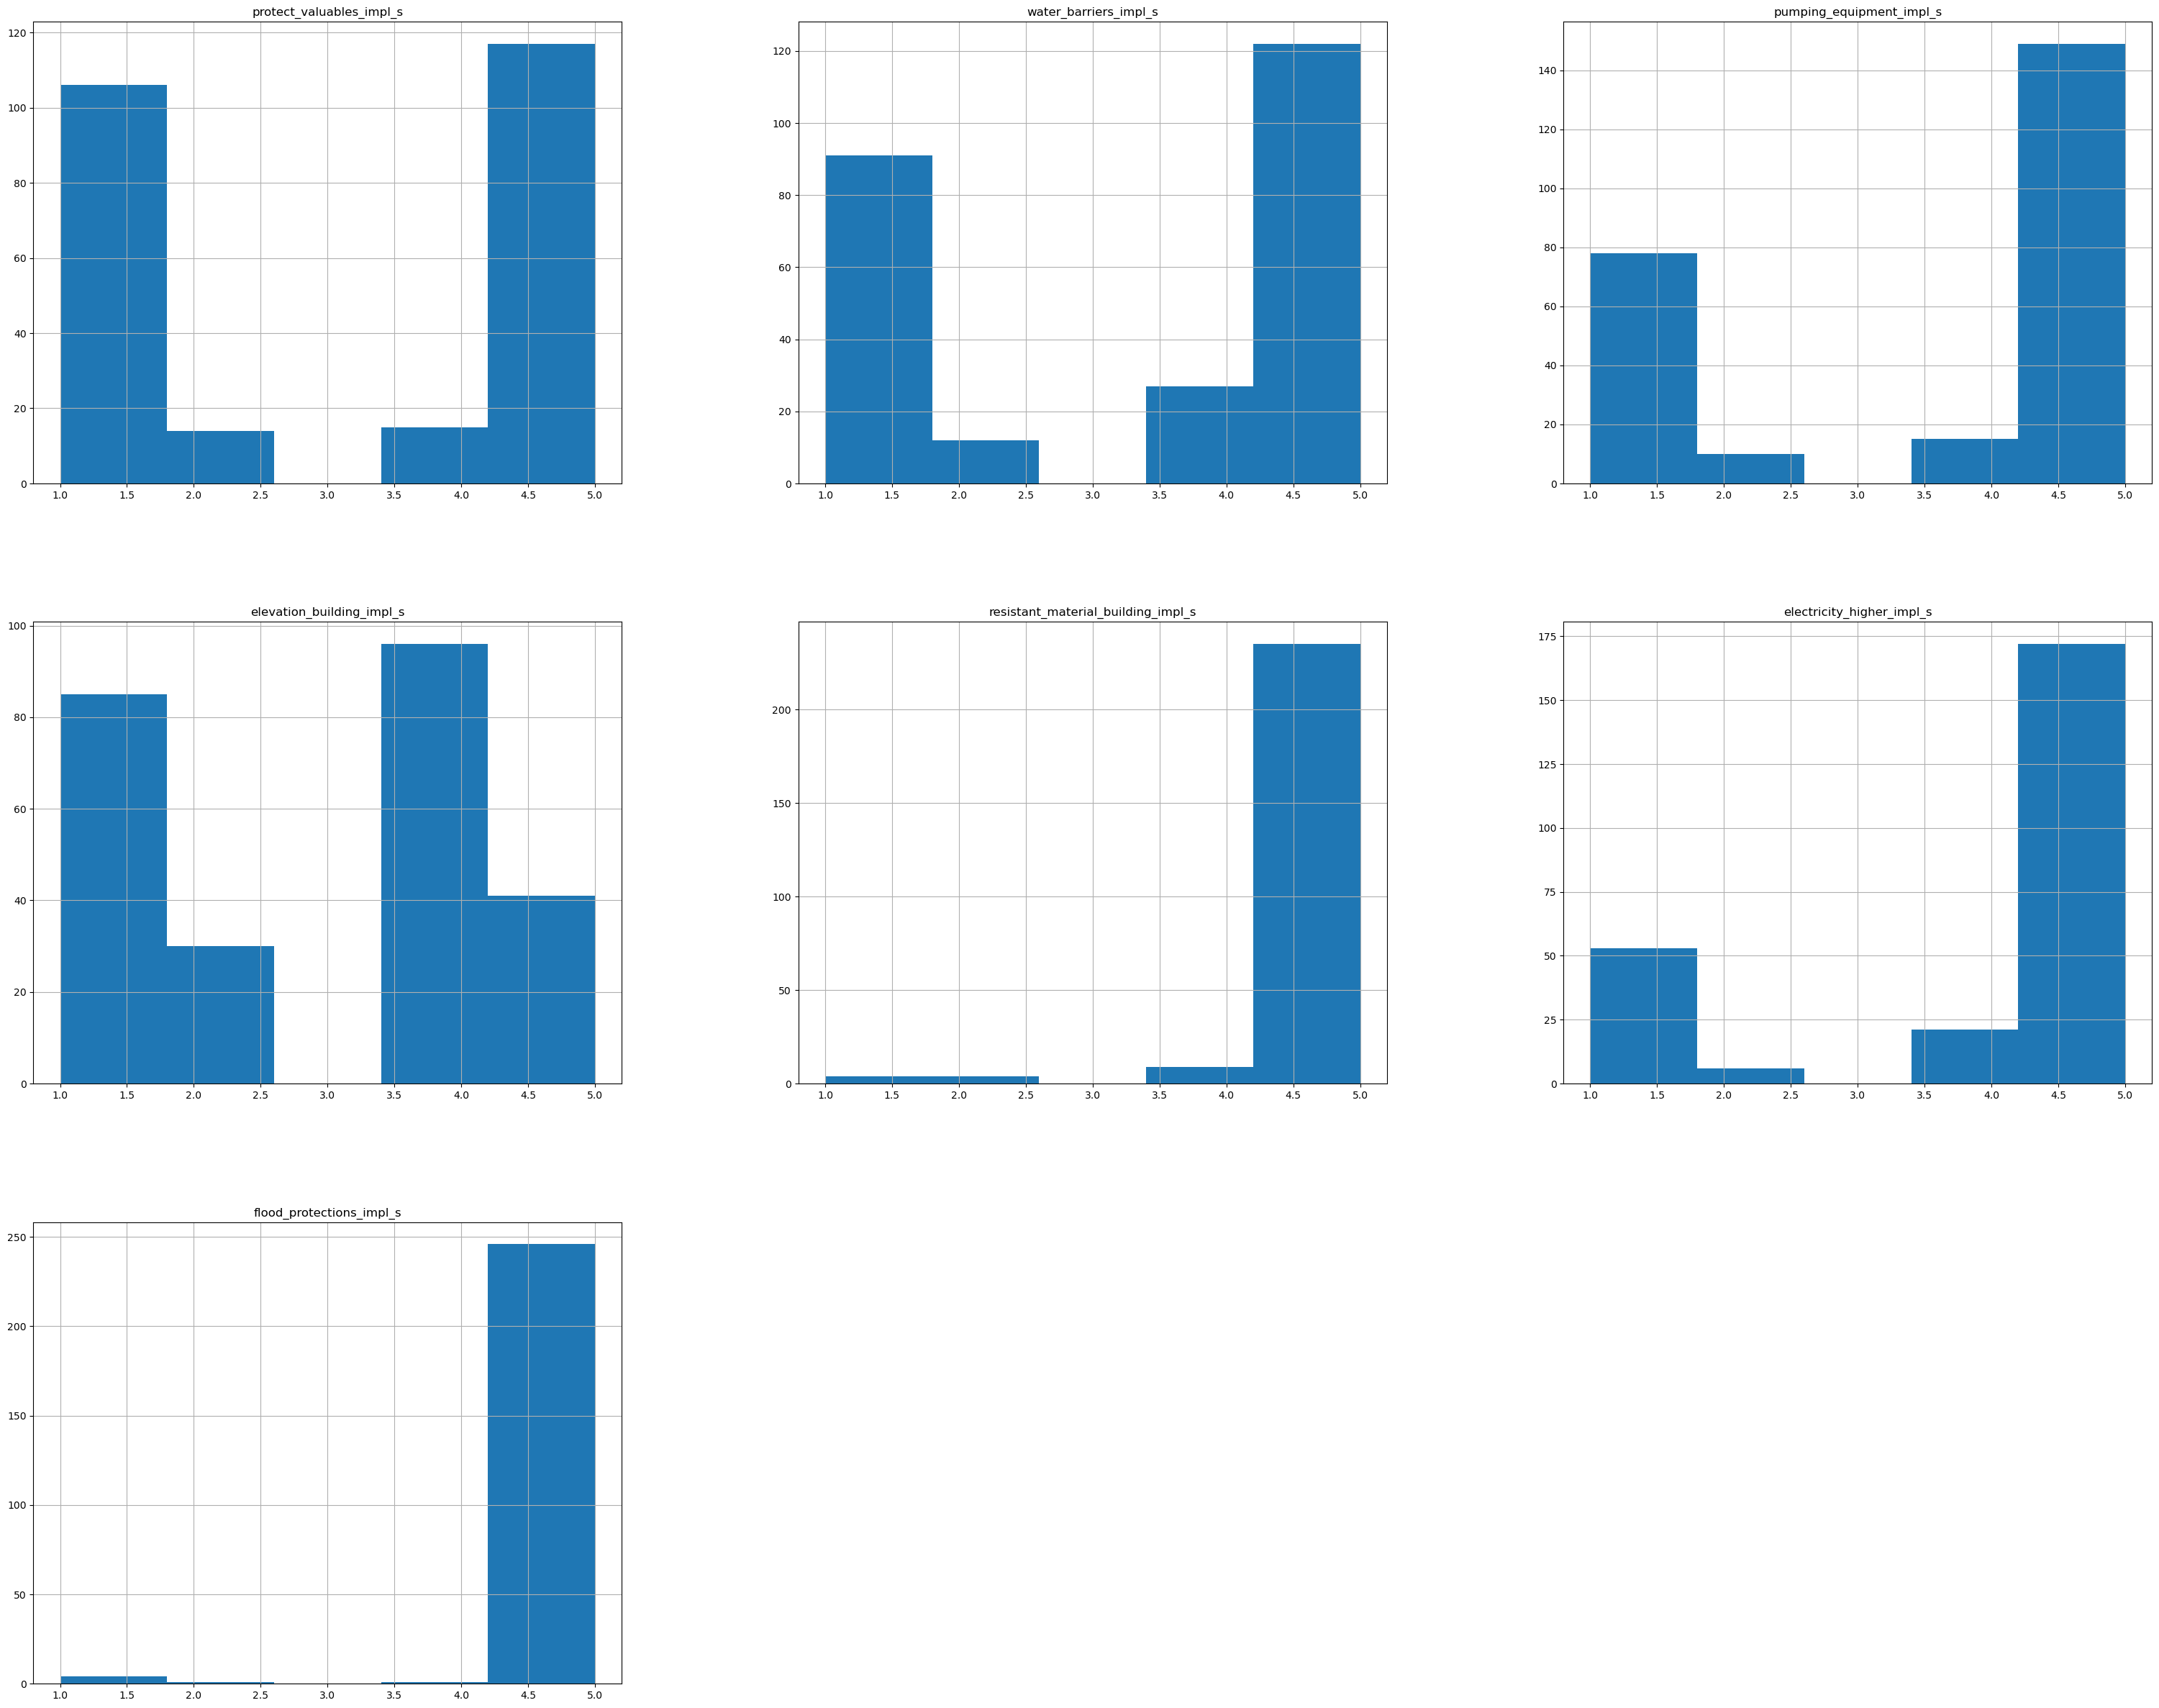

In [23]:
#vars_dam["flood_protections_impl_s"].value_counts() # 2
vars_dam[prec_measures_impl_colnames_s].hist(bins=5, figsize=(38, 30))

# pumping_equipment_impl_s	elevation_building_impl_s	resistant_material_building_impl_s	electricity_higher_impl_s	flood_protections_impl_r

### Socio-economic variables


In [24]:
# part4Q1_cols_list = [r"Target_contentloss_*", r"Target_businessreduction_*", 
#                         r'^hh_monthly_income_cat',  # = e.g.  "hh_monthly_income_cat"
#                         r"^shp_*",  # = e.g "shp_closed_d*", r"shp_sector$", "shp_owner",
#                     ]
# pattern_part4Q1_cols = re.compile('|'.join(part4Q1_cols_list))
# vars_soc = df.filter(regex=pattern_part4Q1_cols, axis=1)
# vars_soc

In [25]:
part4Q1_cols_list = [r"Target_contentloss_*", r"Target_businessreduction_*", 
                        r'^hh_monthly_income_cat',  # = e.g.  "hh_monthly_income_cat"
                        r"^shp_*",  # = e.g "shp_closed_d*", r"shp_sector$", "shp_owner",
                    ]

pattern_part4Q1_cols = re.compile('|'.join(part4Q1_cols_list))
vars_soc = df.filter(regex=pattern_part4Q1_cols, axis=1)

## keep sectors
# shp_sector

## data cleaning
vars_soc = pp.drop_object_columns(vars_soc)
vars_soc = pp.drop_typos(vars_soc).astype("Float64")

#For building variables - during serious and recent events - building age; how long has the 
#householder lived in the location. LU certificate, building cost.
vars_bui = df.loc[:,['lu_cert','b_value_mVND']]
vars_bui["b_area"] = pp.drop_typos(df.b_area)
vars_bui["b_area"]  = pd.to_numeric(vars_bui["b_area"])
flood_year_r = pd.to_datetime(df["flood_time_r"], format='mixed').dt.strftime('%Y')
flood_year_s = pd.to_datetime(df["flood_time_s"], format='mixed').dt.strftime('%Y')
 
vars_bui["flood_year_r"] = flood_year_r
vars_bui["flood_year_s"] = flood_year_s

In [26]:
vars_soc

,Target_contentloss_mVND_r,Target_contentloss_mVND_s,Target_businessreduction_r,Target_businessreduction_s,shp_damage_level_furniture_r,shp_damage_level_electronics_r,shp_damage_level_equipment_r,shp_damage_level_products_r,shp_closed_d_r,shp_duration_back2normal_r,shp_damage_level_furniture_s,shp_damage_level_electronics_s,shp_damage_level_equipment_s,shp_damage_level_products_s,shp_closed_d_s,shp_duration_back2normal_s,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_registered_capital_mVND,shp_suppliers_location.1,shp_suppliers_location.2,shp_suppliers_location.3,shp_suppliers_location.4,shp_suppliers_location.5,shp_suppliers_location.6,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention
0,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,2.0000,3.0000,17.0000,1.0000,2.0000,1.0000,5.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,1.0000,1.0000
1,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,3.0000,3.0000,22.0000,1.0000,2.0000,1.0000,10.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,4.0000,1.0000,1.0000
2,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,4.0000,1.0000,31.0000,1.0000,1.0000,1.0000,10.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,1.0000,1.0000
3,0.0000,0.0000,99.0000,99.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.0000,1.0000,11.0000,1.0000,1.0000,1.0000,99.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,1.0000,1.0000
4,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,3.0000,1.0000,11.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.0000,0.0000,99.0000,99.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,99.0000,1.0000,17.0000,2.0000,3.0000,1.0000,300.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,4.0000,3.0000,3.0000
248,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,11.0000,2.0000,3.0000,1.0000,20.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,4.0000,3.0000,4.0000
249,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,4.0000,3.0000,11.0000,5.0000,3.0000,1.0000,300.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,2.0000,1.0000,2.0000
250,2.0000,2.0000,0.0000,0.0000,1.0000,1.0000,1.0000,4.0000,0.0000,0.0000,1.0000,1.0000,1.0000,4.0000,0.0000,0.0000,4.0000,3.0000,17.0000,2.0000,2.0000,1.0000,100.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000


In [27]:
#df["flood_time_r"]# 
pd.to_datetime(df["flood_time_r"], format='mixed')#.dt.strftime('%Y')

0     2015-01-01
1     2017-09-01
2     2020-08-01
3     2020-07-01
4     2020-07-01
         ...    
247   2019-10-01
248   2019-09-01
249   2017-08-01
250   2019-10-01
251   2018-09-01
Name: flood_time_r, Length: 252, dtype: datetime64[ns]

### Perception variables
The individual perception influences if meaurues for flood protection and prevention are implemented

In [28]:
part3Q1Q2_cols_list = [r"resilience_*", r"^perception_*"] 

pattern_part3Q1Q2_cols = re.compile('|'.join(part3Q1Q2_cols_list))
vars_perception = df.filter(regex=pattern_part3Q1Q2_cols, axis=1)
vars_perception = pp.drop_object_columns(vars_perception)


## order ranks
# 1: Maintained  -> 2
# 2: Reduced  -> 1
# 3: Increased -> 3
vars_perception['perception_govern_support_past'] = vars_perception['perception_govern_support_past'].replace({2:1, 1:2})
vars_perception['perception_govern_support_future'] = vars_perception['perception_govern_support_future'].replace({2:1, 1:2})

# 1: Richer (e.g. for preparing and repairing your house) --> 3
# 2: Poorer --> 1
# 3: Same --> 2
vars_perception['perception_private_economy_future'] = vars_perception['perception_private_economy_future'].replace({2:1, 3:2, 1:3})

## replace 88 = others and typos
vars_perception = vars_perception.replace({88: np.nan, 98: np.nan})

vars_soc = pd.concat([vars_soc, vars_perception], axis=1)

### building variables

In [29]:
df.b_movingin = df.b_movingin.replace(99, np.nan)  # P4Q2.1  
df.b_year = df.b_year.replace(99, np.nan)  # P4Q2.2

## extract cases where building construction or moving in of the households was after the flood event
vars_bui["occ_yrs_r"] = flood_year_r.astype("Int64") - df.b_movingin.astype("Int64")  
vars_bui["occ_yrs_s"] = flood_year_s.astype("Int64") - df.b_movingin.astype("Int64")

vars_bui["bage_r"] = flood_year_r.astype("Int64") - df.b_year.astype("Int64")  # building age since flood event occured
vars_bui["bage_s"] = flood_year_s.astype("Int64") - df.b_year.astype("Int64")


print((vars_bui.occ_yrs_r < 0.0).sum(), "cases in which moving is after recent flood events")
print((vars_bui.occ_yrs_s < 0.0).sum(), "cases in which moving is after serious flood events")
print((vars_bui.bage_r < 0.0).sum(), "cases in which building was constructed after the recent flood event")
print((vars_bui.bage_s < 0.0).sum(), "cases in which building was constructed after the serious flood event")

#For physical damage, if the householder did not live 
#in this house during the reported flood events, we remove those records from further analysis.
#Valid = 1; not valid = 0
vars_bui['valid_r'] = 1
vars_bui['valid_s'] = 1

vars_bui.loc[vars_bui.occ_yrs_r < 0.0, "valid_r"] = 0  # set all cases which moved in or where building was constructed after event to zero
vars_bui.loc[vars_bui.occ_yrs_s < 0.0, "valid_s"] = 0



0 cases in which moving is after recent flood events
0 cases in which moving is after serious flood events
7 cases in which building was constructed after the recent flood event
7 cases in which building was constructed after the serious flood event


In [30]:
## add further building related variables likewise about elevation

#df.filter(regex="elevatio", axis=1)#.value_counts()
vars_bui[["elevation_building_height_cm", "elevation_rel2surrounding_cat", "geometry"]] = df[["elevation_building_height_cm", "elevation_rel2surrounding_cat", "geometry"]]
vars_bui = gpd.GeoDataFrame(vars_bui)

##  elevation height relatve to surrounding 
## 1 - same level, 2- house floor is lower, 3 - house floor is higher 
## for case 1 and 2 -> 0, case 3 --> 1
vars_bui["elevation_rel2surrounding_cat"] = df.elevation_rel2surrounding_cat.replace({1:0, 2:0, 3:1})


In [31]:
## add number of floors and building type from Tuebingen dataset
vars_bui["address"]  = df["housenumber_street"] 
vars_bui["floors"]  = df["Nr_Floors"] 
vars_bui["buildingtype_moon"]  = df["BT_Moon"] 
vars_bui["buildingtype_moon"]  = vars_bui["buildingtype_moon"].replace({"Shop-Traditional":0, "Shop-New":1, "Doppel/Rowhouse":2, "Rudimental":3, "Villa-Individual":4, "other":5})
# Tübing DS housenumber_street	geometry	BT_Moon	Nr_Floors	BT_TUEB_2	



### Add geolocations particilay imporved by Tuebing dataset

In [32]:
vars_bui["geometry"] = df["geometry"]

### Renovation

In [33]:
## If major renovation -> change bage to that. Otherwise, original bage

ren1= df["ren1"] # first renovation
ren2 = df["ren2"]  # second renovaton

## clean renonvation time, convert into uniform date format
ren1 = ren1.replace({r"^99":"01", np.nan:"01/01/1970", " ": "01/01/1970"}, regex=True)
ren2 = ren2.replace({r"^99":"01", np.nan:"01/01/1970", " ": "01/01/1970"}, regex=True)


## set missing days and months to 01
#ren1 = pd.to_datetime(ren1, format='mixed')
#ren2 = pd.to_datetime(ren2, format='mixed')

## fix dates for which only year exists and pass to renovation time
for i, d in enumerate(ren1):
    
    if (type(d) == int) & (len(str(d))==4):  # only year exists
        d = f"01/01/{d}"
        ren1[i] = pd.to_datetime(d, format='mixed').strftime('%m/%d/%Y')

    if (len(str(d))==7):  # only month or day and year exists
        m, y = d.split("/",1)
        d = f"{m}/01/{y}"
        ren1[i] = pd.to_datetime(d).strftime('%m/%d/%Y')


for i, d  in enumerate(ren2):
    
    if (type(d) == int) & (len(str(d))==4):  # only year exists
        d = f"01/01/{d}"
        ren2[i] = pd.to_datetime(d, format='mixed').strftime('%m/%d/%Y')
    
    if (len(str(d))==7):  # only month or day and year exists
        m, y = d.split("/",1)
        d = f"{m}/01/{y}"
        ren2[i] = pd.to_datetime(d).strftime('%m/%d/%Y')


ren1 = pd.to_datetime(ren1, format='mixed').dt.strftime('%m/%d/%Y') # convert remaining mix of formats to date
ren2 = pd.to_datetime(ren2, format='mixed').dt.strftime('%m/%d/%Y')

ren1_year = pd.to_datetime(ren1).dt.year
ren2_year =pd.to_datetime(ren2).dt.year

ren1_year = ren1_year.replace({1970:np.nan})
ren2_year = ren2_year.replace({1970:np.nan})


In [34]:
## Recent events
ren1_ev_r = flood_year_r.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_r = flood_year_r.astype("Int64") - (ren2_year).astype("Int64")

ren1_ev_r.loc[ren1_ev_r < 0] = np.nan   # replace when renovations were after flood events
ren2_ev_r.loc[ren2_ev_r < 0] = np.nan

rec_ren_year = pd.concat([ren1_ev_r, ren2_ev_r], axis=1).min(axis=1, skipna=True)


In [35]:
## Serious events 
ren1_ev_s = flood_year_s.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_s = flood_year_s.astype("Int64") - (ren2_year).astype("Int64")

ren1_ev_s[ren1_ev_s < 0] = np.nan  # replace when renovations were after flood events
ren2_ev_s[ren2_ev_s < 0] = np.nan

ext_ren_year = pd.concat([ren1_ev_s, ren2_ev_s], axis=1).min(axis=1, skipna=True)
ext_ren_year.loc[ext_ren_year<0] = df.b_year.astype("Int64")[ext_ren_year<0]
ext_ren_year.loc[ext_ren_year == 99] = np.nan

In [36]:
vars_bui["bage_ren1"] = vars_bui.bage_r.copy()
vars_bui["bage_ren2"] = vars_bui.bage_s.copy()

## if not nan than replace value in bage_ren
vars_bui.bage_ren1 = np.where( ~rec_ren_year.isna(), rec_ren_year, vars_bui.bage_ren1)
vars_bui.bage_ren2 = np.where( ~ext_ren_year.isna(), ext_ren_year, vars_bui.bage_ren2)

vars_bui.bage_ren1 = vars_bui.bage_ren1.astype("Int64")  # convert while preseving NAN
vars_bui.bage_ren2 = vars_bui.bage_ren2.astype("Int64") 

vars_bui.loc[vars_bui.bage_ren1 < 0, "bage_ren1"] = np.nan
vars_bui.loc[vars_bui.bage_ren2 < 0, "bage_ren2"] = np.nan

vars_bui.bage_r[vars_bui.bage_r < 0] = np.nan
vars_bui.bage_s[vars_bui.bage_s < 0] = np.nan


In [37]:
vars_bui[["bage_r", "bage_s", "bage_ren1", "bage_ren2"]].describe()

,bage_r,bage_s,bage_ren1,bage_ren2
count,235.0000,234.0000,238.0000,237.0000
mean,19.8213,18.6709,14.4328,13.9325
std,13.6091,13.5877,13.2538,13.1254
min,0.0000,0.0000,0.0000,0.0000
25%,10.5000,10.0000,4.0000,3.0000
50%,19.0000,17.0000,10.5000,12.0000
75%,24.0000,23.7500,20.0000,20.0000
max,100.0000,100.0000,66.0000,66.0000


### building damage variables

Absolute and relative building loss are not calculated due that they seem to be less important for content loss modelling. 

In [38]:

# abs_loss_ev1 = df["repair_costs_building_VND_r"]  #:'P1Q3.8.1'

# # Id abs_loss is 2, then no repairs are made. One of the plausible reasons for no repairs is no damage or very minor damage. We replace these 2s by 0. 
# # Find zero-loss values
# # # Damage level (1-5): 98: not applicable; 99: I don’t know, 1: No damage; 2: Minor damages - Usable; 3: Moderate damages; 4: Major damages – needs repair; 5: Complete damage – needs replacement

# list_zero_loss_values = [1, 99, 98]

# abs_loss_ev1 = np.where(
#         (
#             (df["reason_why_not_repaired_business_r.4"]==1) | # P1Q3.10.1.4: It’s not necessary because it will be flooded soon again (1: true)
#             (df["reason_why_not_repaired_business_r.3"]==1) | # P1Q3.10.1.3: It’s not necessary (minor damages, still usable, livable) (1: true)
#             (df["overall_problem_house_r"]==1) |   # P1Q2.11.1.1: No problem (1==true)
#             (
#                 (df["damage_level_floor_r"].isin(list_zero_loss_values)) &  # P1Q3.2.1
#                 (df["damage_level_walls_r"].isin(list_zero_loss_values)) &  # P1Q3.3.1
#                 (df["damage_level_foundation_r"].isin(list_zero_loss_values)) & # P1Q3.4.1
#                 (df["damage_level_doors_r"].isin(list_zero_loss_values)) &  # P1Q3.5.1
#                 (df["damage_level_roof_r"].isin(list_zero_loss_values)) &  # P1Q3.6.1
#                 (df["damage_level_basement_r"].isin(list_zero_loss_values)) # P1Q3.7.1
#             )
#             ) & (df["repair_costs_building_VND_r"] == 2),  # P1Q3.8.1 (2: I did not repair anything)
#         0, abs_loss_ev1  
#     )

# #If no evidence of minor damage or residual damage, approximate it to what would have occured if you repaired the house completely.
# abs_loss_ev1 =  np.where(
#     (abs_loss_ev1==2) & (df["repair_costs_building_complete_mVND_r"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_r"] * 1000000,  ## # condition fullfilled, set to costs to VND
#     abs_loss_ev1   # condition not fullfilled, set to 99
# )

# abs_loss_ev1 =  np.where(
#     (abs_loss_ev1==99) & (df["repair_costs_building_complete_mVND_r"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_r"] * 1000000,  ## condition fullfilled, set to costs to VND
#     abs_loss_ev1  ## condition not fullfilled, set to 99
# )

# abs_loss_ev1 = pd.Series(abs_loss_ev1).astype("Int64")  # Int64 = handles nan
# abs_loss_ev1[abs_loss_ev1==99]= np.nan

In [39]:
# ## most serious

# abs_loss_ev2 = df["repair_costs_building_VND_s"]  #:'P1Q3.8.2'

# # Id abs_loss is 2, then no repairs are made. One of the plausible reasons for no repairs is no damage or very minor damage. We replace these 2s by 0. 
# # Find zero-loss values
# # # Damage level (1-5): 98: not applicable; 99: I don’t know, 1: No damage; 2: Minor damages - Usable; 3: Moderate damages; 4: Major damages – needs repair; 5: Complete damage – needs replacement

# list_zero_loss_values = [1, 99, 98]

# abs_loss_ev2 = np.where(
#         (
#             (df["reason_why_not_repaired_business_s.4"]==1) | # P1Q3.10.2.4: It’s not necessary because it will be flooded soon again (1: true)
#             (df["reason_why_not_repaired_business_s.3"]==1) | # P1Q3.10.2.3: It’s not necessary (minor damages, still usable, livable) (1: true)
#             (df["overall_problem_house_s"]==1) |   # P1Q2.11.2.1: No problem (1==true)
#             (
#                 (df["damage_level_floor_s"].isin(list_zero_loss_values)) &  # P1Q3.2.2
#                 (df["damage_level_walls_s"].isin(list_zero_loss_values)) &  # P1Q3.3.2
#                 (df["damage_level_foundation_s"].isin(list_zero_loss_values)) & # P1Q3.4.2
#                 (df["damage_level_doors_s"].isin(list_zero_loss_values)) &  # P1Q3.5.2
#                 (df["damage_level_roof_s"].isin(list_zero_loss_values)) &  # P1Q3.6.2
#                 (df["damage_level_basement_s"].isin(list_zero_loss_values)) # P1Q3.7.2
#             )
#         ) & (df["repair_costs_building_VND_s"] == 2),  # P1Q3.8.2 (2: I did not repair anything)
#         0,    # if condition fullfilled
#         abs_loss_ev2  # else 
#     )

# ## absolute losses in [VND]
# #If no evidence of minor damage or residual damage, approximate it to what would have occured if you repaired the house completely.
# abs_loss_ev2 =  np.where(
#     (abs_loss_ev2 == 2) & (df["repair_costs_building_complete_mVND_s"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_s"] * 1000000,  ## # condition fullfilled, set to costs to VND
#     abs_loss_ev2   # condition not fullfilled, set to 99
# )

# abs_loss_ev2 =  np.where(
#     (abs_loss_ev2 == 99) & (df["repair_costs_building_complete_mVND_s"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_s"] * 1000000,  ## condition fullfilled, set to costs to VND
#     abs_loss_ev2  ## condition not fullfilled, set to 99
# )

# abs_loss_ev2 = pd.Series(abs_loss_ev2).astype("Int64")  # Int64 = can keep nan
# abs_loss_ev2[abs_loss_ev2==99]= np.nan


#### Building value


In [40]:
vars_bui["b_value_mVND"] = df["b_value_mVND"].astype("Int64")  # = P4Q2.5: building value if sell or rebuild completely
vars_bui.b_value_mVND[vars_bui.b_value_mVND == 99.0] = np.nan


#### Content value

Derive content value (cv) from building value (bv)

Registered capital is based on bv + cv (if interviewee is owner)  
US HAZUS uses bv = 100% cv (trade, serivces), bv =150% cv (light+heavy industry, food and metall) 

similar work regarding cv: Chinh 2015, Paprotny2020

In [41]:
## due that only a few buildings have now floor info, the missing floor values are filled by the constant of 2 floors per building
print(vars_bui.floors.describe() )

vars_bui["floors"] = vars_bui["floors"].replace({np.nan:2, 0:2}).astype(int) # replace buildings with missing or unreasonable height
#print(vars_bui.floors.describe() )


count   67.0000
mean     1.7015
std      0.8706
min      0.0000
25%      1.0000
50%      2.0000
75%      2.0000
max      6.0000
Name: floors, dtype: float64


In [42]:
vars_soc.shp_registered_capital_mVND[vars_soc.shp_registered_capital_mVND == 99.0] = np.nan

vars_bui["shp_building_value_mVND"] = vars_bui.b_value_mVND / vars_bui.floors
vars_bui["shp_building_value_mVND"] = vars_bui["shp_building_value_mVND"].astype("Int64")  # Int64 = keep nan
print("Number of businesses for which registered capital is less than value for commercial building part:", (vars_soc.shp_registered_capital_mVND < vars_bui.shp_building_value_mVND).sum())
#print("No building value information: ", vars_bui.shp_building_value_mVND.isna().sum())
#print("No registered capital information: ", vars_soc.shp_registered_capital_mVND.isna().sum())

# ## quick check number of business owner
print(vars_soc.shp_owner.value_counts())  # 1- owner , 2- manager 3 - both, 88 - other


vars_bui["shp_building_value_mVND"].describe()

Number of businesses for which registered capital is less than value for commercial building part: 185
shp_owner
3.0000     125
1.0000     108
2.0000      14
88.0000      5
Name: count, dtype: Int64


count    216.0000
mean     496.3194
std      601.1185
min       30.0000
25%      200.0000
50%      350.0000
75%      500.0000
max     5500.0000
Name: shp_building_value_mVND, dtype: Float64

Due that registered capital can not be used as input variable to derive content losses another apporach is utilitized:
It is tested if the updated dataset with improved geolocations and detailed building information from the Tuebingen group improves model perfomrances

In [43]:
# # Alternative approach: 

## Assigne 1/4 of shp_building_value as = shp_content_value
vars_bui["shp_content_value_mVND"] = vars_bui.b_value_mVND  / vars_bui.floors.astype(int) * 0.25 # shop cv as the ration between bv and number of floors
vars_bui["shp_content_value_mVND"] = vars_bui["shp_content_value_mVND"].astype("Int64") 
vars_bui["shp_content_value_mVND"].describe()



count    216.0000
mean     123.8472
std      150.3512
min        7.0000
25%       50.0000
50%       87.0000
75%      125.0000
max     1375.0000
Name: shp_content_value_mVND, dtype: Float64

<!-- Test: is building area a better source to derive content vaule than floor number? -->

In [44]:
vars_bui["shp_content_value_mVND"] = vars_bui.b_value_mVND / vars_bui.floors.astype(int)  * 0.25 # shop cv as the ration between bv and building footprint
vars_bui["shp_content_value_mVND"] = vars_bui["shp_content_value_mVND"].astype("Int64") 

vars_bui["shp_content_value_mVND"] = vars_bui["shp_content_value_mVND"]

vars_bui["shp_content_value_mVND"].describe()
## idea: capital investment * sqrm  = cv 

# HCMC: median in euro (no inflation): 13 471 €

# ## with divide by floor number
# # count         216.0
# # mean     496.319444
# # std      601.118519
# # min            30.0
# # 25%           200.0
# # 50%           350.0
# # 75%           500.0
# # max          5500.0

## HCMC new cv (no inflation corrected): median : 3300 €, mean: 4750 € , 1Quantile_ 1916 €

count    216.0000
mean     123.8472
std      150.3512
min        7.0000
25%       50.0000
50%       87.0000
75%      125.0000
max     1375.0000
Name: shp_content_value_mVND, dtype: Float64

In [45]:
vars_bui.buildingtype_moon.value_counts()

buildingtype_moon
0.0000    48
1.0000     8
5.0000     6
2.0000     2
3.0000     2
4.0000     2
Name: count, dtype: int64

### Spatial variable
*Currently not used due to the high discrepancy between geolocation from the survey and the actual locations of the shops, derived by the comaprison of HCMC reported geolocations with gmaps and OSM.*

Add information about terrain height above sea level as a predictor. This is a common approach for geograpihc related issues to improve the predictive power of multi-variate models by adding spatial information.

In [46]:
# dem__lufi_pts = gpd.read_file("../input_survey_data/DEM_LiDAR/HCMC_Lidar_2020_DEM_4326_LuFi_points.shp")  # shop locations including elevation height based on original and interpolated DEM

# dem__lufi_pts = gpd.GeoDataFrame(dem__lufi_pts,  
#             geometry=gpd.points_from_xy( 
#                      dem__lufi_pts["geometry"].x,  # lon
#                      dem__lufi_pts["geometry"].y, #lat
#             )
#         )

# ## crs of 4326 is in degree unit

In [47]:
# ## assigne DEM point locations to shp location of dataframe, silght differences in coordinates due to conversion
# vars_bui = gpd.sjoin_nearest(vars_bui, dem__lufi_pts, how='left')
# vars_bui = vars_bui.set_geometry('geometry')
# vars_bui = vars_bui.drop(["index_right"], axis=1)


In [48]:
# ## replace locations with missing elevation by interpolated DEM (all locations with missing elevation height have value 0.0 )
# #print(vars_bui[vars_bui.HCMC_Lidar==0.0])
# vars_bui.HCMC_Lidar = np.where(vars_bui.HCMC_Lidar==0.0, vars_bui.LuFIDEMInt, vars_bui.HCMC_Lidar)

In [49]:
# vars_bui = vars_bui.rename(columns={"HCMC_Lidar":"elevation_m"})
# vars_bui = vars_bui.drop("LuFIDEMInt", axis =1)
# vars_bui.insert(len(vars_bui.columns)-2, "elevation_m", vars_bui.pop("elevation_m"))


## Select predictors and merge identical events


In [50]:
vars_bui = vars_bui.drop(['occ_yrs_r', 'occ_yrs_s', 'valid_r', 'valid_s'],axis=1)


# ## column renameing for vars_soc and vars_dam was previously done 
# vars_dam["rloss_1"] = rloss_ev1
# vars_dam["rloss_2"] = rloss_ev2
# vars_dam["bloss_1"] = abs_loss_ev1
# vars_dam["bloss_2"] = abs_loss_ev2


In [51]:
vars_dam["id"] = range(len(df))

vars_dam = pp.drop_typos(vars_dam)

## select cases with recent events and non specific cols
data_ip1 = pd.concat(
  [vars_dam.loc[:, "flood_time_r":"overall_problem_house_r.9"],  # flood vars, damage vars
    vars_dam.loc[:,"same":"flood_protections_impl_r"],  #  same, precaution measures, 
    vars_dam.loc[:,["flood_experience"]], 
    #vars_dam.loc[:, ["rloss_1", "bloss_1"]], 
 ], axis=1
)

print(f"Identical events are: {(vars_dam.same==True).sum()}")

## drop unique endings to obtain identical column names in both dfs
data_ip1.columns = data_ip1.columns.str.replace('_r', '')
data_ip1.columns = data_ip1.columns.str.replace('_1', '') 



## if not identical event select serious events
for i in range(len(data_ip1.loc[:,:])):  
  if (data_ip1.same[i]==False):   #  events are different, select also serious event
    sev = pd.concat(
        [vars_dam.loc[i, "flood_time_s" : "overall_problem_house_s.9"],  # flood-vars, damage-vars
         vars_dam.loc[i, ["same"]],
         vars_dam.loc[i, "protect_valuables_impl_s": "flood_experience"],  # precaution measures, flood experience
         #vars_dam.loc[i, ["rloss_2", "bloss_2"]]
        ]
    )

    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns =sev.columns.str.replace('_s', '') 
    sev.columns =sev.columns.str.replace('_2', '') 
    sev[1:] = sev[1:].apply(pd.to_numeric)  # exclude datetime-column: flood_time

    ## append events which are not identical to a recent event
    data_ip1 = pd.concat([data_ip1, sev], ignore_index=True)



Identical events are: 107


In [52]:
vars_bui.columns

Index(['lu_cert', 'b_value_mVND', 'b_area', 'flood_year_r', 'flood_year_s',
       'bage_r', 'bage_s', 'elevation_building_height_cm',
       'elevation_rel2surrounding_cat', 'geometry', 'address', 'floors',
       'buildingtype_moon', 'bage_ren1', 'bage_ren2',
       'shp_building_value_mVND', 'shp_content_value_mVND'],
      dtype='object')

In [53]:
vars_bui["id"] = range(len(df))

## select cases with recent events and non specific cols
data_ip2 = pd.concat(
  [vars_bui.loc[:, ["flood_year_r", "elevation_building_height_cm",	"elevation_rel2surrounding_cat"]],
    vars_bui.loc[:, ["bage_r", "b_area", "geometry"]],
    vars_bui.loc[:, ["floors", "buildingtype_moon"]], 
    vars_bui.loc[:, "shp_building_value_mVND": "id"],
    ], axis=1
)
data_ip2.columns = data_ip2.columns.str.replace('1','')
data_ip2.columns = data_ip2.columns.str.replace('_r$', '', regex=True) 

## if not identical event select serious events
for i in range(len(data_ip2.loc[:,:])): 
  if (vars_dam.same[i]==False):
    sev = pd.concat(
        [vars_bui.loc[i, ["flood_year_s", "elevation_building_height_cm",	"elevation_rel2surrounding_cat"]],
            vars_bui.loc[i, ["bage_s", "b_area", "geometry"]], 
            vars_bui.loc[i, ["floors", "buildingtype_moon"]], 
            vars_bui.loc[i, "shp_building_value_mVND": "id"]
        ]
      )
    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns = sev.columns.str.replace('_s', '')
    sev.columns = sev.columns.str.replace('2$', '', regex=True) 

    ## append events which are not identical to a recent event
    data_ip2 = pd.concat([data_ip2, sev], ignore_index=True)


In [54]:
data_ip2

,flood_year,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,geometry,floors,buildingtype_moon,shp_building_value_mVND,shp_content_value_mVND,id
0,2015,80,1,12,25.0000,POINT EMPTY,2,NaN,50,12,0
1,2017,70,1,0,21.0000,POINT (106.6990667908692 10.796493095049405),2,0.0000,50,12,1
2,2020,50,1,21,50.0000,POINT (106.70080527790017 10.797540370705613),1,0.0000,900,225,2
3,2020,,1,20,25.0000,POINT (106.70113583213717 10.797534729984251),3,0.0000,133,33,3
4,2020,10,1,20,80.0000,POINT (106.70003992972188 10.797443653167456),1,0.0000,900,225,4
...,...,...,...,...,...,...,...,...,...,...,...
392,2019,70,1,1,80.0000,POINT (106.69150683690447 10.66047886618251),1,0.0000,1000,250,242
393,2017,60,0,30,60.0000,POINT EMPTY,2,NaN,350,87,243
394,2017,70,1,25,80.0000,POINT EMPTY,2,NaN,NaN,NaN,245
395,2017,70,1,NaN,130.0000,POINT EMPTY,2,NaN,NaN,NaN,247


In [55]:
vars_soc["id"] = range(len(df))

## select cases with recent events and non specific cols
data_ip3 = pd.concat(
  [vars_soc.loc[:, ["Target_contentloss_mVND_r", "Target_businessreduction_r"]],#[:,:4],
    vars_soc.loc[:, "hh_monthly_income_cat":] #  monthly_income, firm specific variables eg. ownership, monthly sale.., resilience and perception vars
      ], axis=1
)

#sev_list = []
data_ip3.columns = data_ip3.columns.str.replace('_r$', '', regex=True) 

## if not identical event select serious events
for i in range(len(data_ip3.loc[:,:])): 
  if (vars_dam.same[i]==False):  
    sev = pd.concat(
        [vars_soc.loc[i, ["Target_contentloss_mVND_s", "Target_businessreduction_s"]],
            vars_soc.loc[i, "hh_monthly_income_cat":]
        ], 
      )
    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns = sev.columns.str.replace('_s$', '', regex=True) 

    #sev_list.append(sev)
    ## append not identical events to end of df
    data_ip3 = pd.concat([data_ip3, sev], ignore_index=True)


In [56]:
## add geometries for creation of Maps (e.g. FP,TN,TP, FN map for classification)

data_ip4 = df.geometry

### Combine all important variabels 

In [57]:
## merged cases
all_input = pd.concat(
        [data_ip1.loc[:, data_ip1.columns != 'id'], 
        data_ip2.loc[:, data_ip2.columns != 'id'],
        data_ip3,
        data_ip4
        ], axis=1
)

Number of cases is larger than from Rscript, due that col "same" incoporates flood times and more varibles are used.

 2*145 + 1 * 107 = 397 cases [count different events twice, identical events once]

## Feature reduction


Simple approaches to reduce Multicollinearity:
- zero variance features
- Remove some of the highly correlated independent variables - Not APPLIED yet in subsequent part of the script - their influence in FS models is tested first and than they will be removed here and a combined indicator for resilience features will be tested on model performance
- Linearly combine the independent variables, such as adding them together - APPLIED in subsequent part of the script
- Partial least squares regression uses principal component analysis to create a set of uncorrelated components to include in the model.
- apply regularized linear models such as elastic net - APPLIED in Feature selection section
Some features might be less important for model performance, they are left in feature space so far.


#### Minor cleaning 

Fix commas and 99, empty columns, spatial drop

Empty cells or the interviewee could not answer the question (“I don’t know”) were all set to missing number (not a number: NaN) and for dates to missing date (not a date: NaT). Nulls were left unchanged, ie. for the target variables for which it is assumed that the interviewee had no direct or indirect content losses.

In [58]:
all_input["shp_employees"] = all_input["shp_employees"].astype("Int64")
all_input["shp_employees"].describe()


count   397.0000
mean      1.9370
std       2.0396
min       1.0000
25%       1.0000
50%       2.0000
75%       2.0000
max      34.0000
Name: shp_employees, dtype: Float64

In [59]:
# fix data types
all_input.flood_time = pd.to_datetime(all_input.flood_time, format='mixed')


## fix obj columns - convert to numeric by keeping nan values
all_input_obj = all_input.select_dtypes(include=object)  # all obj cols
all_input_obj =all_input_obj.drop("geometry", axis=1)

for c in all_input_obj.columns:
    all_input[c]  =  pp.drop_typos(all_input_obj[c]).apply(pd.to_numeric)  # convert to int or float,  handles NAN

all_input = all_input.replace(99, np.nan)

### Variance and collinearity of features before Feature Reduction

Remove features with zero or near zero variance or merge them into indicators. Do this in respect to the amount of missing data stored in the features. Reduce colinearity between similar features by mergin them into indicators

In [60]:
## drop of columns which were only needed to develop the datasets

all_input = all_input.drop(
    [
        "flood_time", "flood_year", "id", "same", #"geometry",  # keep geoms for results to plot in MAPs
    ],  
    axis=1
    )

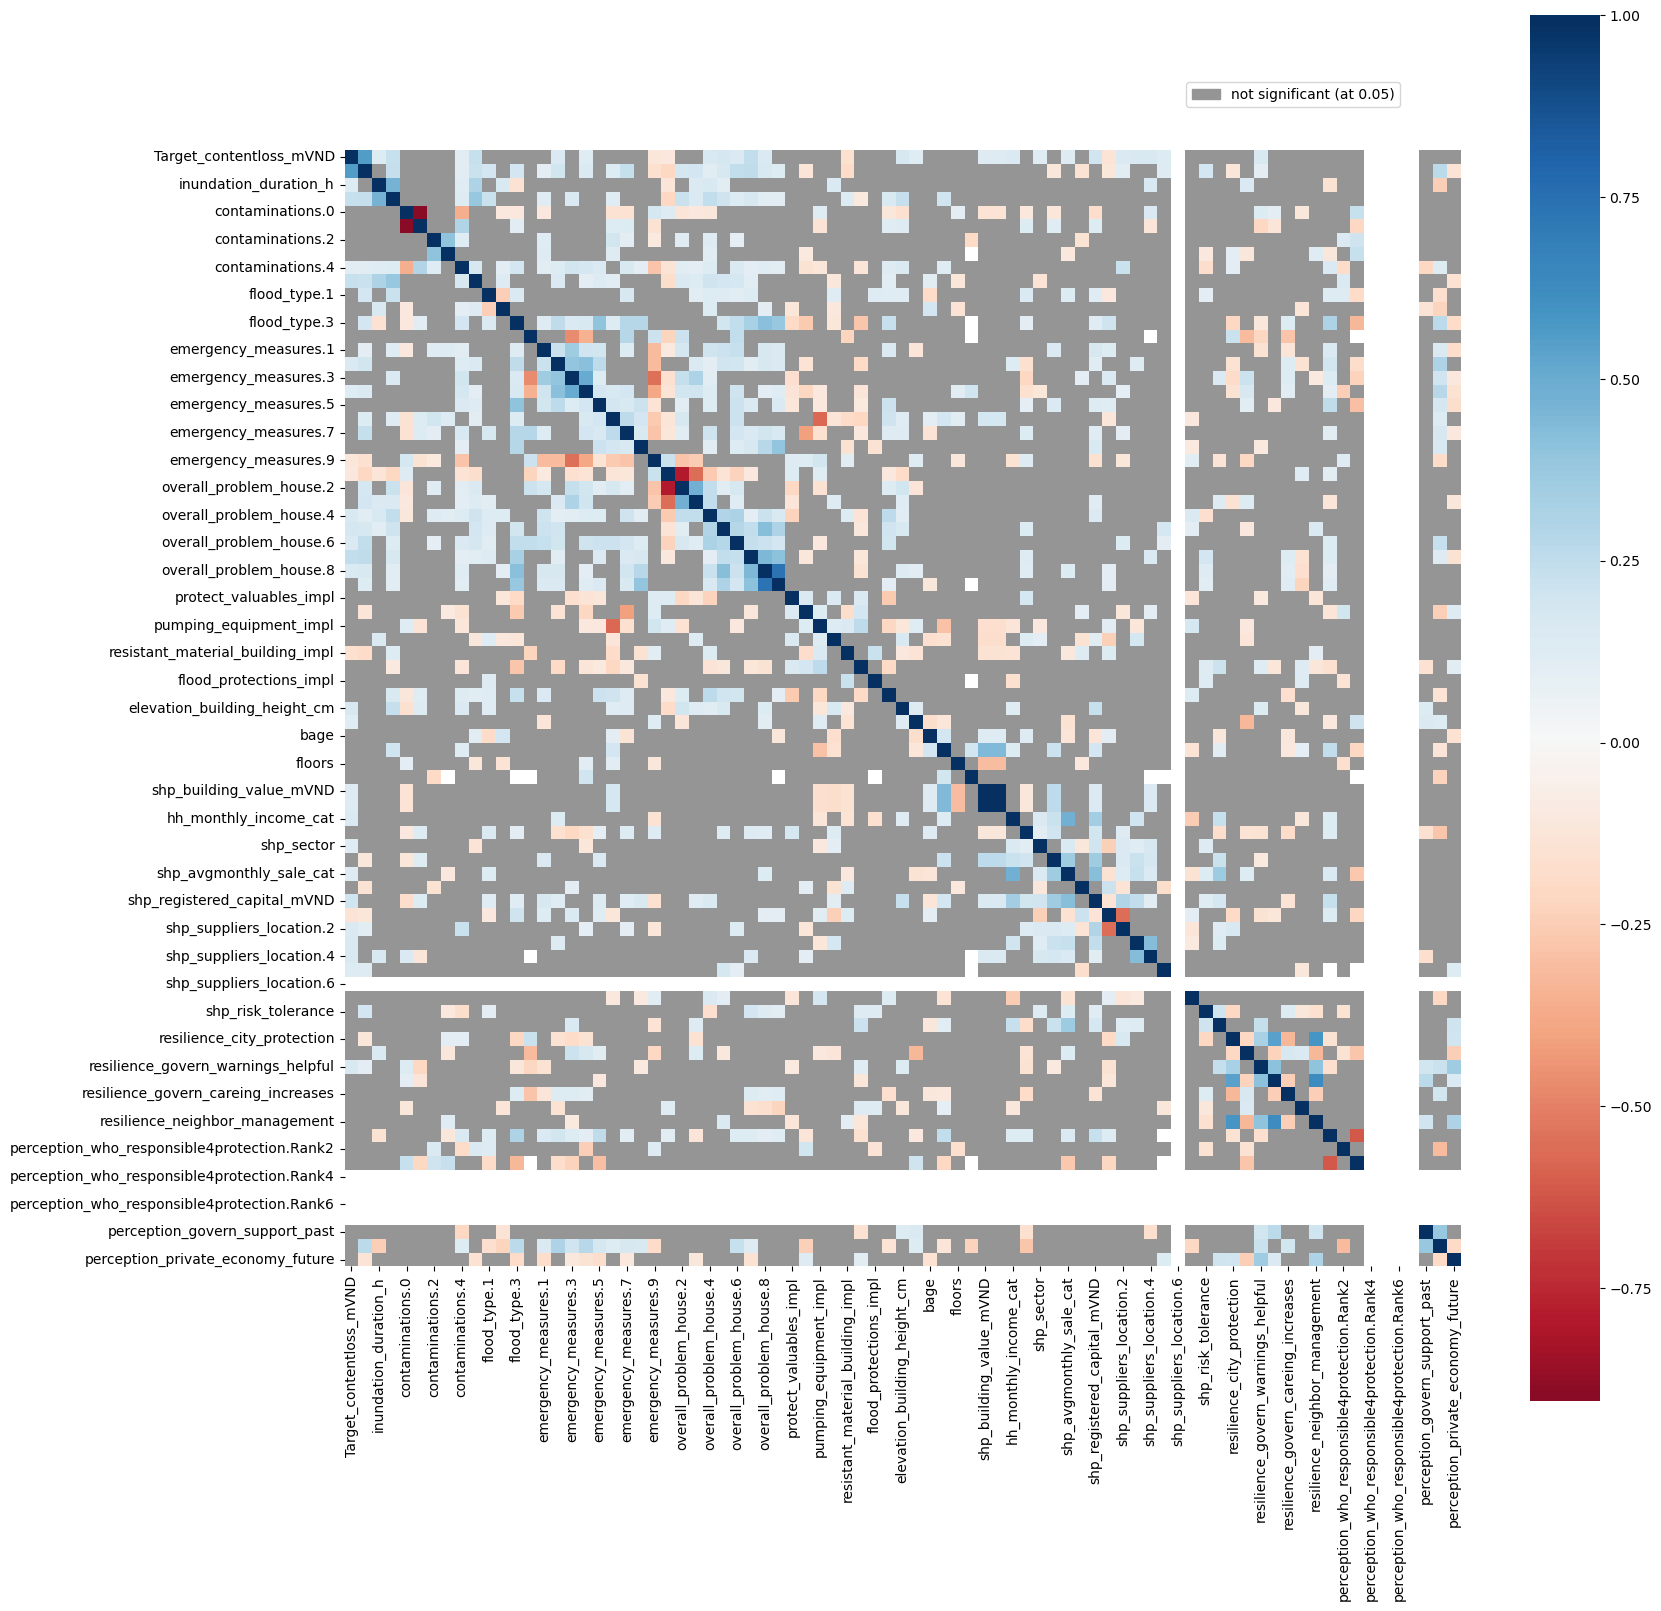

In [61]:
## move targets to beginning
all_input.insert(0, "Target_contentloss_mVND", all_input.pop("Target_contentloss_mVND"))
all_input.insert(1, "Target_businessreduction", all_input.pop("Target_businessreduction"))

plt.figure(figsize=(18,18))
f.plot_spearman_rank(all_input.drop("geometry", axis=1), min_periods=50, signif=True, psig=0.05)


In [62]:
X_scaled = MinMaxScaler().fit_transform(
    all_input.drop(
        ["Target_contentloss_mVND", "Target_businessreduction", "geometry"], 
        axis=1
    )
)
X_scaled = pd.DataFrame(
    X_scaled,
    columns=all_input.drop(["Target_contentloss_mVND", "Target_businessreduction", "geometry"], axis=1).columns
)


df_variance = X_scaled.var()
df_variance = np.round(df_variance, 5)
print(pd.DataFrame({"variance":df_variance}).sort_values("variance").head(25))

var = []
for i in range(0, len(df_variance)):
    if df_variance[i] != 0.00000:
            var.append(X_scaled.columns[i])
df_variance = pd.DataFrame({"variance":df_variance}).sort_values("variance")

                                             variance
shp_suppliers_location.6                       0.0000
perception_who_responsible4protection.Rank7    0.0000
perception_who_responsible4protection.Rank6    0.0000
perception_who_responsible4protection.Rank5    0.0000
shp_registered_capital_mVND                    0.0031
shp_employees                                  0.0038
inundation_duration_h                          0.0049
shp_suppliers_location.5                       0.0050
floors                                         0.0092
shp_building_value_mVND                        0.0094
shp_content_value_mVND                         0.0094
b_area                                         0.0098
shp_suppliers_location.4                       0.0100
overall_problem_house.9                        0.0149
flood_protections_impl                         0.0188
shp_owner                                      0.0194
bage                                           0.0196
elevation_building_height_cm

In [63]:
pp.percentage_of_nan(all_input)

12-21-2023 10:31:47 - __preprocessing__ - INFO - Percentage of missing values per feature [%]
 perception_who_responsible4protection.Rank7   99.0000
perception_who_responsible4protection.Rank6   99.0000
perception_who_responsible4protection.Rank5   99.0000
perception_who_responsible4protection.Rank4   91.0000
warning_time_h                                78.0000
buildingtype_moon                             73.0000
perception_who_responsible4protection.Rank3   69.0000
perception_who_responsible4protection.Rank2   39.0000
perception_govern_support_past                38.0000
geometry                                      37.0000
perception_govern_support_future              34.0000
elevation_building_height_cm                  16.0000
shp_building_value_mVND                       16.0000
shp_content_value_mVND                        16.0000
resilience_govern_careing_increases           14.0000
dtype: float64


In [64]:
## drop frther columns which were only needed to develop the datasets, are qualitative features or are empty

all_input = all_input.drop(
    [
        "warning_time_h", # less importnat for a flood-proven society and contains many missing values 
        "shp_suppliers_location.1", "shp_suppliers_location.2", "shp_suppliers_location.3",   #  qualitative variables not usable for Bayesian Network
        "shp_suppliers_location.4", "shp_suppliers_location.5", "shp_suppliers_location.6",
        #"shp_sector",  # qualitative variable not usable in NPBN for continous variables
        "shp_owner",   # qualitative variable not usable in NPBN for continous variables
        "perception_who_responsible4protection.Rank7",   # empty features + qualitative feature
        "perception_who_responsible4protection.Rank6", "perception_who_responsible4protection.Rank5", # empty features + qualitative feautre
        "perception_who_responsible4protection.Rank4", "perception_who_responsible4protection.Rank3",
        "perception_who_responsible4protection.Rank2", "perception_who_responsible4protection.Rank1",
        "buildingtype_moon",  #  rather qualitative variables not usable for Bayesian Network
        "shp_finance_investments", # qualitative variable
        "shp_building_value_mVND", # not seen as potential predictor, used to derive content value
        "overall_problem_house.1",  # only inidcating if a problem on the building occured or not -> its infomration is captured by similar features
        "shp_risk_tolerance",       # remove to remove collinearity, it's imfornation is potenitally caputred in applied/not applied precautioin and emergency meausres
    ], axis=1
)

Based on the variance of the features, collineraties and the amount of missing values er feature following decisions are done:

**Merge**
- merge contamination to one or two indicators (if two indicators: one for light and one for heavy contamination)
- merge emergency measures to ratio of implemented / potentially implemented
- merge resilience predictors or remove them, due that no monotonic relation could be seen to both target variables
- merge perception predictors if possible
- combine damages on the building into a single predictor ("overall_problem_house"). stronger damage on walls/floor -> can influence flood-losses on shop content . Cracks, mold, stronger damage on walls/floor  --> the length of business reduction.
It is assumed that stronger building damages influence content loss and business reduction much more than minor building damages. Minor damages might not at all influence the resposne variables 

**Remove**

--> remove all features for perception_who_repsonsible4protection due that the only remaining Rank is binary and wouldnt be usable in the final Bayesian network version which relys on continous data. Moreover the Ranks are qualitative

--> remove warning_time_h : assumed that it is less important predictor for a flood-proven society

--> remove shp_supplier_locations due that they are qualitative e.g. the distance to a supplier outside the city can be shorter than to another supplier located inside the city but in a far away district

**Keep**

Keep following features with low variation due that they are seen in other studies as important predictors. 
Likewise socio-economic features and predictors describing the shop characteristics seemst to be potential important flood-loss influencing variables 
- b_area, 
- shp_registered_capital_mVND, 
- shp_employees, 
- inundation_duration_h, 
- shp_content_value_mVND 


Keep all resilience related features. they are potentially captured by implemented precaution and emergency measures, but this relation can be tested in the Bayesian network if needed [ 'resilience_city_protection', 'resilience_left_alone',
      'resilience_neighbor_management', 'resilience_more_future_affected','resilience_govern_careing', 'resilience_govern_careing_increases',
]

*Some features might be less important for model performance, they are left in feature space so far*

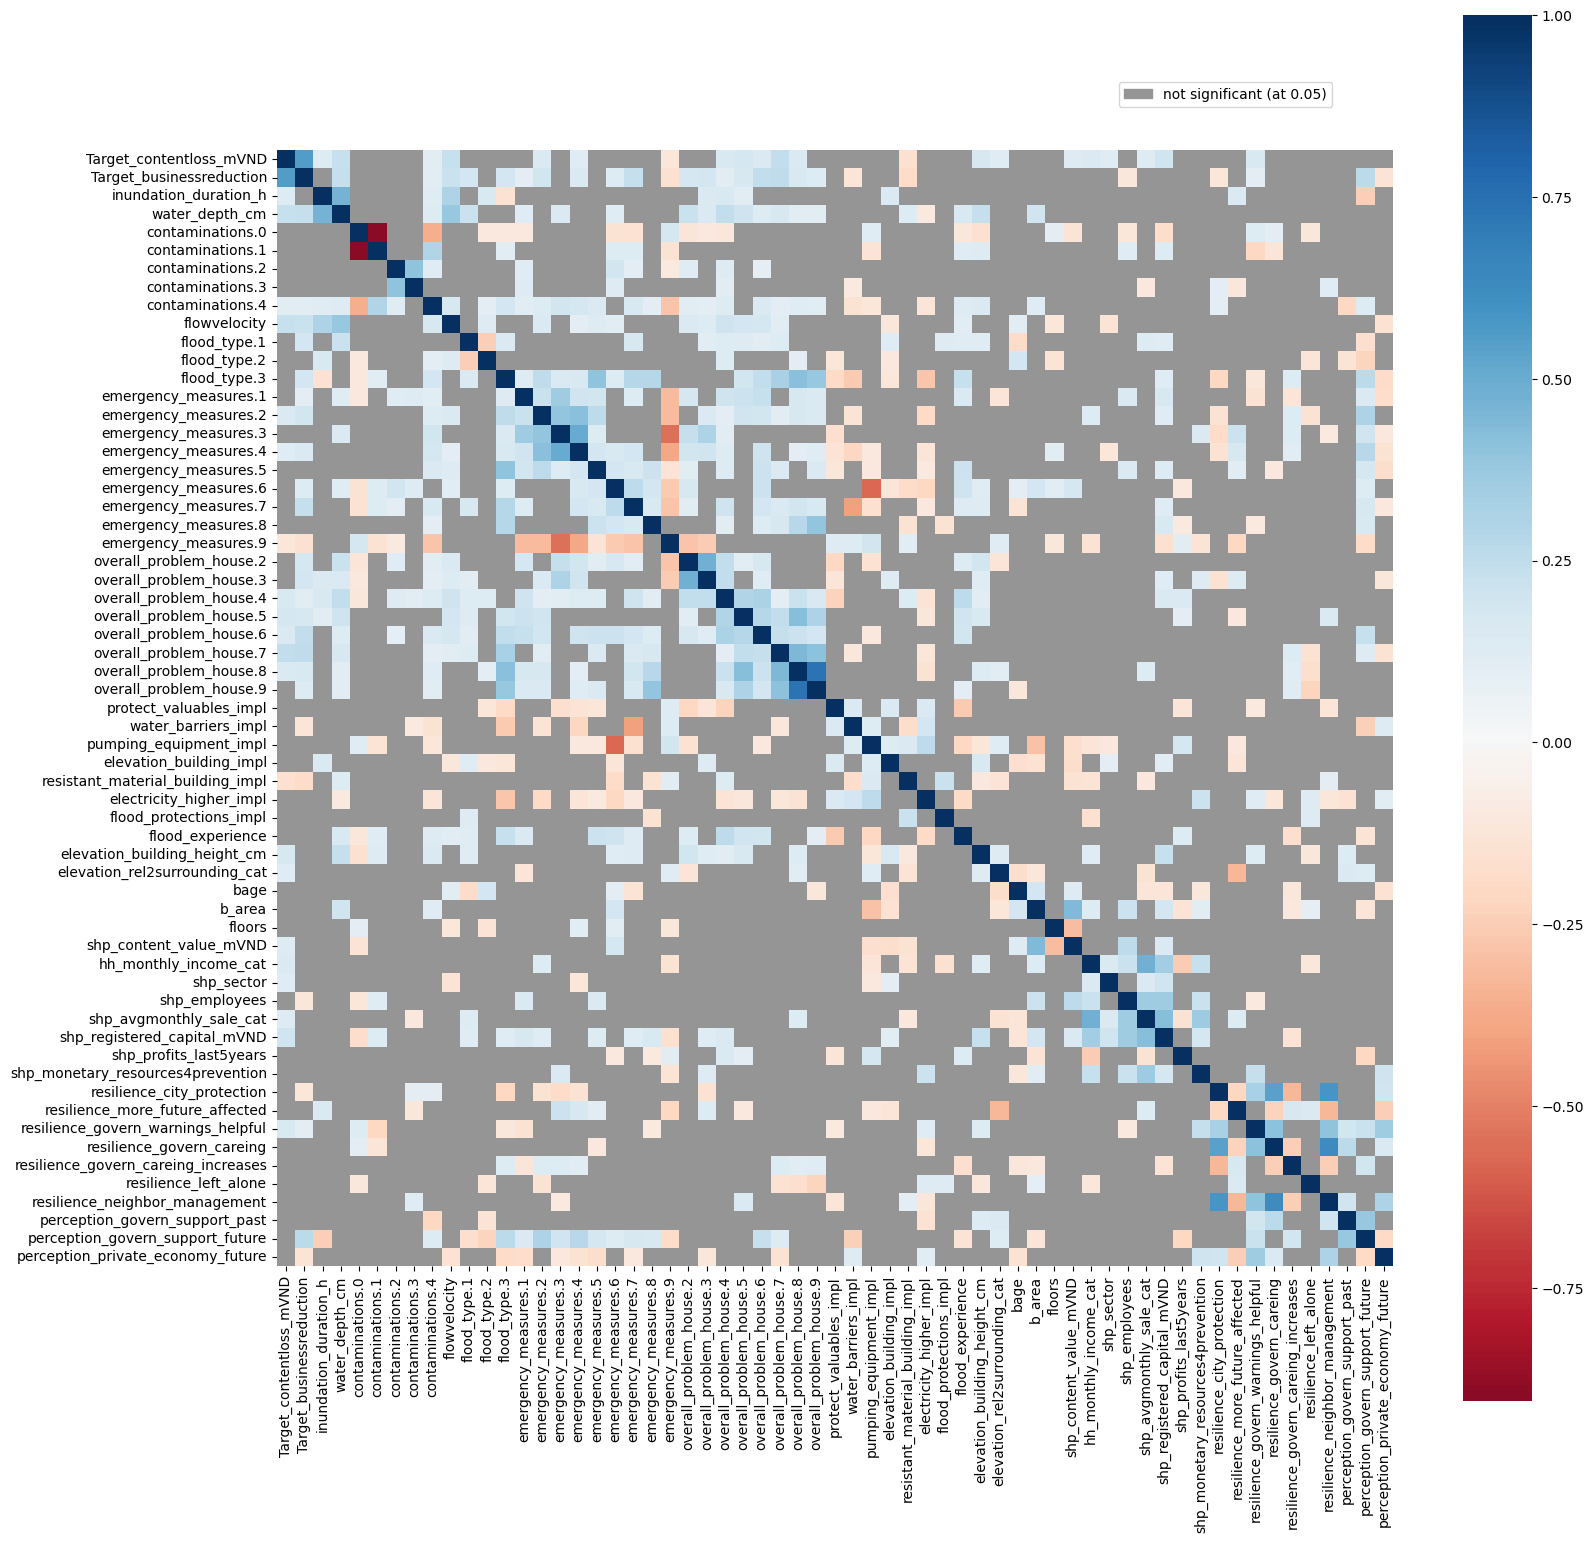

In [65]:
plt.figure(figsize=(18,18))
f.plot_spearman_rank(all_input.drop("geometry", axis=1), min_periods=50, signif=True, psig=0.05)


### Multicollinearity

- VIF >10 : high correlation with other features
- VIF <5: medium correlation

**Mulitcollinear features are only explored -> the results are implemented in chapter "Indicators"** 

In [66]:
## first reduce multicollineary in predictor set by normalization, this can be done due that the later applied ML models will uses only nomralized predictors. 
## Our goal is to have less multicollineary in our model training to have meaningfull feautre importance, therefore normalization can already applied here to deterine multicollinearity
## Normalization already reduces the avarge VIF score remarkably 

X = all_input.drop(["Target_contentloss_mVND", "Target_businessreduction", "geometry"], axis=1)
## reset index due that some samples are removed
X = X.reset_index(drop=True)

scaler = MinMaxScaler()
d = scaler.fit_transform(X)
X_scaled = pd.DataFrame(d, columns=X.columns)
X_scaled.head(5)

,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,flood_type.1,flood_type.2,flood_type.3,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.5,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house.2,overall_problem_house.3,overall_problem_house.4,overall_problem_house.5,overall_problem_house.6,overall_problem_house.7,overall_problem_house.8,overall_problem_house.9,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,floors,shp_content_value_mVND,hh_monthly_income_cat,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_registered_capital_mVND,shp_profits_last5years,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future
0,0.0030,0.0604,1.0000,0.0000,0.0000,0.0000,0.0000,0.2500,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.7500,1.0000,1.0000,1.0000,0.8000,0.2692,1.0000,0.1200,0.0132,0.2000,0.0037,0.1429,0.0779,0.0000,0.2000,0.0002,1.0000,0.0000,1.0000,0.2500,1.0000,1.0000,0.0000,0.2500,1.0000,1.0000,1.0000,0.5000
1,0.0030,0.0940,0.0000,1.0000,0.0000,0.0000,0.0000,0.2500,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.7500,1.0000,1.0000,1.0000,0.8000,0.2308,1.0000,0.0000,0.0091,0.2000,0.0037,0.2857,0.1429,0.0000,0.2000,0.0005,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.5000,0.5000,NaN
2,0.0013,0.0067,1.0000,0.0000,0.0000,0.0000,0.0000,0.2500,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.8000,0.1538,1.0000,0.2100,0.0385,0.0000,0.1594,0.4286,0.2597,0.0000,0.0000,0.0005,0.6667,0.0000,0.7500,0.0000,0.2500,0.7500,0.2500,0.7500,0.7500,0.5000,1.0000,0.5000
3,0.0047,0.0604,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.4000,NaN,1.0000,0.2000,0.0132,0.4000,0.0190,0.1429,0.0000,0.0000,0.0000,NaN,0.6667,0.0000,1.0000,0.7500,0.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000
4,0.0047,0.0268,0.0000,1.0000,0.0000,0.0000,1.0000,0.5000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.4000,0.0000,1.0000,0.2000,0.0688,0.0000,0.1594,0.2857,0.0000,0.0000,0.0000,0.0000,0.3333,0.0000,1.0000,0.5000,0.0000,1.0000,0.2500,1.0000,1.0000,1.0000,1.0000,0.0000


In [67]:
# print("Percentage of missing values per feature [%]\n", round(X_scaled.isna().mean().sort_values(ascending=False)[:20]  * 100), 2) 
pp.percentage_of_nan(X_scaled)

12-21-2023 10:32:05 - __preprocessing__ - INFO - Percentage of missing values per feature [%]
 perception_govern_support_past        38.0000
perception_govern_support_future      34.0000
elevation_building_height_cm          16.0000
shp_content_value_mVND                16.0000
resilience_govern_careing_increases   14.0000
shp_registered_capital_mVND           12.0000
bage                                   7.0000
perception_private_economy_future      7.0000
hh_monthly_income_cat                  6.0000
resilience_govern_careing              6.0000
resilience_govern_warnings_helpful     5.0000
shp_monetary_resources4prevention      5.0000
resilience_more_future_affected        4.0000
resilience_city_protection             4.0000
shp_profits_last5years                 4.0000
dtype: float64


In [68]:
df_vif = pd.DataFrame()
df_vif["X_features"] =  X_scaled.columns

## fill features with the most of missing values with median, only for VIF calculation
for feature in ["shp_registered_capital_mVND", "elevation_building_height_cm",  
                "shp_content_value_mVND", "resilience_govern_careing_increases",
                "perception_govern_support_future", "perception_govern_support_past"]:
    X_scaled[f"{feature}"] = X_scaled[f"{feature}"].replace(np.nan, np.nanmedian(X_scaled[f"{feature}"]))


X_scaled_drop_nan = X_scaled.dropna()
X_scaled_drop_nan = X_scaled_drop_nan.reset_index(drop=True)

print(X_scaled.shape)
print(X_scaled_drop_nan.shape)

df_vif = fs.vif_score(X_scaled_drop_nan)
print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )


(397, 59)
(262, 59)


12-21-2023 10:32:06 - __feature_selection__ - INFO - averaged VIF score is around: 11.3


                               names  vif_scores
0                   contaminations.1    136.0153
1             flood_protections_impl     90.0533
2   resistant_material_building_impl     47.3124
3              resilience_left_alone     45.5770
4   perception_govern_support_future     33.0829
5                   flood_experience     16.8963
6                   contaminations.0     15.9171
7              hh_monthly_income_cat     15.1361
8            overall_problem_house.2     12.7769
9     perception_govern_support_past     11.6485
10   resilience_more_future_affected     11.0175
11    resilience_neighbor_management      9.8205
12              emergency_measures.3      9.5648
13            shp_profits_last5years      9.1857
14                            floors      8.8859


In [69]:
X_scaled_drop_nan = X_scaled_drop_nan.drop([
      "shp_profits_last5years", "shp_monetary_resources4prevention",# information can be captured in e.g. precuationary measures, e.g. increased profits --> purchased more precautionry meausres
      "emergency_measures.5", # saving elderly and kids -> not important for commercial sector
      "emergency_measures.6", # pumping eq captured in Precautionary measures, 
      "emergency_measures.9", # action/no action
      #"elevation_building_height_cm",  # keep it due its small multicollinearity, still its information is included in elevation_impl 
      "elevation_rel2surrounding_cat",  # remove due that its information is covered in other elevation features
      #"geometry",
      ], axis=1
)
X_scaled_drop_nan.shape

(262, 53)

The average degree of Multicollinearity is quite high with a score of around 10.

As already seen in the previous Spearman Rank Order matrics, some features should be merged into a single indicator or alternatively should be removed from feature space if they are not important.
- contaminiations into one or two indicators 
- overall_problem_house features: merge into indicator
-  perception features: merge into indicator
-  resilience features: merge into indicator


Other strong collinear features are left unchanged .e.g precuationary measures (*_impl) in the dataset due that they seem to be important

*Merge the aforementioned feautres and check the VIF scores again*

In [70]:
X_scaled_drop_nan["contaminations"] = None
X_scaled_drop_nan["overall_problem_house"] = None
X_scaled_drop_nan["emergency_measures"] = None


# rank contamination according to their occurence and damage potential: 0:no contamination, 1:light contamination and 2:heavy contamination
## light contamination
X_scaled_drop_nan.contaminations = np.where( 
    (X_scaled_drop_nan["contaminations.1"]==1) | 
    (X_scaled_drop_nan["contaminations.4"]==1) ,
    1, 0
) 
## heavy contamination
idx_heavy_contamination = np.where(
    (X_scaled_drop_nan["contaminations.2"]==1) |
    (X_scaled_drop_nan["contaminations.3"]==1)
)
X_scaled_drop_nan.contaminations[idx_heavy_contamination[0].tolist()] = 2


## overall problem building
X_scaled_drop_nan.overall_problem_house = np.where( (X_scaled_drop_nan["overall_problem_house.2"]==1), 1, 0) 

idx = np.where(X_scaled_drop_nan["overall_problem_house.3"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 2

idx = np.where(X_scaled_drop_nan["overall_problem_house.4"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 3

idx = np.where(X_scaled_drop_nan["overall_problem_house.5"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 4

idx = np.where(X_scaled_drop_nan["overall_problem_house.6"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 5

idx = np.where(
    (X_scaled_drop_nan["overall_problem_house.7"]==1) | 
    (X_scaled_drop_nan["overall_problem_house.8"]==1) |
    (X_scaled_drop_nan["overall_problem_house.9"]==1)
)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 6


## emergency easures - merged binray feautres into on multiclass inidcator 
pattern = [r"emergency_measures.?"] 
pattern_cols = re.compile('|'.join(pattern))
df_emergency = X_scaled_drop_nan.filter(regex=pattern_cols, axis=1)
## create indicator as ratio between implemented and potentially implemented emergency measures
X_scaled_drop_nan["emergency_measures"] = df_emergency.eq(1).sum(axis=1) #/ len(df_emergency.columns)



X_scaled_drop_nan = X_scaled_drop_nan.drop([
            "contaminations.0", "contaminations.1", "contaminations.4", 
            "contaminations.2", "contaminations.3",
            "overall_problem_house.2", "overall_problem_house.3", "overall_problem_house.4",
            "overall_problem_house.5", "overall_problem_house.6", "overall_problem_house.7", "overall_problem_house.8",
            "overall_problem_house.9",
            "emergency_measures.1", "emergency_measures.2", "emergency_measures.3", "emergency_measures.4",
            "emergency_measures.7", "emergency_measures.8",
            ], axis=1)


In [71]:
df_vif = fs.vif_score(X_scaled_drop_nan)
print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )

12-21-2023 10:32:07 - __feature_selection__ - INFO - averaged VIF score is around: 9.3


                               names  vif_scores
0             flood_protections_impl     61.2850
1              resilience_left_alone     38.2981
2   resistant_material_building_impl     36.3116
3   perception_govern_support_future     28.1352
4                   flood_experience     13.9383
5              hh_monthly_income_cat     11.8100
6     perception_govern_support_past     10.0422
7    resilience_more_future_affected      9.4199
8     resilience_neighbor_management      8.1765
9                             floors      7.9008
10                    contaminations      7.8049
11                     shp_employees      7.5700
12         resilience_govern_careing      6.9202
13                emergency_measures      6.4987
14                      flood_type.1      5.9859


The again applied VIF score shows that merging contaminations, overall problem of the house and emergency measures into single indicators  reduces the average VIF score slightly under 10.

--> perception and resilience featues should be combined as inidcators or be removed 

*Be aware* : By merging feautres into indicators, information can be lost or remarkable characteristics of one feature are less expressive in a combined indicator than compared to nth single features

*Be aware* : removing features with high collinearity from the dataset changes the VIF score of the remaining feautres, so only removing feautres is not a good solution to reduce multicollinearity

- VIF >10 : high correlation with other features
- VIF <5: medium correlation


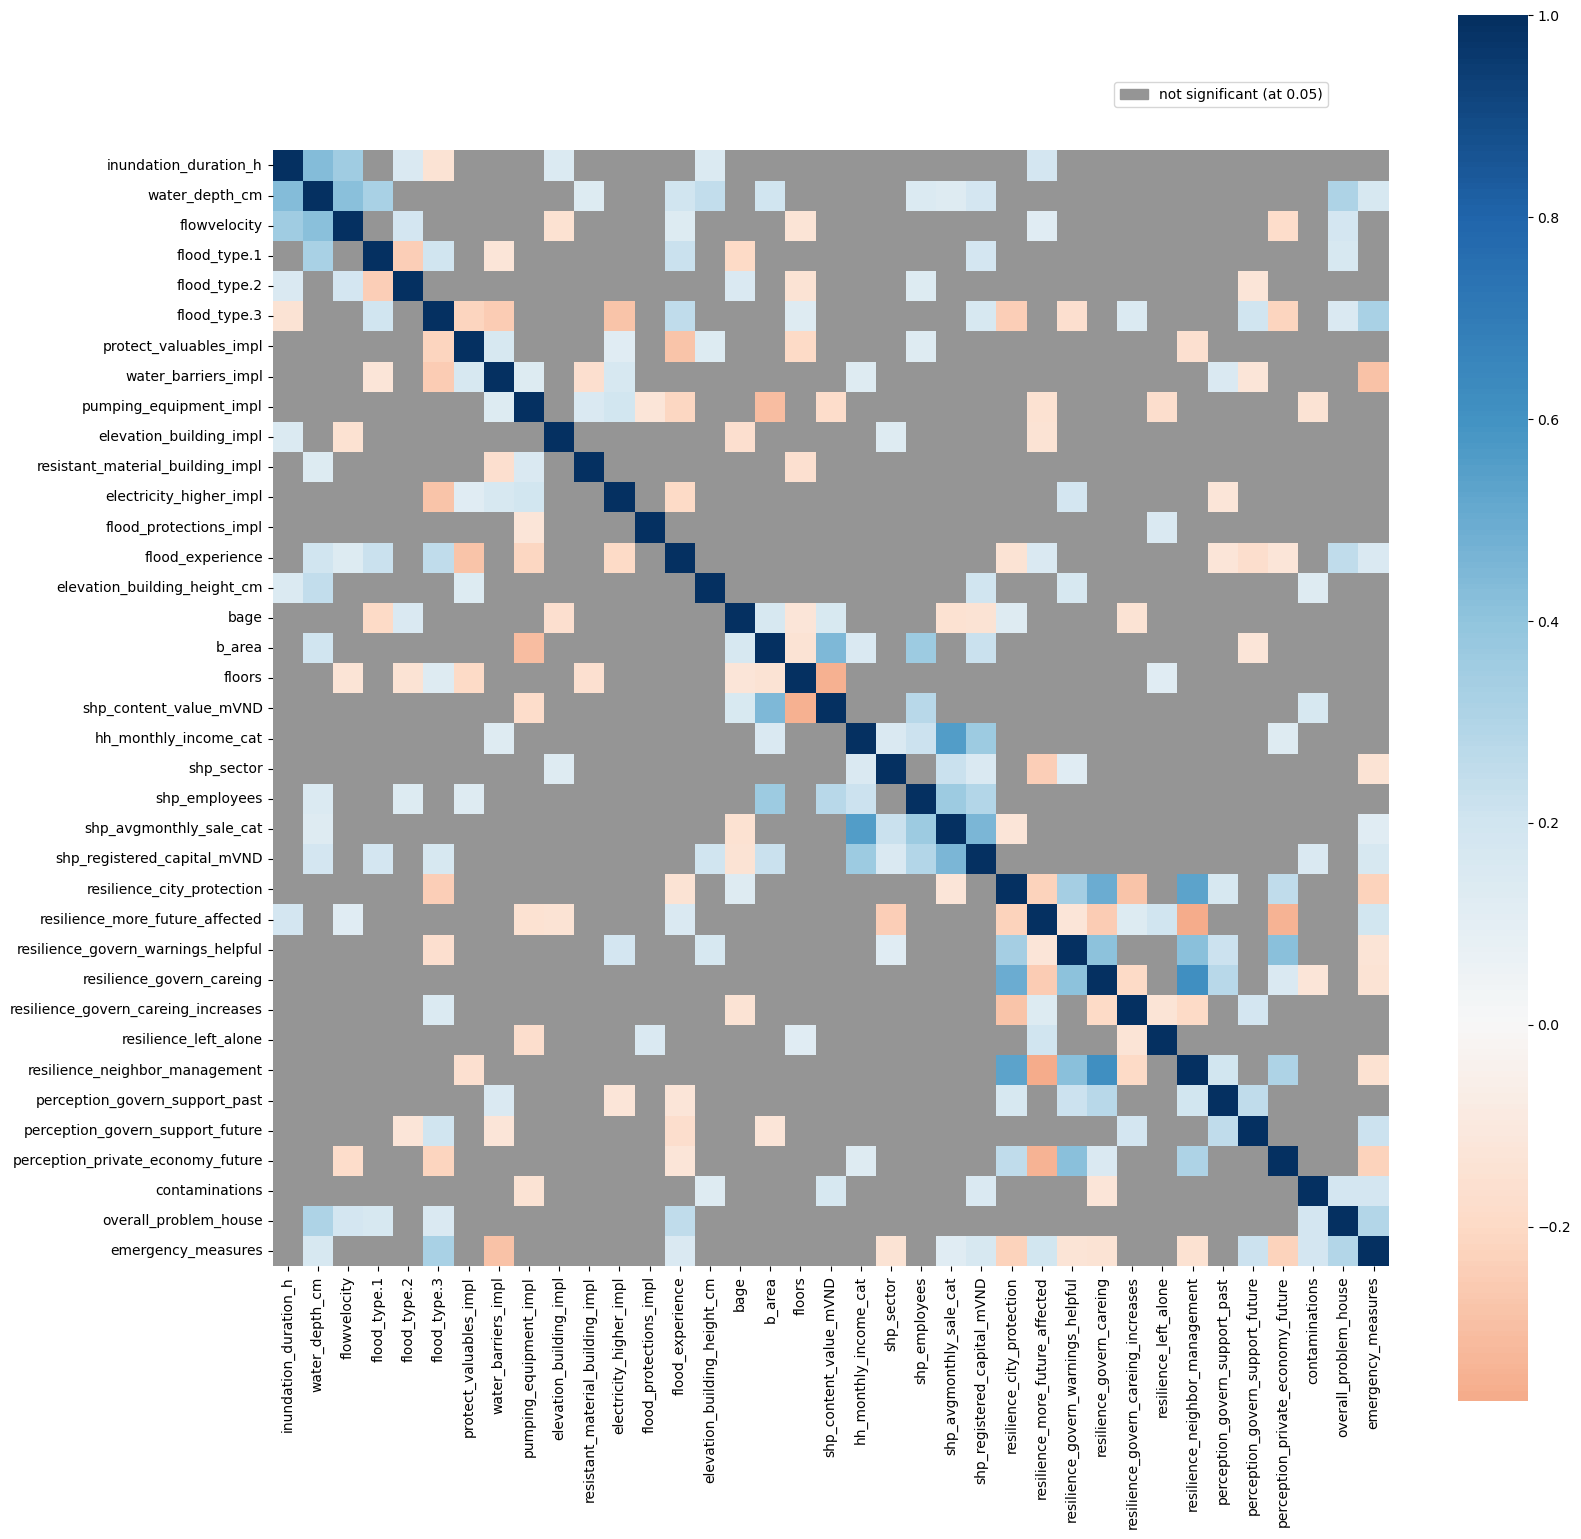

In [72]:
plt.figure(figsize=(18,18))
f.plot_spearman_rank(X_scaled_drop_nan, min_periods=50, signif=True, psig=0.05)


Correlations between the candidate predictors could be removed remarkably, espcially the strongest correlations were removed.
Still features describing shop characteristics such as number of employees, registered capital etc, show a higher multicollinearity in this subgroup. Similar subgroups with higher collinearites are the feautres for resilience and perception 

In [73]:
## drop itendtified variables
all_input = all_input.drop(
    [
     "shp_profits_last5years", "shp_monetary_resources4prevention",# information can be captured in e.g. precuationary measures, e.g. increased profits --> purchased more precautionry meausres
      "emergency_measures.5", # saving elderly and kids -> not important for commercial sector
      "emergency_measures.6", # pumping eq captured in Precautionary measures, 
      "emergency_measures.9", # action/no action
      #"elevation_building_height_cm",  # keep it due its small multicollinearity, still its information is included in elevation_impl 
      "elevation_building_height_cm", "elevation_rel2surrounding_cat",  # remove due that its information is covered in other elevation features
    ], axis=1
)

### PCA on subset of features

*Find out if perception and resilience features could be merged into indicators* 
Maybe the loadings from the PCA can give some ideas how these features could be merged

In [74]:
## define set for target and explanatory variables
df_perception_resilience = all_input[list(all_input.filter(regex=f'^resilience*|^percept*|Target_contentloss_mVND'))]  # only explanatory vars
# df_perception_resilience.columns

# df_perception_resilience.resilience_govern_careing_increases = df_perception_resilience.resilience_govern_careing_increases.replace(
#     {1:5, 2:4, 3:3, 4:2, 5:1}
# )

df_perception_resilience = df_perception_resilience.dropna()
df_perception_resilience_X = df_perception_resilience.drop("Target_contentloss_mVND", axis=1)
df_perception_resilience_Y = df_perception_resilience["Target_contentloss_mVND"]

In [75]:
pattern = [r"^resilience"] 
# pattern = [r"_impl$"] 
pattern_cols = re.compile('|'.join(pattern))
df_precautionary = all_input.filter(regex=pattern_cols, axis=1)

df_perception_resilience_X = df_precautionary
df_perception_resilience_X.tail(2)

# fill NA for PCA
# df_perception_resilience_X = df_perception_resilience_X.apply(lambda x: x.fillna(x.median()),axis=0)
df_perception_resilience_X = df_perception_resilience_X.dropna()
df_perception_resilience_X.shape

(318, 7)

In [76]:
## normalize data 
X = MinMaxScaler().fit_transform(df_perception_resilience_X)
X = pd.DataFrame(X, columns=df_perception_resilience_X.columns)
print(X.shape, X.columns)

(318, 7) Index(['resilience_city_protection', 'resilience_more_future_affected',
       'resilience_govern_warnings_helpful', 'resilience_govern_careing',
       'resilience_govern_careing_increases', 'resilience_left_alone',
       'resilience_neighbor_management'],
      dtype='object')


In [77]:
## We will start by using only the first 2 leading principal components, and then explore 3 principal components and 4 principal components.
pca = PCA(n_components=3)
# pca = PCA(n_components=2)
PC = pca.fit_transform(X)
principalDF = pd.DataFrame(data=PC, columns=['pc1','pc2', 'pc3'])
df_pca = principalDF
# df_pca = pd.concat([principalDF, df_perception_resilience_Y], axis = 1)
# df_pca.head(10)
#X.columns.tolist()
#components #=components[9:21]


#### explained variance
explained variance tells us how much information (variance) can be attributed to each of the principal components

In [78]:
# pca.explained_variance_ratio_


In [79]:
# eigenvalues, eigenvectors = np.linalg.eig(np.corrcoef(X.T))

# tot = sum(eigenvalues)
# var_exp = [(i / tot)*100 for i in sorted(eigenvalues, reverse=True)]
# cum_var_exp = np.cumsum(var_exp)
# cum_var_exp

### Loadings with varimax rotation

In [80]:
PC_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
components = df_perception_resilience_X.columns.tolist()  # use X before standarized

loadingdf = pd.DataFrame(PC_loadings, columns=('PC1','PC2', 'PC3'))
loadingdf["variable"] = components
loadingdf


,PC1,PC2,PC3,variable
0,0.2907,-0.0361,-0.0818,resilience_city_protection
1,-0.1530,-0.2436,-0.1484,resilience_more_future_affected
2,0.1758,-0.1591,0.1098,resilience_govern_warnings_helpful
3,0.2418,-0.0467,0.0110,resilience_govern_careing
4,-0.1385,-0.1018,0.2124,resilience_govern_careing_increases
5,-0.0013,-0.0157,-0.0478,resilience_left_alone
6,0.2481,-0.0066,0.0342,resilience_neighbor_management


**Varimax rotation for better interpretation of variables**
By the rotation or adjustment the variance shared among the variables should be maximized

Code snippets were taken from: https://www.kaggle.com/code/gianinamariapetrascu/pca-varimax-rotation#var

In [81]:
# fit factor analyzer with principal components and varimax rotation
fa = FactorAnalyzer(rotation="varimax", n_factors=2, method='principal')
fa.fit(X)

# get the rotated factor pattern
loadings2 = pd.DataFrame(
    fa.loadings_, 
    index=df_perception_resilience_X.columns, 
    columns=[f"Factor{i+1}" for i in range(2)]
)
rotated_factor_pattern = loadings2[abs(loadings2) >= 0.4].dropna(how='all')  # drop loadings with less explanatory power

rotated_factor_pattern

,Factor1,Factor2
resilience_city_protection,0.7322,NaN
resilience_more_future_affected,-0.5120,NaN
resilience_govern_warnings_helpful,0.6257,NaN
resilience_govern_careing,0.7776,NaN
resilience_govern_careing_increases,NaN,-0.5937
resilience_left_alone,NaN,0.8170
resilience_neighbor_management,0.8358,NaN


####  Summarize Varimax rotation
*Interpretation of factors*

By applying varimax rotation it is easier which features can be combined with each other into one indicator.
- One indicator for resilinece could be created by nearly all resilience features except "resilinece_left_alone" and eventually "resilience_govern_warnings_helpful"
- One indicator for "perception" may created with "perception_govern_support_past" and "perception_govern_support_future", but maybe this would be a quite weak variable due that similarities between both variables are weak


TODO interprete eigenvectors of first feautres -> am meiste nausagekraft== highest eigenvector?


PCA produces Linear combination of the features with the highest variance (first PCA component) and so on


### Eigenvectors and eigenvalues
Code snippets were taken from: https://www.kaggle.com/code/gianinamariapetrascu/pca-varimax-rotation#var

In [82]:
## calc Eigenvector and eigenvalues

eigenvalues, eigenvectors = np.linalg.eig(np.corrcoef(X.T))

# sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]

# convert to dataframes
eigenvalues_df = pd.DataFrame({'Eigenvalue': eigenvalues}, index=df_perception_resilience_X.columns)
eigenvalues_df['Proportion'] = eigenvalues_df['Eigenvalue'] / eigenvalues_df['Eigenvalue'].sum()
eigenvalues_df['Cumulative Proportion'] = eigenvalues_df['Proportion'].cumsum()

display(eigenvalues_df.style.format({'Eigenvalue': '{:.4f}', 'Proportion': '{:.4f}', 'Cumulative Proportion': '{:.4f}'}))

,Eigenvalue,Proportion,Cumulative Proportion
resilience_city_protection,2.7319,0.3903,0.3903
resilience_more_future_affected,1.1172,0.1596,0.5499
resilience_govern_warnings_helpful,1.0093,0.1442,0.6941
resilience_govern_careing,0.7617,0.1088,0.8029
resilience_govern_careing_increases,0.5175,0.0739,0.8768
resilience_left_alone,0.4877,0.0697,0.9465
resilience_neighbor_management,0.3747,0.0535,1.0000


#### Summarize eigenvalues:
- around 33.8% of the variance in the direct damage costs for business contents can be explained by flood variables (water depth, inundation time and contamination), but the small proportions generated by each new eigenvalue shos that creating a loss function for damage cost for contents is based on a larger set of predictors.


#### Donwsides of PCA:
- PCA only considers linear relationships and PCA as well as SVD-based methods or univariate screening methods (t-test, correlation, etc.), dont account the potential multivariate nature of the data structure (e.g., higher order interaction between variables) - tree based methods are better to account these multivariabilty. Furthermore the measurements from all of the original variables are used in the projection to the lower dimensional space, 


## Indicators and transform categorical variables
Based on the above findings from VIF and spearman correlation plot certain features from the original feature space will be merged into indicators:

The later applied Bayesian Network uses continous variables, therfore categorical variables are transformed to continous scales if possible.
Ordered categories can be easily transformed when they are in quantitative values, while binary or qualitative variables can not be used in the Bayesian Network


#### Variables to modify:

binary vars: --> remove or modify
- contaminaitions : modify to indicator

categ vars:
- DONE flowvelocity : m/sec -> paper paprotny 2021 for residential loss
- DONE flood exp: convert to mean of range - 
- DONE shp_avgmonthly_sale_cat
- DONE hh_monthly_income_cat
- DONE sectors remove due that qualitative
- DONE merge emergyency measures : paprotny indicator
- DONE merge precautionary ()impl
- DONE shp_supplier location - ranked by location (only for business reduction)
- DONE merge resilience
- DONE merge perception
- DONE overall_problem_house --> test as multiclass variable




In [83]:
all_input.flowvelocity.value_counts()

flowvelocity
2    118
3     94
4     73
5     70
1     42
Name: count, dtype: int64

In [84]:
## flow velocity: categories 1:calm - 5:torrential
## Paprotny 2021:  As for flow velocity, the respondents assessed i based on a qualitative scale, 
# providing a value from 1 to 6, with half-points possible (Thieken et al. 2005). 
# A value of 0.1 m/s was assigned to each full step of this qualitative scale. 

# sns.scatterplot(
#     data=all_input, 
#     x="flowvelocity", 
#     #x="water_depth_cm", 
#     y=target, 
#     #hue="size", #style="time"
# )

all_input.flowvelocity.describe()

all_input.flowvelocity = all_input.flowvelocity.replace(
    {
        1:0.1, 
        2:0.2, 
        3:0.3, 
        4:0.4, 
        5:0.5
    }
)


In [85]:
## flood experience: mean of ranges
all_input.flood_experience.describe()

all_input.flood_experience = all_input.flood_experience.replace(
    {
      1:3,     # less than once a year , freq: 1
      2:8,     # about once a year, freq: 14
      3:16,      # twice a year, freq: 37
      4:36,      # 4 times a year, freq: 58
      5:76,      # 8 times a year, freq: 98
      6:151     # 15 times a year - used range 100-200, freq: 112 (more than 10 times a year, 100 times since 2010)
    }
)
all_input.flood_experience.value_counts()

flood_experience
151    133
76     109
36      88
16      42
8       18
3        7
Name: count, dtype: int64

In [86]:
all_input.flood_experience

0       76
1       76
2       76
3       16
4       16
      ... 
392    151
393    151
394    151
395     76
396     36
Name: flood_experience, Length: 397, dtype: int64

In [87]:
## avg monthly sale (million VND/month)
all_input.shp_avgmonthly_sale_cat.value_counts()

all_input["shp_avgmonthly_sale_mVND"] = None
all_input["shp_avgmonthly_sale_mVND"] = all_input.shp_avgmonthly_sale_cat.replace(
    {
      1:2.5,     # < 5m , freq: 126
      2:7.5,     # 5m – 10m , freq: 129
      3:20,      # 10m – 30m , freq: 54
      4:40,      # 30m – 50m , freq: 7
      5:75,      # 50m – 100m , freq: 8
    }
)

In [88]:
## avg monthly income
#print(all_input.hh_monthly_income_cat.value_counts())

all_input["hh_monthly_income_mVND"] = None
all_input.hh_monthly_income_mVND = all_input.hh_monthly_income_cat.replace(
    {
      1:0,     # < 1m , freq: 4
      2:3,     # 1m – 5m , freq: 68
      3:8,     # 5m – 10m , freq: 153
      4:15,    # 10m – 20m , freq: 111
      5:25,    # 20m – 30m , freq: 26
      6:40,    # 30m – 50m , freq: 4
      7:65,    # 50m – 80m , freq: 4
      8:90,    # 80m – 100m , freq: 3
    }
)

all_input.drop(["hh_monthly_income_cat", "shp_avgmonthly_sale_cat"], axis=1, inplace=True)

#### Indicators
indictator for severla multiple choice answers e..g emergency and precautionary measures

as a ratio between b measures implemented prior to the flood (nI) divided by the nb measures potentailly could have implemented (nP)
(https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020WR027649)

\
\
Maybe for socio-economic status indicator:

according to Plapp 2003, applied by Thieken et al 2005
indicator of warning information, indicator of emergency measures, perception of efficiency of private precaution, building quality, building/content value

In [89]:
df = all_input
df.columns

df = df.reset_index(drop=True)

In [90]:
## combine business sectors into two or three main casses to see if they are importnat for rloss quantification
df.shp_sector.value_counts()

df["shp_sector"] = df["shp_sector"].replace(
    {
        11.0 : 1,     # 1. Shop/Retailer
        12.0 : 1, 
        13.0 : 1, 
        14.0 : 1, 
        15.0 : 1, 
        16.0 : 1, 
        17.0 : 1, 
        11.0 : 1, 
        11.0 : 1, 
        11.0 : 1, 
        21.0 : 2,     # 2. Services 
        22.0 : 2, 
        23.0 : 2, 
        24.0 : 2,
        31.0 : 3,     # 3. Production
        32.0 : 3, 
        33.0 : 3, 
        34.0 : 3, 
        35.0 : 3, 
        88.0 : np.nan,
    }
)
df.shp_sector.value_counts()

shp_sector
1.0000    289
2.0000     65
3.0000     26
Name: count, dtype: int64

In [91]:
## emergency measures as indicator : range: 0:no measures - 6: applied all measures 

pattern = [r"emergency_measures.?"] 
pattern_cols = re.compile('|'.join(pattern))
df_emergency = df.filter(regex=pattern_cols, axis=1)

## create indicator as ratio between implemented and potentially implemented emergency measures
df["emergency_measures"] = None
df["emergency_measures"] = df_emergency.eq(1).sum(axis=1) / len(df_emergency.columns)

# keep only indicator in final df
df.drop(
    df_emergency.filter(
        regex=r"^(?:.+\d)$"
        ).columns, 
    axis=1, inplace=True
)

In [92]:
# ## precautionary measures as indicator
# ## --> test first as seperate feautres to keep as much information as possible

pattern = [r"_impl$"] 
pattern_cols = re.compile('|'.join(pattern))
df_precautionary = df.filter(regex=pattern_cols, axis=1)

# ## create ratio: 
# ## -> precaution inidcator. 5:0 - not impl, 4:1 - after both,  2:2- after event but before recent, 1:3- before event
# # Precuationary measures: 
# # 1: impl before event, 
# # 2: impl after serious event but before recent event, TODO check for recent/serious cases: probably occurs only for rencet cases --> than count as 1
# # 4: impl after event
# # 5: didnt impl

df_precautionary = df_precautionary.replace(
    {
        1:1,    # impl before 
        2:0,    # impl after event but before recent 
        4:0,    # impl after 
        5:0     # not at all  
    }
)
# ## devide into expensive and low cost precautionary measures due that expensive meausres seems to be better in flood-loss-reduction
df_precautionary_expensive = df_precautionary[["elevation_building_impl", "resistant_material_building_impl", "flood_protections_impl"]]
df_precautionary_low = df_precautionary.drop(["elevation_building_impl", "resistant_material_building_impl", "flood_protections_impl"], axis=1)



# create indicator as ratio between implemented and potentially implemented measures (in total 7 measures exist)
# range: 0.0: no measure wa implemented before the flood event - 1.0: all potential measures were implemented before the reported flood
# --> splitting in low and expensive precaution measures reduces the importance of the feautres for the models remarkable
df["precautionary_measures_lowcost"] = None
df["precautionary_measures_lowcost"] = df_precautionary_low.sum(axis=1) / len(df_precautionary_low.columns)
df["precautionary_measures_expensive"] = None
df["precautionary_measures_expensive"] = df_precautionary_expensive.sum(axis=1) / len(df_precautionary_expensive.columns)

## df["precautionary_measures"] = df_precautionary.sum(axis=1) / len(df_precautionary.columns)


## keep only indicator in final df
df.drop(
    df_precautionary.columns, 
    axis=1, inplace=True
)
print(df.columns)


Index(['Target_contentloss_mVND', 'Target_businessreduction',
       'inundation_duration_h', 'water_depth_cm', 'contaminations.0',
       'contaminations.1', 'contaminations.2', 'contaminations.3',
       'contaminations.4', 'flowvelocity', 'flood_type.1', 'flood_type.2',
       'flood_type.3', 'overall_problem_house.2', 'overall_problem_house.3',
       'overall_problem_house.4', 'overall_problem_house.5',
       'overall_problem_house.6', 'overall_problem_house.7',
       'overall_problem_house.8', 'overall_problem_house.9',
       'flood_experience', 'bage', 'b_area', 'geometry', 'floors',
       'shp_content_value_mVND', 'shp_sector', 'shp_employees',
       'shp_registered_capital_mVND', 'resilience_city_protection',
       'resilience_more_future_affected', 'resilience_govern_warnings_helpful',
       'resilience_govern_careing', 'resilience_govern_careing_increases',
       'resilience_left_alone', 'resilience_neighbor_management',
       'perception_govern_support_past', 'perc

In [93]:
## resilience as indicator:

## 1 : strong disagree - 5 : strong agree
## currently would leave at it is and see if its included in final Feature space
## TEST: as merged indcator and as seperate features
## o	Orderer rank okay as long its  quantitative

## select based on findings from PCA
df_resilience = df[["resilience_city_protection", "resilience_govern_careing","resilience_neighbor_management"]]
## negatives loadings: resilience_govern_careing_increases
print(df_resilience.columns)

df["resilience"] = None
df["resilience"] = df_resilience.sum(axis=1) / len(df_resilience.columns)

# ## rather pessimistic resilience variables
# df_resilience_leftalone = df[["resilience_left_alone", "resilience_more_future_affected"]]
# print(df_resilience_leftalone.columns)

# df["resilienceLeftAlone"] = None
# df["resilienceLeftAlone"] = df_resilience_leftalone.sum(axis=1) / len(df_resilience_leftalone.columns)

## --> potentiall resilinece_leftalone correlates positvely with target variables, 
## --> while the other resilience indicator may corellates negatively with the targets 

## keep only indicator in final df
df.drop(
    df.filter(like="resilience_").columns,
    axis=1, inplace=True
)
print(df.columns)
# ## 1: disagree, 5: agree


Index(['resilience_city_protection', 'resilience_govern_careing',
       'resilience_neighbor_management'],
      dtype='object')
Index(['Target_contentloss_mVND', 'Target_businessreduction',
       'inundation_duration_h', 'water_depth_cm', 'contaminations.0',
       'contaminations.1', 'contaminations.2', 'contaminations.3',
       'contaminations.4', 'flowvelocity', 'flood_type.1', 'flood_type.2',
       'flood_type.3', 'overall_problem_house.2', 'overall_problem_house.3',
       'overall_problem_house.4', 'overall_problem_house.5',
       'overall_problem_house.6', 'overall_problem_house.7',
       'overall_problem_house.8', 'overall_problem_house.9',
       'flood_experience', 'bage', 'b_area', 'geometry', 'floors',
       'shp_content_value_mVND', 'shp_sector', 'shp_employees',
       'shp_registered_capital_mVND', 'perception_govern_support_past',
       'perception_govern_support_future', 'perception_private_economy_future',
       'geometry', 'shp_avgmonthly_sale_mVND', 'hh_mo

In [94]:
df[["Target_contentloss_mVND", "Target_businessreduction", "resilience"]].corr(method="spearman")


,Target_contentloss_mVND,Target_businessreduction,resilience
Target_contentloss_mVND,1.0000,0.5556,0.1002
Target_businessreduction,0.5556,1.0000,0.0241
resilience,0.1002,0.0241,1.0000


In [95]:
## perception as indicator
## o	Orderer rank okay as long its  quantitative

# Reduced /Porrer  -> 1
# Maintained /Same  -> 2
# Increased /Richer -> 3


# ## based on findings from PCA
# df_perception = df[["perception_govern_support_past", "perception_govern_support_future"]]
# print(df_perception.columns)

# df["perception"] = None
# df["perception"] = df_perception.sum(axis=1) / len(df_perception.columns)

## keep only indicator in final df
df.drop(
    df.filter(like="perception_").columns, 
    axis=1, inplace=True
)


In [96]:
## contaminations
## rank contamination according to their occurence and damage potential: 0:no contamination, 1:light contamination and 2:heavy contamination

df["contaminations"] = None
df_contaminations = df.filter(like="contaminations", axis=1)


## light contamination
df.contaminations = np.where( 
    (df_contaminations["contaminations.1"]==1) | 
    (df_contaminations["contaminations.4"]==1) ,
    1, 0
) 
## heavy contamination
idx_heavy_contamination = np.where(
    (df_contaminations["contaminations.2"]==1) |
    (df_contaminations["contaminations.3"]==1)
)
df.contaminations[idx_heavy_contamination[0].tolist()] = 2


## keep only indicator in final df
df.drop(
    df_contaminations.filter(like="contaminations.").columns, 
    axis=1, inplace=True
)
#print(df.columns)

In [97]:
## overall_problem_house

# 0 if no damage occured, (# 1 if building was damaged )
# 2.	moisture penetration of walls and ceilings              freq: 207
# 3.	mold and contamination;                                 freq: 175
# 4.	small cracks in walls, doors, windows                   freq: 86
# 5.	larger cracks in walls, doors, windows                  freq: 31
# 6.	subsidence of the building                              freq: 76
# 7.	replacement of building components necessary            freq: 19
# 8.	collapse of load-bearing walls, replacement necessary   freq: 6
# 9.	collapse of large building parts, demolition necessary  freq: 3

# --> test overall_problem_house as multiclass 
df["overall_problem_house"] = None

pattern = [r"overall_problem_house.*(?<!1)$"] # get all columns but not overall_problem_house_r.1: no problem/ problem 
pattern_cols = re.compile('|'.join(pattern))
df_problem_house = df.filter(regex=pattern_cols, axis=1)

## create indicator
df.overall_problem_house = np.where( (df_problem_house["overall_problem_house.2"]==1), 1, 0) 

idx = np.where(df_problem_house["overall_problem_house.3"]==1)
df.overall_problem_house[idx[0].tolist()] = 2

idx = np.where(df_problem_house["overall_problem_house.4"]==1)
df.overall_problem_house[idx[0].tolist()] = 3

idx = np.where(df_problem_house["overall_problem_house.5"]==1)
df.overall_problem_house[idx[0].tolist()] = 4

idx = np.where(df_problem_house["overall_problem_house.6"]==1)
df.overall_problem_house[idx[0].tolist()] = 5

idx = np.where(
    (df_problem_house["overall_problem_house.7"]==1) | 
    (df_problem_house["overall_problem_house.8"]==1) |
    (df_problem_house["overall_problem_house.9"]==1)
)
df.overall_problem_house[idx[0].tolist()] = 6



## keep only indicator in final df
df.drop(
    df_problem_house.filter(like="overall_problem_house.").columns, 
    axis=1, inplace=True
)
print(df.columns)


Index(['Target_contentloss_mVND', 'Target_businessreduction',
       'inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'flood_type.1', 'flood_type.2', 'flood_type.3', 'flood_experience',
       'bage', 'b_area', 'geometry', 'floors', 'shp_content_value_mVND',
       'shp_sector', 'shp_employees', 'shp_registered_capital_mVND',
       'geometry', 'shp_avgmonthly_sale_mVND', 'hh_monthly_income_mVND',
       'emergency_measures', 'precautionary_measures_lowcost',
       'precautionary_measures_expensive', 'resilience', 'contaminations',
       'overall_problem_house'],
      dtype='object')


In [98]:
df[["precautionary_measures_lowcost", "precautionary_measures_expensive"]].describe()

,precautionary_measures_lowcost,precautionary_measures_expensive
count,397.0000,397.0000
mean,0.3621,0.1537
std,0.2909,0.1915
min,0.0000,0.0000
25%,0.2500,0.0000
50%,0.2500,0.0000
75%,0.5000,0.3333
max,1.0000,1.0000


In [99]:
print(df.columns)
all_input = df

Index(['Target_contentloss_mVND', 'Target_businessreduction',
       'inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'flood_type.1', 'flood_type.2', 'flood_type.3', 'flood_experience',
       'bage', 'b_area', 'geometry', 'floors', 'shp_content_value_mVND',
       'shp_sector', 'shp_employees', 'shp_registered_capital_mVND',
       'geometry', 'shp_avgmonthly_sale_mVND', 'hh_monthly_income_mVND',
       'emergency_measures', 'precautionary_measures_lowcost',
       'precautionary_measures_expensive', 'resilience', 'contaminations',
       'overall_problem_house'],
      dtype='object')


#### variance of features after Feature Reduction
Remove features with zero or near zero variance or merge them into indicators

##### Drop of further variables whose information is captured in other variables

In [100]:

# ## keep only indicator in final df
# all_input.drop(
#     ["overall_problem_house", "shp_registered_capital_mVND"],
#     axis=1, inplace=True
# )


In [101]:
X_scaled = MinMaxScaler().fit_transform(
    all_input.drop(
        ["Target_contentloss_mVND", "Target_businessreduction", "geometry"], 
        axis=1
    )
)
X_scaled = pd.DataFrame(
    X_scaled,
    columns=all_input.drop(["Target_contentloss_mVND", "Target_businessreduction", "geometry"], axis=1).columns
)


df_variance = X_scaled.var()
df_variance = np.round(df_variance, 5)
#print(pd.DataFrame({"variance":df_variance}).sort_values("variance").head(25))

var = []
for i in range(0, len(df_variance)):
    if df_variance[i] != 0.00000:
            var.append(X_scaled.columns[i])
print(var)
#df_variance = pd.DataFrame({"variance":df_variance}).sort_values("variance")

['inundation_duration_h', 'water_depth_cm', 'flowvelocity', 'flood_type.1', 'flood_type.2', 'flood_type.3', 'flood_experience', 'bage', 'b_area', 'floors', 'shp_content_value_mVND', 'shp_sector', 'shp_employees', 'shp_registered_capital_mVND', 'shp_avgmonthly_sale_mVND', 'hh_monthly_income_mVND', 'emergency_measures', 'precautionary_measures_lowcost', 'precautionary_measures_expensive', 'resilience', 'contaminations', 'overall_problem_house']


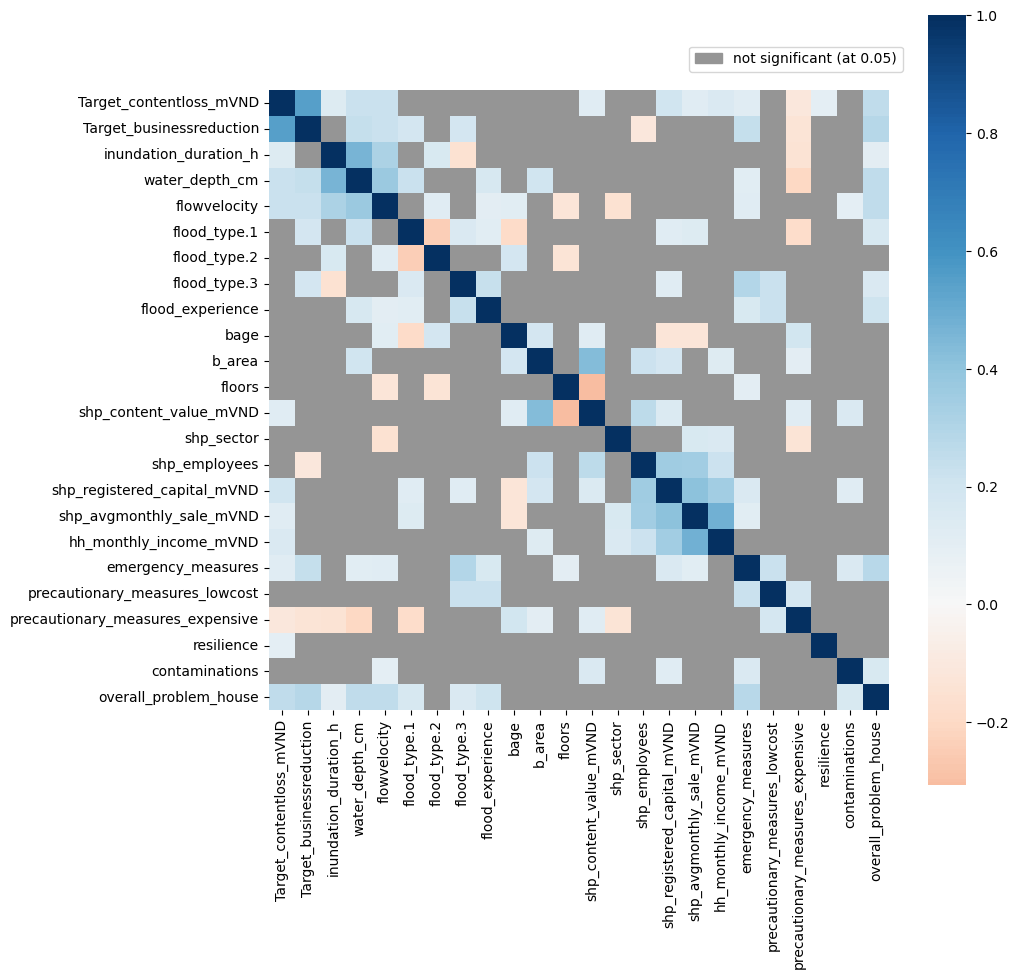

In [102]:
plt.figure(figsize=(10,10))
f.plot_spearman_rank(all_input.drop("geometry", axis=1), min_periods=50, signif=True, psig=0.05)

## Unify monetary values

In [103]:
# ## check for very small registered capital
# vars_money = all_input.filter(regex="_mVND", axis=1)
# try:
#     vars_money[vars_money.shp_registered_capital_mVND <=1.0]  # less than 40 euros
# except:
#     pass

*list of all monetary vars*

- b_value_mVND	- price level for 2020 (year when survey was done)
- shp_building_value_mVND	- price level for 2020
- shp_content_value_mVND	- price level for 2020
- Target_contentloss_mVND	- price levels based on flood time
- shp_registered_capital_mVND  - price level for 2020
- hh_monthly_income_mVND     - continous [value ranges in mVND], # price level for 2020
- shp_avgmonthly_sale_mVND   - continous [value ranges in mVND], # price level for 2020

All other vars are inflation corrected based on flood time or when survey was done 
cpi_2020 = 168.8    ,  2020 = year when the survey was done



In [104]:
## check for very small registered capital
vars_money = all_input.filter(regex="_mVND", axis=1)


## covnert all columns with million VND --> VND

vars_money = np.where( (vars_money.values != np.nan),
            vars_money.values * 1000000, # convert to VND
            vars_money.values)

## rename columns
new_cols = all_input.filter(regex="_mVND", axis=1).columns.str.replace("_mVND", "_VND")
vars_money = pd.DataFrame(vars_money, columns=new_cols)


*Conversion of VND to euro (or US$)*

Based on JRC, p.8 and Paprotny2018, eg.p245
The reported damage values have been converted to Euro using the the exchange rate for the year 2020 (mean annual value)

*Source:* 
- www.oanda.com/currency/historical-rates
-  www.ecb.europa.eu/stats/exchange/eurofxref/html/eurofxref-graph-idr.en.html


In [105]:
gdp_price_index_year_of_issue = {
    2011: 121.26,
    2012: 134.51,
    2013: 140.91,
    2014: 146.07,
    2015: 145.80,
    2016: 147.41,
    2017: 153.44,
    2018: 158.65,
    2019: 161.49,
    2020: 163.58
}
# GDP deflator source : https://jp.tradingeconomics.com/vietnam/gdp-deflator

# CPI
# price_index_year_of_issue = {
#     2011: 121.41,
#     2012: 132.44,
#     2013: 137.78,
#     2014: 142.88,
#     2015: 140.43,
#     2016: 142.98,
#     2017: 149.22,
#     2018: 154.63,
#     2019: 158.38,
#     2020: 160.70
# }

gdp_price_index_2020 = 160.70
gdp_price_index_year = data_ip2["flood_year"].astype("Int64").map(gdp_price_index_year_of_issue)  # series of cpi for each year of flood event

exchange_rate = 1 / 27155  #  dong-> euro in 2020 
## (based on eurostat: https://ec.europa.eu/eurostat/databrowser/view/ERT_BIL_EUR_A/default/line?lang=en )

*Inflation correction via GDP-deflator*


\begin{equation}
\begin{align*}

&uninflated_{2020} = losses_y * exchangerate_{2020} \\
&inflationrate = uninflated_{2020} * pindex_{2020} / pindex_y\\

\end{align*}
\end{equation}

where:
- losses_y : losses in VND for year y
- uninflated_{2020} : uninflated losses in euro for 2020
- exchangerate_{2020} : exchang erate for VND to euro in year 20202 
- pindex_{2020} : price index from GDP-deflator for 2020 
- pindex_y : price index from GDP-deflator in year y

Given that inflation is the percentage change in the overall price of an item in an economy, we can use the GDP deflator to calculate the inflation rate since its a measure of the price level.


*Further sources*
Paprotny 2018: also used country-level GDP deflators for adjusting nomnal to real losses in 2011 prices , p153, p244
Sairam et al. 2020


In [106]:
#vars_money[c].apply(pd.to_numeric)#.isna()


In [107]:
## GDP-deflator

vars_money["Target_contentloss_VND_gdp"] = None

##  only direct losses needs inflation correction in respect to flood time
for r in range(len(vars_money.Target_contentloss_VND)):
    ## exchange rate: convert VND in certain year to € in the same year
    uninflated_losses = (vars_money.Target_contentloss_VND[r] * exchange_rate) # get uninflated losses in euros for year 2020
    ## price index from GDP-deflator
    vars_money["Target_contentloss_VND_gdp"][r] = round(uninflated_losses * gdp_price_index_2020 / gdp_price_index_year[r], 1)



# ##  for all other monetary continous vars: only need exchange conversion
for c in vars_money.drop(["Target_contentloss_VND_gdp","Target_contentloss_VND"], axis=1).columns:
    vars_money[c] = vars_money[c].apply(pd.to_numeric)
    for r in range(len(vars_money[c])):
        ## convert VND_2020 to €_2020
        vars_money[c][r] = round((vars_money[c][r] * exchange_rate), 1)#.astype(int)


## rename columns
new_cols = vars_money.filter(regex="_VND", axis=1).columns.str.replace("_VND", "_euro")
vars_money.columns = new_cols



In [7]:
price_index_2020

NameError: name 'price_index_2020' is not defined

In [109]:
vars_money.Target_contentloss_euro_gdp = vars_money.Target_contentloss_euro_gdp.apply(pd.to_numeric)

In [110]:
# update all_input with unified and inflated currencies
all_input.drop(all_input.filter(regex="_mVND", axis=1).columns, axis=1, inplace=True) 
all_input = pd.concat([all_input, vars_money], axis=1)
all_input.drop("Target_contentloss_euro", axis=1, inplace=True)
all_input.rename(columns={"Target_contentloss_euro_gdp" : "Target_contentloss_euro"}, inplace=True)

all_input.filter(regex="euro", axis=1).columns


Index(['shp_content_value_euro', 'shp_registered_capital_euro',
       'shp_avgmonthly_sale_euro', 'hh_monthly_income_euro',
       'Target_contentloss_euro'],
      dtype='object')

Test if inundation duration of 600 hours is a spellign mistake or reasonable

In [111]:
all_input.loc[all_input.inundation_duration_h > 300, :]  ## 600h == ~13 days of inundation

,Target_businessreduction,inundation_duration_h,water_depth_cm,flowvelocity,flood_type.1,flood_type.2,flood_type.3,flood_experience,bage,b_area,geometry,floors,shp_sector,shp_employees,geometry,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,resilience,contaminations,overall_problem_house,shp_content_value_euro,shp_registered_capital_euro,shp_avgmonthly_sale_euro,hh_monthly_income_euro,Target_contentloss_euro
87,10.0000,600.0000,30.0000,0.4000,1,1,0,151,19.0000,74.0000,POINT (106.60294310311936 10.724599863394026),2,1.0000,2,POINT (106.60294 10.72460),0.3333,0.2500,0.0000,1.3333,1,5,4603.2000,2946.1000,276.2000,552.4000,267.9000


In [112]:
all_input.shp_content_value_euro.describe() * 2

count      670.0000
mean      9087.2400
std       9782.1120
min        515.6000
25%       3682.6000
50%       6849.6000
75%       9206.4000
max     101270.4000
Name: shp_content_value_euro, dtype: float64

## Relative Content loss
Content loss dataset: create new Target for relative content loss
Derive relative content loss as a ratio between the absoulte loss and the estimated content value of each business

In [113]:
## get corr beween CV derived from fixed floor number or DLR based floor number
# Pearson corr: with DLR floor number : 0.76	, fixed floor number  : 0.67
# slightly higher spearman corr for Cv based on fixed number of floors (0.11) vs DLR floors (0.06)

#all_input_contentloss[["Target_contentloss_euro", "shp_content_value_euro"]].corr(method="pearson")
all_input[["Target_contentloss_euro", "shp_content_value_euro"]].corr(method="spearman")
## --> huge difference between person and speamrn corr: due to skewed data or outliers, and that outliers are leading Pearso

,Target_contentloss_euro,shp_content_value_euro
Target_contentloss_euro,1.0000,0.1028
shp_content_value_euro,0.1028,1.0000


(0.0, 1000.0)

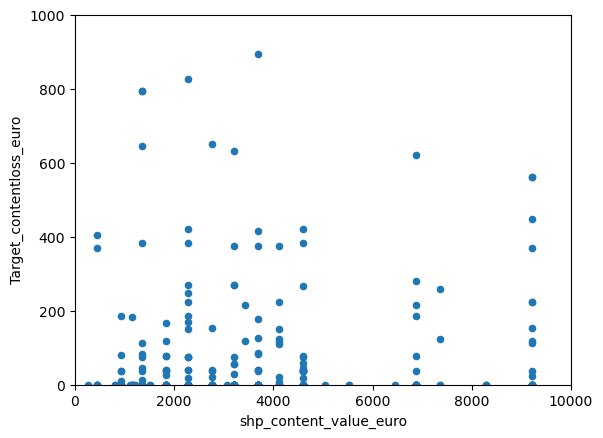

In [114]:
all_input.plot.scatter("shp_content_value_euro", "Target_contentloss_euro")
plt.xlim(0, 10000)
plt.ylim(0, 1000)


In [115]:
all_input[all_input.shp_employees> 9]

,Target_businessreduction,inundation_duration_h,water_depth_cm,flowvelocity,flood_type.1,flood_type.2,flood_type.3,flood_experience,bage,b_area,geometry,floors,shp_sector,shp_employees,geometry,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,resilience,contaminations,overall_problem_house,shp_content_value_euro,shp_registered_capital_euro,shp_avgmonthly_sale_euro,hh_monthly_income_euro,Target_contentloss_euro
97,NaN,168.0000,8.0000,0.2000,1,1,0,36,0.0000,80.0000,POINT EMPTY,2,3.0000,10,POINT EMPTY,0.0000,0.2500,0.0000,2.6667,1,6,13809.6000,1841.3000,736.5000,NaN,373.7000
151,100.0000,70.0000,100.0000,0.5000,1,0,0,76,14.0000,1000.0000,POINT EMPTY,2,NaN,34,POINT EMPTY,0.0000,0.5000,0.0000,3.6667,1,6,50635.2000,699687.0000,2761.9000,3314.3000,224190.4000


In [116]:
all_input["Target_contentloss_euro"] = all_input["Target_contentloss_euro"].apply(pd.to_numeric)
# all_input = all_input.loc[ ~(all_input.Target_contentloss_euro > 10000), :]
all_input.Target_contentloss_euro.describe()
# --> 4 cases

# all_input["Target_contentloss_euro"] = all_input["Target_contentloss_euro"].apply(pd.to_numeric)
# print(len(all_input.loc[all_input.Target_contentloss_euro > 3000, :]), "buinesses with absolute loss higher than 3000€ similar maxloss in Can THo")
# print(all_input.loc[all_input.Target_contentloss_euro > 3000, :])
# all_input = all_input.loc[ ~(all_input.Target_contentloss_euro > 3000), :]
# ## --> 7 cases


##  case: lrgest business with 34 emplyoess and no production/sale for one month
##  case: estimated content value is higher than absolute loss and rloss fraction is quite small for such high losses and 1 month of no sale/production, 
# furthermore only 2 employees is suprising less for such a medium large business
##  case: entire loss of quite expensive content - also here just 2 employees and only small monthly sale is less for such a business which expensive content



count      382.0000
mean       915.7495
std      11673.1990
min          0.0000
25%          0.0000
50%          0.0000
75%         78.6000
max     224190.4000
Name: Target_contentloss_euro, dtype: float64

In [117]:
## calc fraction of content loss on total content value inside business

all_input[["Target_contentloss_euro", "shp_content_value_euro"]] = all_input[["Target_contentloss_euro", "shp_content_value_euro"]].apply(pd.to_numeric)
all_input["Target_relative_contentloss_euro"] =  all_input["Target_contentloss_euro"] / all_input["shp_content_value_euro"]

# make rcloss range comparable with Bred range
all_input["Target_relative_contentloss_euro"] = all_input["Target_relative_contentloss_euro"] * 100  

print(all_input["Target_relative_contentloss_euro"].describe())


count   324.0000
mean      9.8281
std      44.7513
min       0.0000
25%       0.0000
50%       0.0000
75%       2.7022
max     539.8657
Name: Target_relative_contentloss_euro, dtype: float64


In [118]:
all_input[["Target_contentloss_euro", "Target_relative_contentloss_euro", "shp_content_value_euro", "Target_businessreduction"]].describe()

,Target_contentloss_euro,Target_relative_contentloss_euro,shp_content_value_euro,Target_businessreduction
count,382.0000,324.0000,335.0000,361.0000
mean,915.7495,9.8281,4543.6200,18.4654
std,11673.1990,44.7513,4891.0560,25.2277
min,0.0000,0.0000,257.8000,0.0000
25%,0.0000,0.0000,1841.3000,0.0000
50%,0.0000,0.0000,3424.8000,10.0000
75%,78.6000,2.7022,4603.2000,30.0000
max,224190.4000,539.8657,50635.2000,100.0000


In [119]:


# # # HH_income median: 300€ ( higher than in CanTho 130€)
# # # regirsted capital median: 1150€ (imilar to Cn THo 920€)

#### Cases for which content loss exceeds estimated inventory value
Set relative losses which excede content value to 1, indicating relativ losses as high as the entire content value of the business

In [120]:
print(len(all_input.loc[(all_input.Target_contentloss_euro > 10000), :]),  "buinesses with absolute loss higher than 10.000€")
print("For all these cases high content damages occured and the losses exceed the estimated value of the inventory")
# t = all_input.loc[ (all_input.Target_contentloss_euro > 10000) &  (all_input.shp_content_value_euro =< 10000), :] #loc[ (all_input.Target_contentloss_euro > 10000), :]
## t = all_input.loc[ (all_input.shp_avgmonthly_sale_euro > 500), :] #loc[ (all_input.Target_contentloss_euro > 10000), :]
## t = t.loc[ (t.Target_contentloss_euro < 10000) & (t.Target_contentloss_euro > 0.0), :] #loc[ (all_input.Target_contentloss_euro > 10000), :]
## t.describe()
# t

4 buinesses with absolute loss higher than 10.000€
For all these cases high content damages occured and the losses exceed the estimated value of the inventory


In [121]:
print("Records with relative content loss exceeding the content values for businesses:", sum(all_input.Target_relative_contentloss_euro >100.0) )

all_input.Target_relative_contentloss_euro[all_input.Target_relative_contentloss_euro > 100.0]  = np.nan #1.0
all_input.Target_relative_contentloss_euro.describe()

Records with relative content loss exceeding the content values for businesses: 7


count   317.0000
mean      4.5131
std      12.9697
min       0.0000
25%       0.0000
50%       0.0000
75%       2.2891
max      91.6723
Name: Target_relative_contentloss_euro, dtype: float64

## Compare CanTho and HCMC key statistics
verify if CanTho and HCMC have similar socio-economic condtions, ahve similar flood-conditions etc
Verify or improve CV calcalculatoin for HCMC, by CV values from Can THo

In [122]:
# all_input["Target_contentloss_euro"] = all_input["Target_contentloss_euro"].apply(pd.to_numeric)
all_input[["Target_contentloss_euro", "shp_content_value_euro", "Target_relative_contentloss_euro", "Target_businessreduction"]].describe()

,Target_contentloss_euro,shp_content_value_euro,Target_relative_contentloss_euro,Target_businessreduction
count,382.0000,335.0000,317.0000,361.0000
mean,915.7495,4543.6200,4.5131,18.4654
std,11673.1990,4891.0560,12.9697,25.2277
min,0.0000,257.8000,0.0000,0.0000
25%,0.0000,1841.3000,0.0000,0.0000
50%,0.0000,3424.8000,0.0000,10.0000
75%,78.6000,4603.2000,2.2891,30.0000
max,224190.4000,50635.2000,91.6723,100.0000


In [123]:
all_input.water_depth_cm.describe()  
## water depth HCMC
# medina: 0.30m , mean: 0.33m,  max 1.5m 

## water depth CanTho
# median: 0.20cm, mean: 0.25m, max: 0.80m

## --> similar water depth in HCMC and Can THo

count   396.0000
mean     34.3359
std      25.9181
min       1.0000
25%      15.0000
50%      30.0000
75%      50.0000
max     150.0000
Name: water_depth_cm, dtype: float64

In [124]:
## socio economic status - similar between HCMC and Cantho ?
all_input[["hh_monthly_income_euro", "shp_employees", "shp_avgmonthly_sale_euro"]].describe()




,hh_monthly_income_euro,shp_employees,shp_avgmonthly_sale_euro
count,373.0000,397.0000,397.0000
mean,437.6662,1.9370,377.1741
std,411.9140,2.0396,449.3612
min,0.0000,1.0000,92.1000
25%,294.6000,1.0000,92.1000
50%,294.6000,2.0000,276.2000
75%,552.4000,2.0000,276.2000
max,3314.3000,34.0000,2761.9000


In [125]:
## HCMC after cleaning:
# abs closs : median 0, 3.Quantile= 80 €, mean 130 €, max 2600 €
# rcloss : median mean = 0.0, max = 0.3
# cv: median: 13.000€, mean: 17.500€, max= 184.000 €  inflation corrected (HCMC)
# bred [%] : mean: 18%, median: 9 %

## Can Tho after cleaning: (no inflation)
# Abs Closs: median: 1 €, 3.Quantile: 50 €, mean 74 € , max:  2310 €
# rloss : median: 0.0 , mean: 0.05,  max: 0.48
# CV: median: 310 € ,  mean 3340 €, max: 392.610 € (no inflation corrected)
## Bred : mean 40%, median 40%

## TODO 
# DONE - from can tho remove rloss > 0.8 --> gets similar to HCMC with max=0.3 ?
# CURR other method to derive / verify CV for HCMC  --> source why Logitic Regression performed so bad 
# Bred is quite different between both DS --> idea: apply can tho DS only to estimate closs fraction ?, do extrapoltion only for closs (not for bred)
 
# 	abs_closs_VND	content_value_VND	Target_rcloss
# count	346.00	343.00	358.00
# mean	1913803.47	86855714.29	0.05
# std	5076497.88	569542505.62	0.10
# min	0.00	0.00	0.00
# 25%	0.00	2400000.00	0.00
# 50%	25500.00	8000000.00	0.00
# 75%	1300000.00	30000000.00	0.07
# max	60000000.00	10200000000.00	0.48
###############################################################
## HCMC 
# abs closs : median 0, 3.Quantile= 84 €, mean 160 €, max 4110 €
# rcloss : median men = 0.0, max = 0.4
# cv: median: 14.500 €, mean: 18.300€, max= 202.541 €  inflation corrected (HCMC)
# bred [%] : mean: 18%, median: 10.0%

## Can Tho  # 2013
# Abs Closs: median: 8 €, 3.Quantile=60€, mean 80 € , max: 2310 €
# rcloss: 
# cv median: 300 € (checked correct) , mean 3000 €, max= 392.600 € (no inflation corrected)
# bred [%]:: mean 40%, median 40%

## Conclusion:
## --> abs closs is quite similar between Can Tho and HCMC  (for HCMC 4 cases with losses > 10.000€ are removed, for Can THo no inflation correction)
## --> rloss is quite similar between both datasets :) maybe only need to remove Can Tho outlier of rloss >0.80
## --> bred: HCMC has less reduction on business process than flood in Can THo

## Explore correlations 
Visualize correlations between candidate predictors and targets incl rloss, abs loss, business reduction

In [126]:
# # ### Test : remove / set to np.nan the two datapoints in abs loss which are very high
# sns.regplot(x=df.Target_contentloss_euro, y=df.shp_employees,
#     lowess=True, ci=False,
#     line_kws={'color': 'red', 'lw': 1},
#     scatter_kws={'color': 'black', 's': 20}
#     )

# # #sns.boxenplot(df.Target_contentloss_euro)
# # sns.boxenplot(df.Target_relative_contentloss_euro)
# # # sns.boxenplot(df.Target_businessreduction)
# # sns.boxenplot(df.shp_employees)


In [127]:
# plot_correlations(all_input, impute_na=True)

In [128]:
# df.loc[df.Target_contentloss_euro > 20000, :] = np.nan

# ## 1. case: estimated content value is higher than absolute loss and rloss fraction is quite small for such high losses and 1 month of no sale/production, 
# # furthermore only 2 employees is suprising less for such a medium large business
# ## 2. case: entire loss of quite epensive content - also here just 2 employees is les for such a medium business

## Microbusinesses
Use only microbusineess for model building, due that small and medium shops have a too different structure in the processes that caused content losses and business reductions

In [129]:
print( len(all_input.loc[all_input.shp_employees < 10.0, :]))
all_input = all_input.loc[~(all_input.shp_employees >= 10.0), :]
print(all_input.shape)
all_input.shp_employees.describe()

all_input.shp_employees.value_counts()

395
(395, 27)


shp_employees
1    190
2    144
3     29
4     18
6      8
7      3
5      2
9      1
Name: count, dtype: Int64

## Explore outliers

In [130]:
# f.plot_correlations(all_input , outfile=f"../figures/combi_scatter_correlation_affter_removal.png")

Drop unneeded columns and features sort by parent categories

In [131]:
all_input = all_input.drop([
    # "floors",  # remove in outliers removal for larger buildings
    'flood_type.1', 'flood_type.2','flood_type.3',
    "Target_contentloss_euro"
    ], axis=1)


In [132]:

all_input.insert(0, "Target_relative_contentloss_euro", all_input.pop("Target_relative_contentloss_euro"))  
all_input.insert(5, "contaminations", all_input.pop("contaminations"))  
all_input.insert(6, "overall_problem_house", all_input.pop("overall_problem_house"))  
all_input.insert(17, "shp_employees", all_input.pop("shp_employees"))  
all_input.insert(16, "hh_monthly_income_euro", all_input.pop("hh_monthly_income_euro"))  
# all_input.insert(18, "shp_sector", all_input.pop("shp_sector"))  

all_input.columns


Index(['Target_relative_contentloss_euro', 'Target_businessreduction',
       'inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'contaminations', 'overall_problem_house', 'flood_experience', 'bage',
       'b_area', 'geometry', 'floors', 'shp_sector', 'geometry',
       'emergency_measures', 'precautionary_measures_lowcost',
       'hh_monthly_income_euro', 'precautionary_measures_expensive',
       'shp_employees', 'resilience', 'shp_content_value_euro',
       'shp_registered_capital_euro', 'shp_avgmonthly_sale_euro'],
      dtype='object')

In [133]:
#plot_correlations(all_input, impute_na=True)
# f.plot_correlations(all_input)

#### remove outliers

In [134]:
# ## clip certain columns with high variation by 99th percentile
# df_percentiles = all_input[["inundation_duration_h", "b_area", "hh_monthly_income_euro", 
#                             "shp_registered_capital_euro", "shp_avgmonthly_sale_euro"]]

# # low = .00
# high = .99

# quant_df = df_percentiles.quantile([high])
# #quant_df = df_percentiles.quantile([low, high])
# print(quant_df)

# # Next filtering values based on computed percentiles. To do that I use an apply by columns and that's it !
# df_percentiles = df_percentiles.apply(
#     lambda x: x[(x < quant_df.loc[high,x.name])], axis=0)
#     # lambda x: x[(x > quant_df.loc[low, x.name]) & 
#     #             (x < quant_df.loc[high,x.name])], axis=0)
# df_percentiles.describe()


**Inundation duration**
One case exists with inundation duration of 600 hours, which is in repsect to the experiecned business reduction of 10% durign the flood month and a degree of loss of 5% probably not reasonable, all other maximum durations are 170 or 240 hours long

In [135]:
print(f"Case for which inundation duration is more than 300 hours\n")
all_input.loc[all_input.inundation_duration_h >150]
all_input.loc[all_input.inundation_duration_h > 500, "inundation_duration_h"] = np.nan


Case for which inundation duration is more than 300 hours



**Shops in large buildings**

Remove busineses which are located in buidligns with more than 3 floors, due that approximation is getting less exact due to small sample size.

In [136]:
all_input

,Target_relative_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,overall_problem_house,flood_experience,bage,b_area,geometry,floors,shp_sector,geometry,emergency_measures,precautionary_measures_lowcost,hh_monthly_income_euro,precautionary_measures_expensive,shp_employees,resilience,shp_content_value_euro,shp_registered_capital_euro,shp_avgmonthly_sale_euro
0,0.0000,0.0000,2.0000,10.0000,0.2000,0,5,76,12.0000,25.0000,POINT EMPTY,2,1.0000,POINT EMPTY,0.0000,0.0000,110.5000,0.0000,1,5.0000,441.9000,184.1000,276.2000
1,0.0000,0.0000,2.0000,15.0000,0.2000,1,6,76,0.0000,21.0000,POINT (106.6990667908692 10.796493095049405),2,2.0000,POINT (106.69907 10.79649),0.0000,0.0000,294.6000,0.0000,1,5.0000,441.9000,368.3000,276.2000
2,0.0000,0.0000,1.0000,2.0000,0.2000,0,1,76,21.0000,50.0000,POINT (106.70080527790017 10.797540370705613),1,3.0000,POINT (106.70081 10.79754),0.0000,0.7500,552.4000,0.3333,1,4.0000,8285.8000,368.3000,92.1000
3,0.0000,NaN,3.0000,10.0000,0.1000,0,3,16,20.0000,25.0000,POINT (106.70113583213717 10.797534729984251),3,1.0000,POINT (106.70114 10.79753),0.0000,0.7500,110.5000,0.0000,1,5.0000,1215.2000,NaN,92.1000
4,0.0000,0.0000,3.0000,5.0000,0.3000,1,1,16,20.0000,80.0000,POINT (106.70003992972188 10.797443653167456),1,1.0000,POINT (106.70004 10.79744),0.0000,0.2500,294.6000,0.3333,1,5.0000,8285.8000,36.8000,92.1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.0000,30.0000,5.0000,40.0000,0.2000,1,3,151,1.0000,80.0000,POINT (106.69150683690447 10.66047886618251),1,1.0000,None,0.6667,0.5000,294.6000,0.0000,2,2.0000,9206.4000,3682.6000,276.2000
393,0.0000,10.0000,4.0000,60.0000,0.3000,1,1,151,30.0000,60.0000,POINT EMPTY,2,1.0000,None,0.8333,0.7500,552.4000,0.0000,2,1.0000,3203.8000,3682.6000,736.5000
394,NaN,10.0000,5.0000,70.0000,0.1000,1,2,151,25.0000,80.0000,POINT EMPTY,2,1.0000,None,0.5000,0.7500,110.5000,0.0000,1,1.0000,NaN,257.8000,276.2000
395,NaN,NaN,4.0000,70.0000,0.1000,1,2,76,NaN,130.0000,POINT EMPTY,2,1.0000,None,0.3333,0.5000,NaN,0.3333,2,1.0000,NaN,11047.7000,736.5000


In [137]:
print(all_input.shape)
print(f"Remove {all_input[all_input['floors'] > 3.0].shape[0]} records which have shops located in larger buildings")
all_input = all_input[ ~(all_input["floors"] > 3.0)]

## drop floors from final feature space
all_input.drop("floors", axis=1, inplace=True)

(395, 23)
Remove 4 records which have shops located in larger buildings


In [138]:
all_input[["inundation_duration_h", "b_area", "hh_monthly_income_euro", 
                            "shp_registered_capital_euro", "shp_avgmonthly_sale_euro"]].describe()

,inundation_duration_h,b_area,hh_monthly_income_euro,shp_registered_capital_euro,shp_avgmonthly_sale_euro
count,381.0000,389.0000,370.0000,344.0000,391.0000
mean,11.2840,86.9704,430.6649,3401.3956,371.1890
std,28.7639,87.0401,385.3141,10649.6630,435.8654
min,0.2000,12.0000,0.0000,36.8000,92.1000
25%,2.0000,42.0000,294.6000,368.3000,92.1000
50%,3.0000,74.0000,294.6000,1104.8000,276.2000
75%,6.0000,100.0000,552.4000,2209.5000,276.2000
max,240.0000,850.0000,3314.3000,110476.9000,2761.9000


In [139]:
# f.plot_correlations(all_input , outfile=f"../figures/combi_scatter_correlations_before_removal.png")

**Xplore outliers**
Visualize outliers which represent unusal but true cases

355 cases with less than 2 days inundation
17 cases with more than 2 days inundation


<Axes: >

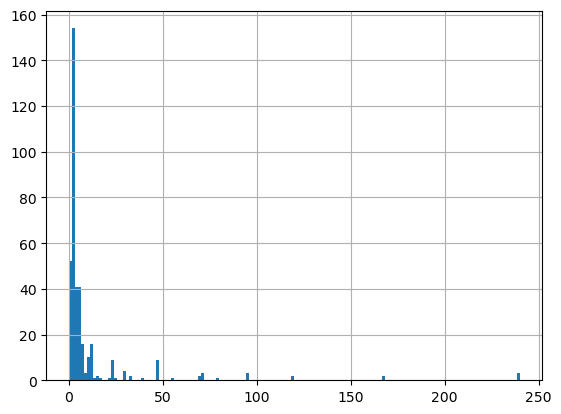

In [140]:
print(all_input.loc[all_input["inundation_duration_h"] < 48,:].shape[0], "cases with less than 2 days inundation")
print(all_input.loc[all_input["inundation_duration_h"] > 48,:].shape[0], "cases with more than 2 days inundation")
all_input["inundation_duration_h"].hist(bins=150, alpha=1.)


--> inundation duration has few cases of very long flood duration, the majority is by less than 24 hours

## Single datasets for each target variable
Select candiate predictors in respect to the response variables: Split dataset into two parts, one with candidate predictors for content losses and one dataset with candidate predictors for business reduction. This means non relevant candidate predictors fo the respective response are moved.

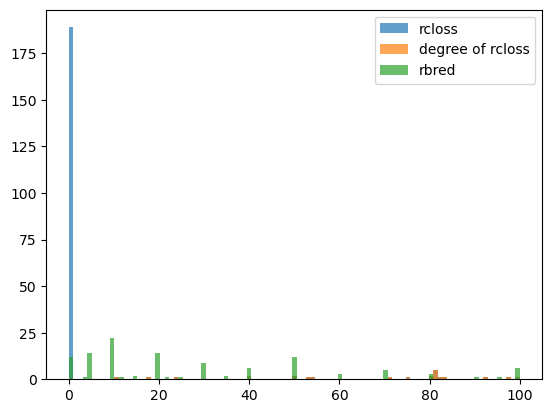

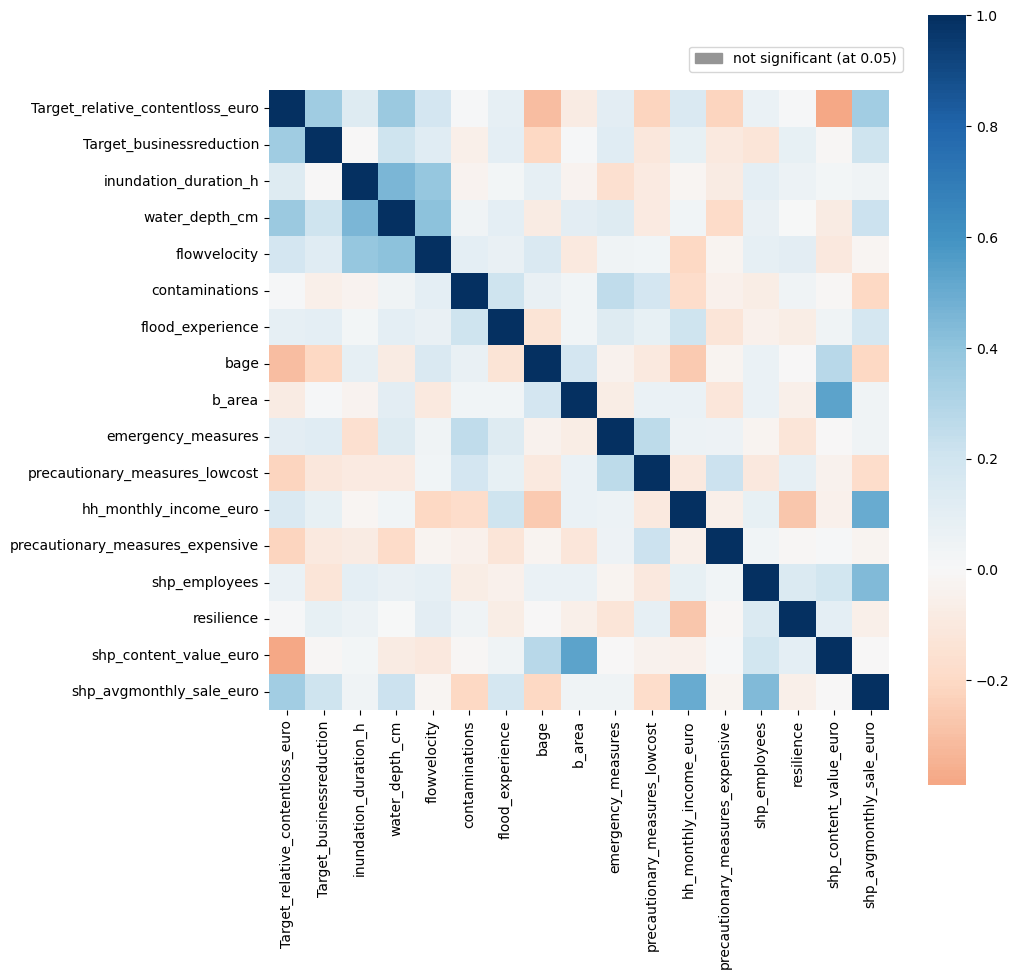

In [141]:
all_input_bred_rclossNoZeroloss = all_input.loc[all_input.Target_relative_contentloss_euro > 0.0, :]
all_input_bred_rclossNoZeroloss 


bins = np.linspace(0, 100, 100)

plt.hist(all_input.Target_relative_contentloss_euro*100, bins, alpha=0.7, label='rcloss')
plt.hist(all_input_bred_rclossNoZeroloss.Target_relative_contentloss_euro*100, bins, alpha=0.7, label='degree of rcloss')
plt.hist(all_input_bred_rclossNoZeroloss.Target_businessreduction, bins, alpha=0.7, label='rbred')
plt.legend(loc='upper right')
plt.show()

all_input.Target_relative_contentloss_euro.describe()

## --> only 25% of rcloss have losses higher than 2% of their inventory value




plt.figure(figsize=(10,10))
f.plot_spearman_rank(all_input_bred_rclossNoZeroloss.drop(
    ["overall_problem_house",  "geometry",
    "shp_sector",
    "shp_registered_capital_euro"], axis=1),
      min_periods=50, signif=False, psig=0.05)

## --> degree of loss (rcloss without zerolosses)  has stronger correlations than bred (incl zero cases) (NOTE shp_contentvalue is not used in rcloss ds)

**Drop second geom column**

In [142]:
all_input = all_input.select_dtypes(exclude=['geometry'])
all_input.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 0 to 396
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Target_relative_contentloss_euro  312 non-null    float64
 1   Target_businessreduction          356 non-null    float64
 2   inundation_duration_h             381 non-null    float64
 3   water_depth_cm                    390 non-null    float64
 4   flowvelocity                      391 non-null    float64
 5   contaminations                    391 non-null    int32  
 6   overall_problem_house             391 non-null    int32  
 7   flood_experience                  391 non-null    int64  
 8   bage                              364 non-null    float64
 9   b_area                            389 non-null    float64
 10  geometry                          391 non-null    object 
 11  shp_sector                        375 non-null    float64
 12  emergency_mea

In [143]:
all_input_contentloss = all_input
all_input_contentloss = all_input_contentloss.drop(
    [
    "Target_businessreduction",
    "shp_content_value_euro",
    "overall_problem_house",  # no logical impact on closs, but might impact bred
    "shp_sector",
    "shp_registered_capital_euro", # same - circular 
    "hh_monthly_income_euro"
    #"shp_suppliers",  # rm due that no reasnable link to contelt losses (<-> compare Business reduction)
    #"perception_who_responsible4protection*",
    #"floors", # used to derive shp_content_value and relative_content_loss
    ]
    , axis=1)
print(all_input_contentloss.shape)
all_input_contentloss.columns


(391, 15)


Index(['Target_relative_contentloss_euro', 'inundation_duration_h',
       'water_depth_cm', 'flowvelocity', 'contaminations', 'flood_experience',
       'bage', 'b_area', 'geometry', 'emergency_measures',
       'precautionary_measures_lowcost', 'precautionary_measures_expensive',
       'shp_employees', 'resilience', 'shp_avgmonthly_sale_euro'],
      dtype='object')

In [144]:
all_input_business_reduction = all_input
all_input_business_reduction = all_input_business_reduction.drop(
    [
    "Target_relative_contentloss_euro",
    "overall_problem_house",  #rm due that it is circular / captured by other variables
      "shp_registered_capital_euro", # same - circular
      "shp_sector",
      "hh_monthly_income_euro", "shp_content_value_euro",  # corr with monhtly_sale
   # "Target_contentloss_euro",
    #"shp_content_value_euro", ## content value can infleunce busines reduction eg. heavy and expensive machinery
      #  "floors", # used to derive shp_content_value and relative_content_loss
    # "buildingtype_moon"  # remove due to 64 % missing values
    # "perception_private_economy_future"
    # #"perception_who_responsible4protection*",
    # "resilience_govern_warnings_helpful",
    # "resilience_more_future_affected",
    # #"resilience_govern_careing"
    ],
    axis=1)
print(all_input_business_reduction.shape)
all_input_business_reduction.columns





(391, 15)


Index(['Target_businessreduction', 'inundation_duration_h', 'water_depth_cm',
       'flowvelocity', 'contaminations', 'flood_experience', 'bage', 'b_area',
       'geometry', 'emergency_measures', 'precautionary_measures_lowcost',
       'precautionary_measures_expensive', 'shp_employees', 'resilience',
       'shp_avgmonthly_sale_euro'],
      dtype='object')

## Coefficient of variation
access relative volatility between both targets and for predictors
Maybe it explians why some predcitors are seen as more important as others in feautre-extraction 

In [145]:
## coef. of variation
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 

#calculate CV for each column in data frame
print(all_input_contentloss.drop("geometry", axis=1).apply(cv).sort_values())



resilience                          40.9343
contaminations                      41.5289
flowvelocity                        42.1364
emergency_measures                  64.0950
shp_employees                       64.2532
flood_experience                    66.0810
bage                                70.6611
water_depth_cm                      75.2315
precautionary_measures_lowcost      81.1390
b_area                             100.0801
shp_avgmonthly_sale_euro           117.4241
precautionary_measures_expensive   124.3420
inundation_duration_h              254.9093
Target_relative_contentloss_euro   287.4810
dtype: float64


In [146]:
print(all_input_business_reduction.drop("geometry", axis=1).apply(cv).sort_values())


resilience                          40.9343
contaminations                      41.5289
flowvelocity                        42.1364
emergency_measures                  64.0950
shp_employees                       64.2532
flood_experience                    66.0810
bage                                70.6611
water_depth_cm                      75.2315
precautionary_measures_lowcost      81.1390
b_area                             100.0801
shp_avgmonthly_sale_euro           117.4241
precautionary_measures_expensive   124.3420
Target_businessreduction           136.8880
inundation_duration_h              254.9093
dtype: float64


## Tests of feature space modification

### Test one-hot-encoding for business sectors

In [147]:
# all_input_contentloss = pd.get_dummies(all_input_contentloss, columns=["shp_sector"]) # 3 sector types
# all_input_contentloss.tail(3)

OLD : no imporvement for Logreg, max rloss= 0.300: ## test remove - drop  21 cases with the highest absolute losses (all above >1000 € loss)

OLD : no imporvement for Logreg, max rloss= 0.200: ## test threshold - set extreme high absolute losses to a constant value, EN: no FI, wouldnt have any variation in prediction

In [148]:
# # all_input_contentloss.Target_contentloss_euro.hist(bins=100)
# all_input_contentloss["Target_contentloss_euro"] = all_input_contentloss["Target_contentloss_euro"].apply(pd.to_numeric)
# all_input_contentloss.Target_contentloss_euro.describe()

In [149]:
# # n = 10
# # t = sorted(all_input_contentloss.Target_contentloss_euro.to_list())[:len(all_input_contentloss.Target_contentloss_euro.to_list()) - n] 
# # np.nanmax(t)
# max_loss_threshold = 1000
# print(f"Number of records with content losses higher than {max_loss_threshold} € :", 
#       sum(all_input_contentloss.Target_contentloss_euro > max_loss_threshold) 
#     )
# ## only 161 records experienced damages on their business inventory (aka content)
# ## To simply ML-predictions (esp. chnace of loss and Elastic ENt on degre of loss) set all cases with higher than 2000€ damages to np.NaN
# all_input_contentloss.Target_contentloss_euro[all_input_contentloss.Target_contentloss_euro > max_loss_threshold] = np.nan 
# print(all_input_contentloss.Target_contentloss_euro.describe())
# all_input_contentloss.Target_contentloss_euro.hist(bins=100)

In [150]:
# # all_input_contentloss["Target_contentloss_euro"] = all_input_contentloss["Target_contentloss_euro"].apply(pd.to_numeric)
# #threshold = 0.000
# max_loss_threshold = 10000
# print(f"Number of records with content losses higher than {max_loss_threshold} € :", 
#       sum(all_input_contentloss.Target_contentloss_euro > max_loss_threshold) 
#     )
# max_loss_threshold = 2000
# print(f"Number of records with content losses higher than {max_loss_threshold} € :", 
#       sum(all_input_contentloss.Target_contentloss_euro > max_loss_threshold) 
#     )
# ## only 161 records experienced damages on their business inventory (aka content)
# # from these have 21 businesses damages higher than 1000 € (around 13% of all damage-cases are very high losses)
# ## To simply ML-predictions (esp. cchnace of loss) all cases with greater losses than xxx € are set to xxx €
# all_input_contentloss.Target_contentloss_euro[all_input_contentloss.Target_contentloss_euro > max_loss_threshold] = max_loss_threshold 
# all_input_contentloss.Target_contentloss_euro.hist(bins=100)

## Geolocations

In [151]:
# df["geometry"][1].is_
# " ".join([is_digit()])

In [152]:
# geo_df = gpd.GeoDataFrame(df,  
#             geometry=gpd.points_from_xy( 
#                     df["geometry"].str.split(",").str[1], # lon
#                     df["geometry"].str.split(",").str[0],  # lat
#             )
#         )

Geolocations from the survey of the two largest businesses was compared with their actual location done by an internet search. It could be seen that the geolocations mentioned in the survey at least for the two largest businesses ahave potentially a high uncertainty range which is at least for the two examined businesses more than 200 m (beeline). The usage of spatial variables would be highly imprecise. Furthermore deriving the content value from building height is similar imprecise.


### Quality assessment: check OSM building information
Check if enough commercial/business-related building information exist in OSM to use it for extrapolation of content loss 
test for certain streets / small AIO with many shophouses exists from Tübing ds
- verify OSM information with geolocation of shophouses from Tübing ds 
- if enough valid information exists get OSM information from 2020
- if enough valid information adapt attributes by shop sectors from HCMC dataset
- if enough valid information get boundaries of AOI  :-)


In [153]:
# # import requests
# # URL = 'https://api.ohsome.org/v1/elements/count'
# # data = {"bboxes": "106.593238,10.6971085,106.7740687,10.8401006",  "format": "json", 
# #         "time": "2023-09-01", 
# #         # buildings total end 2023 : ~ 64 800 
# #         #"filter": "building=* and builing!=no and shop=*"}  # ~153 results 
# #         # "filter": "shop=* or building=commercial or building=industrial or building=kiosk or building=retail or amenity=bar or amenity=cafe or amenity=fast_food or amenity=restaurant or landuse=retail or landuse=commercial"} # 6424 reuslts
# #         # "filter": "shop=* or building=commercial or building=industrial or building=kiosk or building=retail or amenity=bar or amenity=cafe or amenity=fast_food or amenity=restaurant"} # 6288.0 reuslts
# #         "filter": "building=commercial or building=kiosk or building=retail or amenity=bar or amenity=cafe or  amenity=fast_food or amenity=restaurant"} # 2925.0 reuslts
# # # and type:way"}
# # response = requests.post(URL, data=data)
# # print(response.json())

# # import requests
# # #from ohsome import OhsomeClient
# # URL = 'https://api.ohsome.org/v1/elements/count'
# # data = {"bboxes": "106.593238,10.6971085,106.7740687,10.8401006", "format": "json", "filter": "building=* and builing!=no and building:levels=* or level=* or building:level=* or stories=* or levels=* or building:part:levels=*"}
# # response = requests.post(URL, data=data)
# # print(response.json())
# # ## --> building tagged in HCMC 64495.0, from those have around 2746 information about stories --> ~ <5% stories information

# import requests
# URL = 'https://api.ohsome.org/v1/elements/geometry'
# #URL = 'https://api.ohsome.org/v1/elements/length/ratio'
#         #"filter": "highway=living_street and type:way", "filter2": "highway=living_street and oneway=yes and type:way"}
# data = {"bboxes": "106.593238,10.6971085,106.7740687,10.8401006", "properties": "tags,metadata",
#         "time": "2023-09-01", 
#         "filter": "building=commercial or building=kiosk or building=retail or amenity=bar or amenity=cafe or  amenity=fast_food or amenity=restaurant"} 
#         # TODO include shop: (florist, supermarket, clothes, bag, houseware, books, seafood, beauty, mobile_phone, military_surplus, 
#         # wedding, convenience, yes, electronics , tailor, jewelry, funeral_directors ...) # = yes e.g. Spectacles shop, Clothing
# response = requests.post(URL, data=data)
# print(response.json())


In [154]:
# t = response.json()


In [155]:
# import os, sys
# import json
# import pandas as pd
# import geopandas as gpd
# from ohsome import OhsomeClient
# import requests

# sys.path.append('../../')
# # sys.path.append( os.getcwd()+ '/..')
# from modules.download import download_features, build_ohsome_filters
# from modules.utils import load_config, init_logger



In [156]:
# config_layers = "../modules/config_tags_hcmc.json"
# config_tags = load_config(config_layers)

# client = OhsomeClient()
# timestamp=None
# out_dir = "."
# output_dir = "../modules"
# aoi = "106.503238,10.6071085,106.7740687,10.8401006" #t.to_frame(name="geometry")

# # for layer in config_tags["get_all_info"]:
# # for layer in config_tags["get_commerce_info"]:
# for layer in config_tags["get_residential_info"]:
# # for layer in config_tags["get_buildingheight_info"]:
#     ohsome_filter_str = build_ohsome_filters(layer)
#     print(ohsome_filter_str)
#     response = client.elements.geometry.post(
#         bboxes=aoi,
#         # bboxes="106.593238,10.6971085,106.7740687,10.8401006",
#         #bpolys=aoi, 
#         time=timestamp, filter=ohsome_filter_str, properties="metadata,tags"
#     )
#     response.to_json(os.path.join(output_dir, f"{layer['name']}.geojson"))  
#     # output_dir = os.path.join(out_dir, "test")
# os.makedirs(output_dir, exist_ok=True)

### Get spatial distirbution of certain variables
E.g. examine spatial variation of reported flowvelocity, water depth, business size, floor number etc.

In [157]:
# # raw_data["geometry"].str.findall(r'(\d+\.\d+)')

# df_geom = all_input

# df_geom["geometry"] = raw_data["geometry"].str.findall(r'(\d+\.\d+)').astype(str)
# geom_col = df_geom["geometry"].str.split(' ', n=1, expand=True)
# geom_col

# df_geom.geometry
# df_geom = gpd.GeoDataFrame(df_geom,  
#            geometry=gpd.points_from_xy(
#                geom_col[0].str.extract(r'(\d+\.\d+)')[0],
#                geom_col[1].str.extract(r'(\d+\.\d+)')[0],
#     ))
# df_geom = df_geom.set_crs(4326) 

# df_geom.tail(2)


In [158]:
## check bage
all_input_contentloss[all_input_contentloss.bage >50]

,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,geometry,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,shp_employees,resilience,shp_avgmonthly_sale_euro
9,0.0000,13.0000,20.0000,0.4000,0,36,51.0000,74.0000,POINT EMPTY,0.6667,0.0000,0.3333,2,3.3333,92.1000
59,NaN,12.0000,20.0000,0.2000,1,36,60.0000,760.0000,POINT EMPTY,0.1667,1.0000,0.3333,6,2.0000,276.2000
136,0.8125,2.0000,20.0000,0.3000,1,151,51.0000,50.0000,POINT EMPTY,0.0000,0.0000,0.0000,1,1.6667,92.1000
141,3.2717,10.0000,40.0000,0.5000,1,8,62.0000,36.0000,POINT (106.63034012725717 10.72345104271757),0.3333,0.0000,0.0000,1,4.3333,92.1000
146,0.0000,2.0000,30.0000,0.2000,1,151,100.0000,180.0000,POINT EMPTY,0.5000,0.2500,0.3333,3,2.6667,92.1000
158,0.0000,48.0000,20.0000,0.2000,1,16,66.0000,112.0000,POINT (106.62933567902368 10.721473270407003),0.0000,0.5000,0.0000,6,5.0000,276.2000
184,4.0005,3.0000,10.0000,0.3000,1,151,57.0000,56.0000,POINT (106.62913892001916 10.724036573713102),0.6667,0.2500,0.0000,1,2.0000,92.1000
288,NaN,12.0000,80.0000,0.3000,1,36,59.0000,760.0000,POINT EMPTY,0.0000,1.0000,0.3333,6,2.0000,276.2000
345,3.2717,10.0000,40.0000,0.5000,1,8,62.0000,36.0000,POINT (106.63034012725717 10.72345104271757),0.0000,0.0000,0.0000,1,4.3333,92.1000
349,0.0000,10.0000,60.0000,0.2000,1,151,100.0000,180.0000,POINT EMPTY,0.5000,0.2500,0.3333,3,2.6667,92.1000


<Axes: >

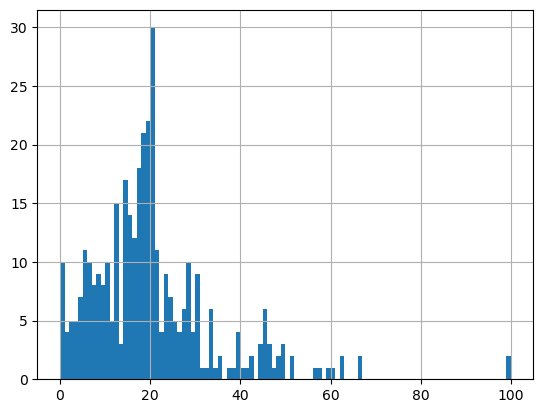

In [159]:
# all_input_contentloss.bage.hist(bins=100)
all_input_business_reduction.bage.hist(bins=100)

In [160]:
# # glimpse =  df[~ df.is_empty] 
# # #glimpse = glimpse[glimpse.flowvelocity]
# # glimpse.geometry.explore() 


# ## preparation for folium plot
# ## drop timestamp columns due not usable in folium plot
# df = df_geom[["flood_experience", "inundation_duration_h", "water_depth_cm", "flowvelocity", "shp_content_value_mVND", 
#          "Target_contentloss_mVND", "Target_businessreduction", "bage",
#          "geometry"
#          ]]
# ## imporve plot visualization
# # df = df.loc[df.Target_contentloss_mVND < 10, :]
# df = df.loc[df.Target_contentloss_mVND < 500, :]
# df = df.loc[df.inundation_duration_h < 500, :]

# print(df.shape)

# ## visual check of SMEs locations
# import folium

# glimpse = df[~ df.is_empty]   # drop emtpy geoms
# glimpse_geolocations = df[~ df.is_empty]   # drop emtpy geoms
# m = glimpse.geometry.explore(name="survey ds", color="red", k=10)  
# m = glimpse_geolocations.explode(ignore_index=True).explore(
#     m=m, 
#     column="Target_businessreduction",
#     # column="flood_experience",
#     #name="flowvelocity",
#     #column="flowvelocity", 
#     popup=True, 
#     #tooltip="Nr_Floors", 
#     cmap="viridis",
#     #cmap="Reds"
# )    # BT_Moon BT_TUEB_2

# folium.LayerControl().add_to(m)
# m

# ############### spatial distirbutions explored   ##################
# ## 0.1 = calm velocity, 0.5 = turbulent velocity
# ## no spatial relationship between veloctiy strength and distance to canal or waterway visible 
# ## --> seems like flow velocity is infleunced by further flood sources like overwhelmed drainage systems

# ## abs loss
# #     column="Target_contentloss_mVND",
# ## only slight spatial agglomeration of damage-case

# ### CV
# # ## only slight spatial agglomeration
 
#  ## water depth
#  ## cluster(s) of higher wd might exists e.g. South-east next to highway

# ## inundation duration
# ## clusters of longer (multiple clusters) and shorter (one cluster) inundation durations exist

# ## flood experience
# ## cluster at least in south-east and one in the center exists, rest is quite mixed

# ## bage

**employeees by sector**

In [161]:
# ## TODO are employess or b_area and sector correlated with cv 

# from sklearn import linear_model

# X = all_input[["shp_sector", "shp_employees"]]  # "b_area"
# y = all_input["shp_content_value_euro"]
# regr = linear_model.LinearRegression()
# regr.fit(X, y)

In [162]:
# from collections import Counter

print(all_input.shp_sector.value_counts())
# tt = list(all_input.groupby('shp_sector')['shp_employees'].apply(list))

# # print(Counter(tt[0]))  # count shps grouped by employee number in sector 1
# # print(Counter(tt[1]))  # count shps grouped by employee number in sector 2
# # print(Counter(tt[2]))  # count shps grouped by employee number in sector 3

# print(pd.Series(tt[0]).describe())
# print(pd.Series(tt[1]).describe())
# print(pd.Series(tt[2]).describe())

# # ## --> all sectors have usually 1 or 2 employees
# all_input.shp_sector

shp_sector
1.0000    289
2.0000     63
3.0000     23
Name: count, dtype: int64


In [163]:
# ## does cv correlates with setor type ?

# print(all_input.shp_sector.value_counts())
# tt = list(all_input.groupby('shp_sector')['shp_content_value_euro'].apply(list))

# # print(Counter(tt[0]))  # count shps grouped by employee number in sector 1
# # print(Counter(tt[1]))  # count shps grouped by employee number in sector 2
# # print(Counter(tt[2]))  # count shps grouped by employee number in sector 3

# print(pd.Series(tt[0]).describe())
# print(pd.Series(tt[1]).describe())
# print(pd.Series(tt[2]).describe())

# ## --> secotr 3 haas usaully the most expensive content value (<- it is production sector)


In [164]:
## common sectors, occures at least 10 times

# sectors_2_test = [11.0, 17.0, 22.0, 24.0, 21.0, 31]
# tt = all_input_incl_geometry.loc[all_input_incl_geometry.shp_sector.isin(sectors_2_test),:]
# tt.shape

In [165]:
# fig = plt.figure(figsize=(6, 6))
# # plt.scatter( 
# #     all_input["shp_employees"], 
# #     all_input["shp_content_value_euro"],
# #     linewidths=1, alpha=.7,
# #     edgecolor='k',
# #     s = 200,
# #     c="shp_sector")
# # sns.stripplot(
# sns.catplot(
#     data=tt, x="b_area", y="shp_content_value_mVND", alpha=.5,
#     #data=tt, x="shp_employees", y="shp_content_value_mVND", alpha=.5,
#    # data=all_input, x="shp_employees", y="shp_content_value_euro", alpha=.5,
#     #hue='shp_sector',palette="viridis",
#     col="shp_sector", aspect=.5
#     )
# # sns.regplot(data=all_input, x="b_area", y="shp_content_value_euro", 
# #             scatter=False, color="black",
# #             )

# plt.show()


### Test Spatial Autocorrelation

In [166]:
# import libpysal as lps
# import pysal as ps
# import esda

In [167]:
# df_geom = all_input_incl_geometry

# df_geom["geometry"] = raw_data["geometry"].str.findall(r'(\d+\.\d+)').astype(str)
# geom_col = df_geom["geometry"].str.split(' ', n=1, expand=True)
# geom_col

# df_geom.geometry
# df_geom = gpd.GeoDataFrame(df_geom,  
#            geometry=gpd.points_from_xy(
#                geom_col[0].str.extract(r'(\d+\.\d+)')[0],
#                geom_col[1].str.extract(r'(\d+\.\d+)')[0],
#     ))
# df_geom = df_geom.set_crs(4326) 

# # dff = df_geom
# # dff = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df["geometry"]))

# # target = "Target_businessreduction"
# # target = "rcloss" #
# target = "Target_contentloss_mVND"
# #target = "shp_content_value_mVND"

In [168]:
# ## use survey data points for weights creation - using KNN or DistanceBand neighborhodd definition

# dff = df_geom
# dff[target] = dff[target].apply(pd.to_numeric)
# # dff[["shp_content_value_mVND", "Target_contentloss_mVND"]] = dff[["shp_content_value_mVND", "Target_contentloss_mVND"]].apply(pd.to_numeric)
# # dff["rcloss"] = dff.shp_content_value_mVND / dff.Target_contentloss_mVND
# dff = dff[dff[target].notna()]
# # dff = dff.loc[dff[target] <=1.00, :]
# dff = dff.loc[dff[target] >0.00, :]
# #dff[target].fillna((dff[target].median()), inplace=True)
# dff =  dff[~ dff.is_empty] # NOTE: mandatory for spatial analysis drop missing geolocations
# print(dff[target].describe())

# # wq =  lps.weights.DistanceBand.from_dataframe(dff, threshold=0.6, geom_col="geometry")  # def -1.0
# # wq =  lps.weights.DistanceBand.from_dataframe(dff, threshold=0.06, alpha=-1.0, binary=False)  # def -1.0
# # wq =  lps.weights.Queen.from_dataframe(dff)
# # wq =  lps.weights.DistanceBand.from_dataframe(dff, threshold=01.2,binary=False)  
# # wq =  lps.weights.Queen.from_dataframe(dff)
# wq =  lps.weights.DistanceBand.from_dataframe(dff, threshold=0.6, binary=False)  #  inverse distance weighting

# # wq.transform = 'r'  # continous case , "b" binary case

# ## use voronoi polygons for weights creation - using Queens neighborhodd defnition
# # wq = lps.weights.contiguity.Queen.from_dataframe(df_geom)
# #.lib.weights.Queen.from_dataframe(df)

# wq.transform = 'r'

# print(f"Median of {target}", dff[target].median())# Target_businessreduction

# ## Moran’s I is a test for global autocorrelation for a continuous attribute:
# #np.random.seed(12345)
# mi = esda.moran.Moran(dff[target], wq)

# sns.kdeplot(mi.sim, shade=True)
# plt.vlines(mi.I, 0, 5, color='r')
# plt.vlines(mi.EI, 0,5)
# plt.xlabel("Moran's I")

# print("Moran's I", mi.I)  # = red == observed value

# print("p-value:", mi.p_sim)  # significant <=0.05
# print("z-score :")  #  statement with a given level of confidence about whether or not we reject or accept the null hypothesis.

### Test Local Morans I

In [169]:
## TODO local morans I -significant? 
    ## TODO LES M+Pebsma spatial CV also for Interpolation? -> use HCMC
    ##  test BN transferbaility with spatial CV if spatial cluster exist

# DONE find if bv for OBM exists -> rcloss derived by floor + rbloss from addiontional data from hazard maps and OBM
    ## (paprtony 2020 derive bv from other data)
# DONE BN rloss for CanTho
## DONE write results for BN rcloss
## DONE test to /read how to derive sale volume -> probly not due that no pattern between sector type and b area could be found
    ## maybe sector type * employees = sale volume, not enough data for special case of microbusinesses
## DONE test to derive bage from OBM data (bui type, floors)
## DONE test to  flood_experience derive by return period from inundation maps
## TODO how to make Binned scatterplots of modelled and observed


12-21-2023 02:45:02 - __figures__ - INFO - imputing columns with median


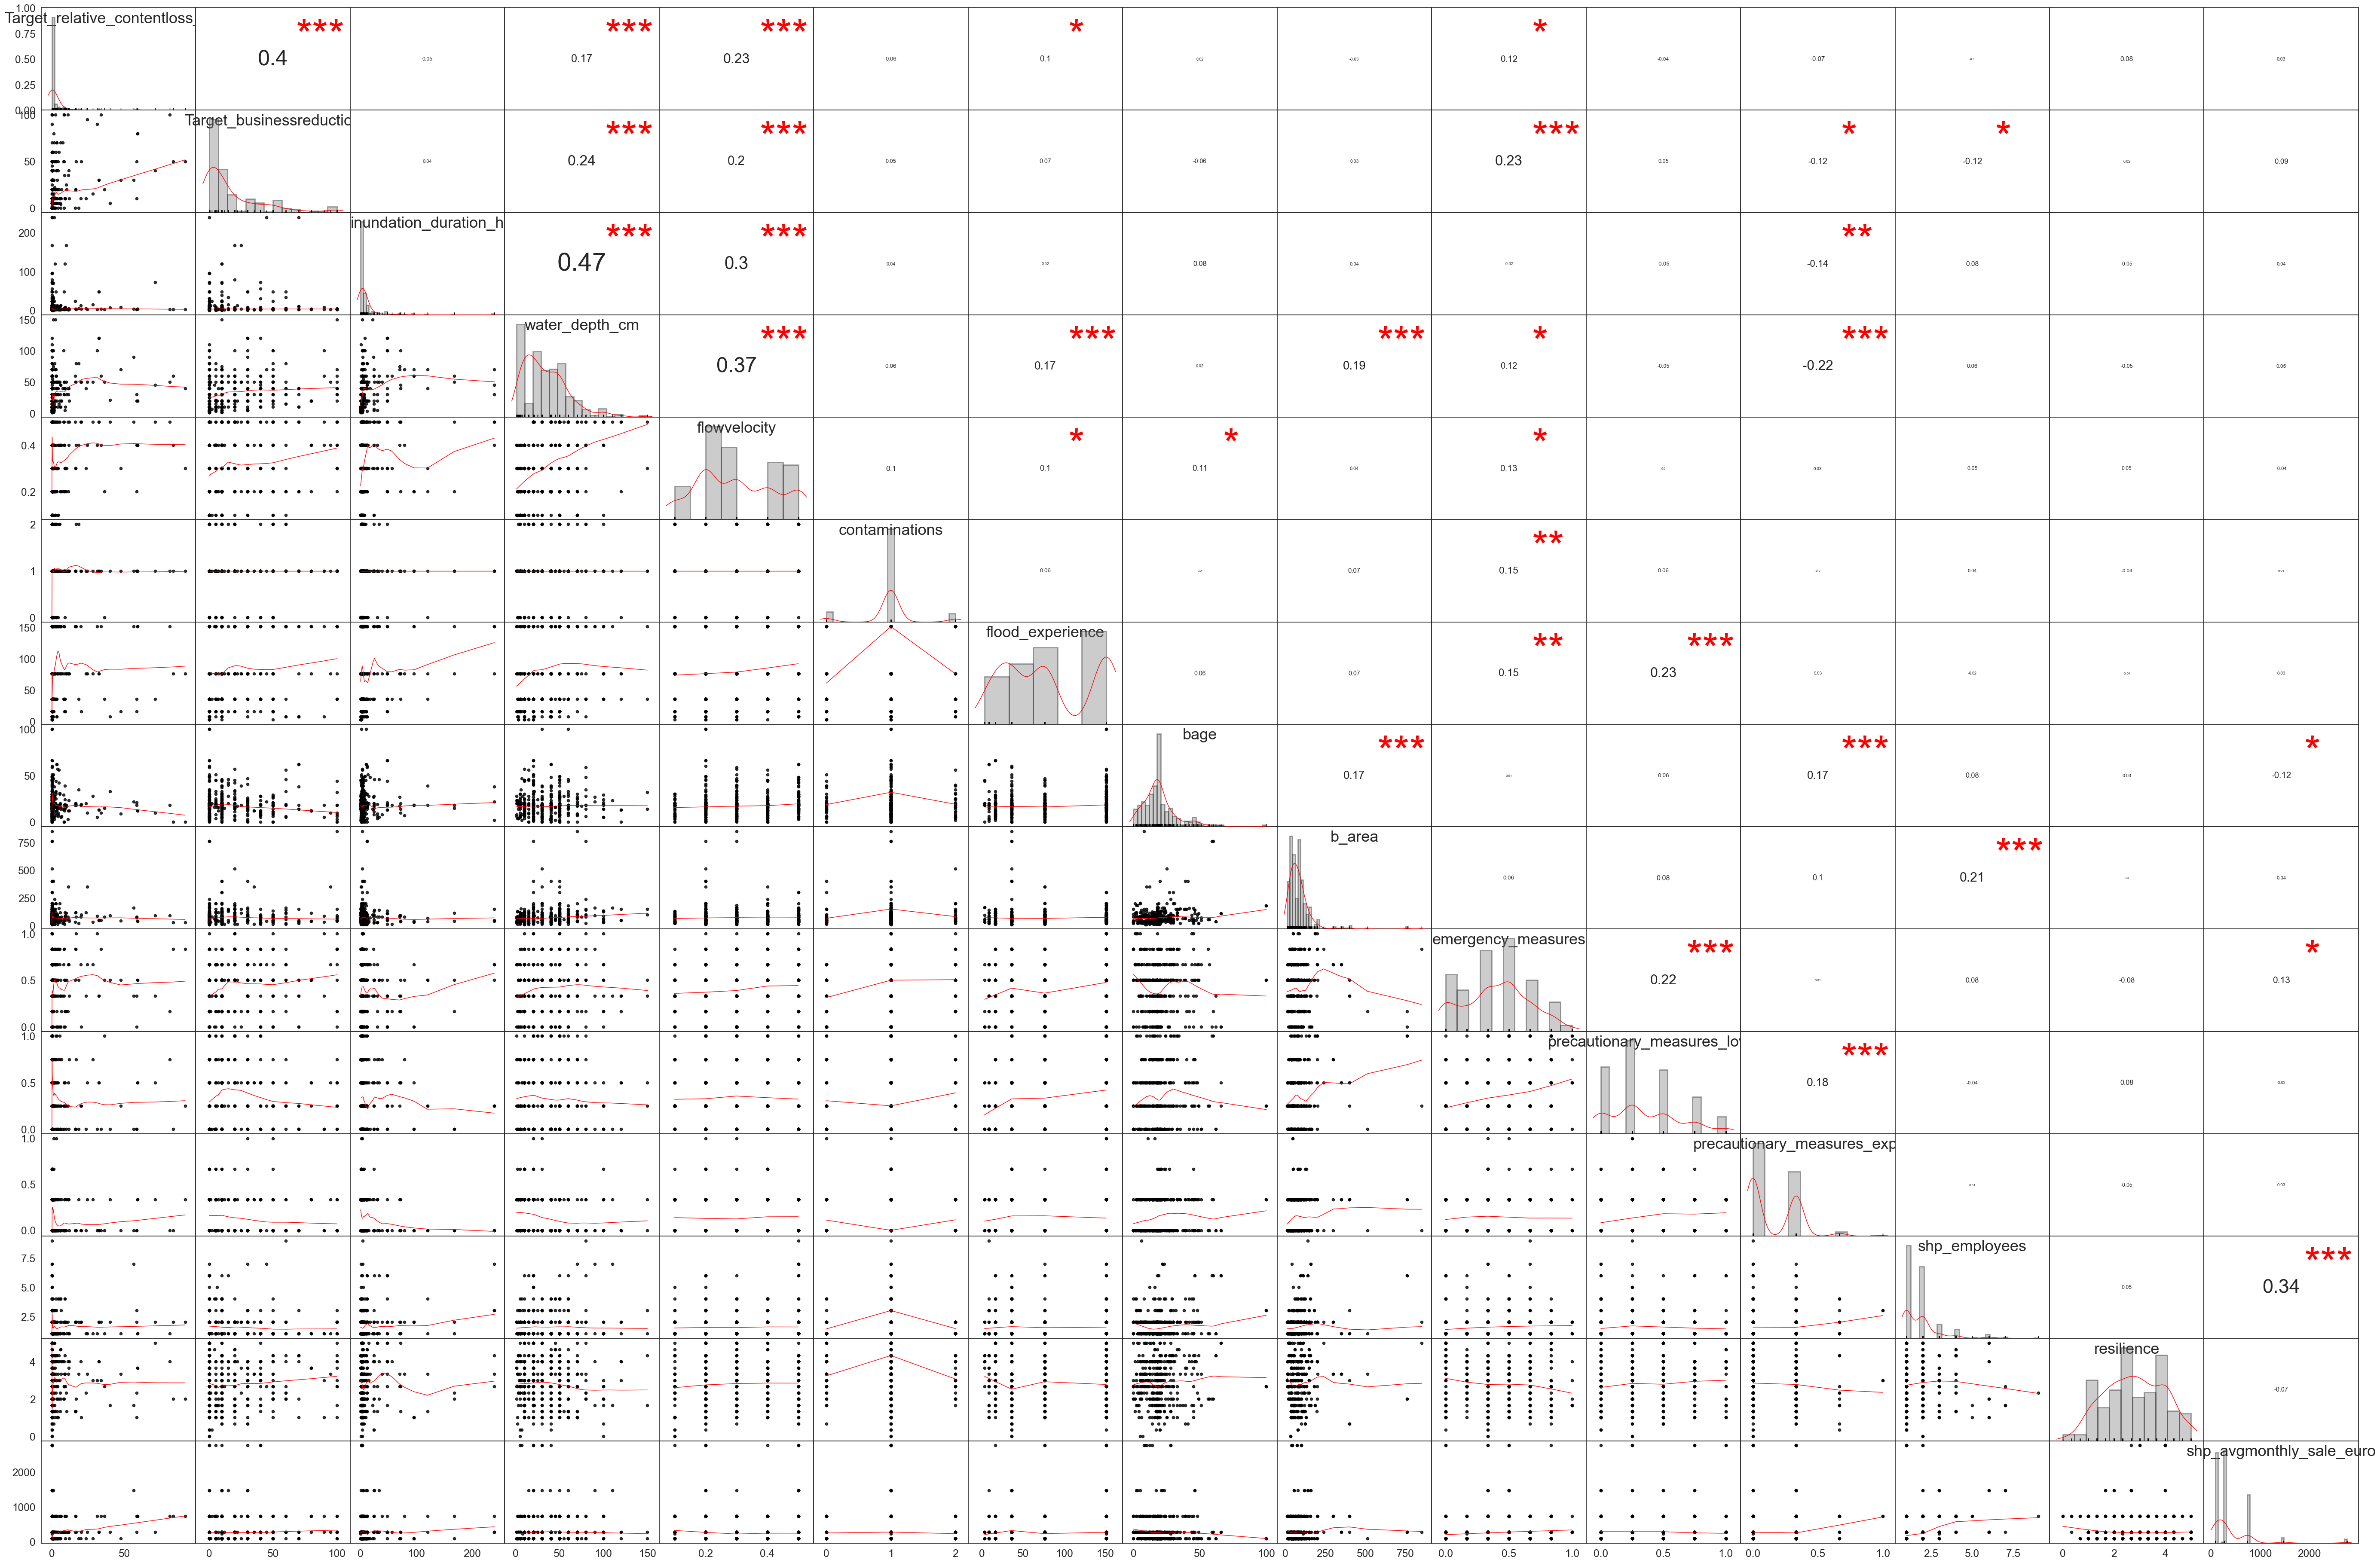

In [175]:
f.plot_correlations(
    all_input.drop(
        ["overall_problem_house", "geometry", "shp_sector" , 
            "hh_monthly_income_euro", "shp_content_value_euro",	"shp_registered_capital_euro"],
            axis=1), 
     impute_na=True
)


## write to disk

In [195]:
all_input_contentloss.loc[all_input_contentloss["Target_relative_contentloss_euro"]>0.00,:]

,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,geometry,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,shp_employees,resilience,shp_avgmonthly_sale_euro
7,0.9208,12.0000,20.0000,0.2000,1,36,21.0000,54.0000,POINT (106.69964412418429 10.79696322884849),0.3333,0.2500,0.3333,2,2.0000,1473.0000
10,0.8059,2.0000,3.0000,0.4000,0,36,22.0000,45.0000,POINT (106.70194598945477 10.797394749195204),0.1667,0.2500,0.3333,2,3.3333,92.1000
11,0.3997,0.5000,10.0000,0.2000,1,3,45.0000,35.0000,POINT (106.69935217514268 10.79660847715228),0.1667,0.0000,0.3333,1,3.6667,92.1000
13,0.7994,7.0000,50.0000,0.2000,1,36,20.0000,400.0000,POINT (106.70615977398815 10.801294645010454),0.5000,0.2500,0.3333,3,3.0000,276.2000
20,39.9989,7.0000,21.0000,0.5000,1,8,33.0000,90.0000,POINT (106.70637435791241 10.800778773518177),0.5000,0.0000,0.3333,2,1.6667,276.2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,16.2785,4.0000,50.0000,0.3000,1,151,20.0000,120.0000,POINT EMPTY,0.8333,0.0000,0.0000,2,1.3333,736.5000
373,83.3446,3.0000,60.0000,0.4000,1,76,0.0000,28.0000,POINT EMPTY,0.8333,0.0000,0.0000,2,2.0000,736.5000
376,4.1547,3.0000,30.0000,0.1000,1,151,18.0000,50.0000,POINT EMPTY,0.3333,0.2500,0.0000,1,1.0000,276.2000
377,3.1192,3.0000,30.0000,0.3000,0,151,11.0000,48.0000,POINT EMPTY,0.5000,0.2500,1.0000,3,3.0000,736.5000


In [176]:

## drop cases with missing loss information 
print(f"Dropping {all_input_contentloss.Target_relative_contentloss_euro.isna().sum()}")
all_input_contentloss = all_input_contentloss[ ~all_input_contentloss["Target_relative_contentloss_euro"].isna()]
print(all_input_contentloss.shape)

## drop cases with missing reduction information 
print(f"Dropping {all_input_business_reduction.Target_businessreduction.isna().sum()}")
all_input_business_reduction = all_input_business_reduction[ ~all_input_business_reduction["Target_businessreduction"].isna()]
print(all_input_business_reduction.shape)

# all_input_contentloss = all_input_contentloss.drop("shp_registered_capital_euro", axis=1) # high collinearity with other soio-economic variables
# all_input_business_reduction = all_input_business_reduction.drop("shp_registered_capital_euro", axis=1) # 

# ## maybe rm hh_income due high corr, and partly included in monhtly_sale
# all_input_contentloss = all_input_contentloss.drop("hh_monthly_income", axis=1)
# all_input_business_reduction = all_input_business_reduction.drop("hh_monthly_income", axis=1)


Dropping 79
(312, 15)
Dropping 35
(356, 15)


In [177]:
all_input_contentloss
all_input_business_reduction # TODO rm or dont create 2. geom column

,Target_businessreduction,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,geometry,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,shp_employees,resilience,shp_avgmonthly_sale_euro
0,0.0000,2.0000,10.0000,0.2000,0,76,12.0000,25.0000,POINT EMPTY,0.0000,0.0000,0.0000,1,5.0000,276.2000
1,0.0000,2.0000,15.0000,0.2000,1,76,0.0000,21.0000,POINT (106.6990667908692 10.796493095049405),0.0000,0.0000,0.0000,1,5.0000,276.2000
2,0.0000,1.0000,2.0000,0.2000,0,76,21.0000,50.0000,POINT (106.70080527790017 10.797540370705613),0.0000,0.7500,0.3333,1,4.0000,92.1000
4,0.0000,3.0000,5.0000,0.3000,1,16,20.0000,80.0000,POINT (106.70003992972188 10.797443653167456),0.0000,0.2500,0.3333,1,5.0000,92.1000
5,0.0000,0.5000,3.0000,0.2000,0,3,20.0000,55.0000,POINT (106.70032889653847 10.797492905822615),0.0000,0.5000,0.3333,1,4.3333,276.2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,30.0000,2.0000,40.0000,0.3000,1,76,15.0000,80.0000,POINT EMPTY,0.6667,0.7500,0.0000,1,4.0000,92.1000
392,30.0000,5.0000,40.0000,0.2000,1,151,1.0000,80.0000,POINT (106.69150683690447 10.66047886618251),0.6667,0.5000,0.0000,2,2.0000,276.2000
393,10.0000,4.0000,60.0000,0.3000,1,151,30.0000,60.0000,POINT EMPTY,0.8333,0.7500,0.0000,2,1.0000,736.5000
394,10.0000,5.0000,70.0000,0.1000,1,151,25.0000,80.0000,POINT EMPTY,0.5000,0.7500,0.0000,1,1.0000,276.2000


In [178]:
## move targets to beginning
all_input_contentloss.insert(0, "Target_relative_contentloss_euro", all_input_contentloss.pop("Target_relative_contentloss_euro"))
all_input_business_reduction.insert(0, "Target_businessreduction", all_input_business_reduction.pop("Target_businessreduction"))


## Compare rlosses of older buildings with newer buidlings
Theory that older buildings have less losses due that they are located in historical areas of the city
--> problem only 10 buildins are older than 50 year accoridng to interviewee reports

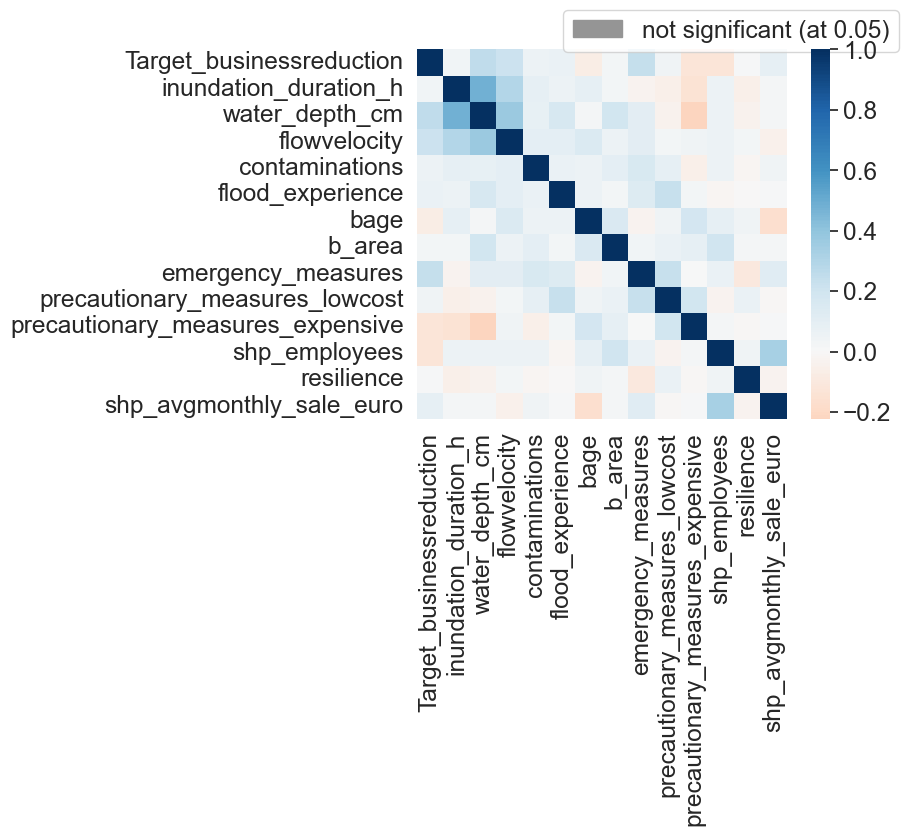

In [179]:
# all_input_contentloss[ (all_input_contentloss.bage<50) & (all_input_contentloss.bage > 20)].Target_relative_contentloss_euro.describe()
# # 75%       0.0316 # buis odler than 50 years (10 cases)
# all_input_contentloss.bage.hist(bins=100)

f.plot_spearman_rank(all_input_business_reduction.drop("geometry", axis=1), signif=0.00)

In [180]:
all_input_contentloss.columns #  = all_input_contentloss.drop("Target_contentloss_euro", axis=1)
# # all_input_contentloss = all_input_contentloss.drop(['flood_type.1', 'flood_type.2','flood_type.3'], axis=1)

# all_input_business_reduction = all_input_business_reduction.drop("Target_relative_contentloss_euro", axis=1)
# #all_input_business_reduction = all_input_business_reduction.drop(['shp_sector' ,'flood_type.1', 'flood_type.2','flood_type.3'], axis=1)


Index(['Target_relative_contentloss_euro', 'inundation_duration_h',
       'water_depth_cm', 'flowvelocity', 'contaminations', 'flood_experience',
       'bage', 'b_area', 'geometry', 'emergency_measures',
       'precautionary_measures_lowcost', 'precautionary_measures_expensive',
       'shp_employees', 'resilience', 'shp_avgmonthly_sale_euro'],
      dtype='object')

In [181]:
all_input_business_reduction.columns
#all_input_business_reduction.precautionary_measures.value_counts()

Index(['Target_businessreduction', 'inundation_duration_h', 'water_depth_cm',
       'flowvelocity', 'contaminations', 'flood_experience', 'bage', 'b_area',
       'geometry', 'emergency_measures', 'precautionary_measures_lowcost',
       'precautionary_measures_expensive', 'shp_employees', 'resilience',
       'shp_avgmonthly_sale_euro'],
      dtype='object')

In [182]:
# # check freq of pluvial/fluvial and riverine flood types
# all_input["hh_monthly_income"].describe()  # recent

# ## records total : 393
# # 1 : tidal 306 records 
# # 2 : pluvial 286 records --> prolonged or high-intensity can led to overwhelmed drainage systems / waterways (Leitpold 2021)
# # 3 : riverine 38 records 

# ## many compound floodings are reported - in line with Leitpold 2021 for manufactoring firms (two or more flood sources simultainously or in subsequently in short time)

In [183]:
## save to disk
all_input_contentloss.to_excel("../input_survey_data/input_data_contentloss_tueb.xlsx", index=False)
all_input_business_reduction.to_excel("../input_survey_data/input_data_businessreduction_tueb.xlsx", index=False)

In [184]:
print("Relative content loss dataset")
print("Number of candidate predictors ", all_input_contentloss.shape[1])
print("Number of cases ", all_input_contentloss.shape[0])

print("\nBusiness reduction dataset")
print("Number of candidate predictors ", all_input_business_reduction.shape[1])
print("Number of cases ", all_input_business_reduction.shape[0])

Relative content loss dataset
Number of candidate predictors  15
Number of cases  312

Business reduction dataset
Number of candidate predictors  15
Number of cases  356


In [185]:
all_input_contentloss.columns

Index(['Target_relative_contentloss_euro', 'inundation_duration_h',
       'water_depth_cm', 'flowvelocity', 'contaminations', 'flood_experience',
       'bage', 'b_area', 'geometry', 'emergency_measures',
       'precautionary_measures_lowcost', 'precautionary_measures_expensive',
       'shp_employees', 'resilience', 'shp_avgmonthly_sale_euro'],
      dtype='object')

<Axes: >

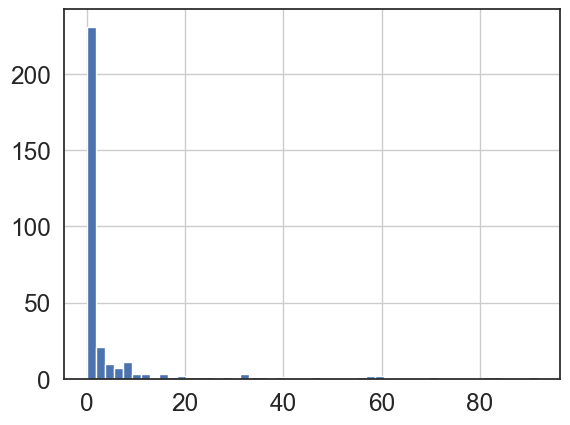

In [186]:
all_input_contentloss.Target_relative_contentloss_euro.hist(bins=50)

In [187]:
## export distribution statistics 

tbl = all_input.describe().T
tbl.to_excel("../input_survey_data/input_data_business_distrib_tueb.xlsx", index=True)
tbl

,count,mean,std,min,25%,50%,75%,max
Target_relative_contentloss_euro,312.0000,4.5455,13.0675,0.0000,0.0000,0.0000,2.1792,91.6723
Target_businessreduction,356.0000,18.1067,24.7860,0.0000,0.0000,10.0000,30.0000,100.0000
inundation_duration_h,381.0000,11.2840,28.7639,0.2000,2.0000,3.0000,6.0000,240.0000
water_depth_cm,390.0000,34.2154,25.7407,1.0000,15.0000,30.0000,50.0000,150.0000
flowvelocity,391.0000,0.3023,0.1274,0.1000,0.2000,0.3000,0.4000,0.5000
contaminations,391.0000,0.9821,0.4079,0.0000,1.0000,1.0000,1.0000,2.0000
overall_problem_house,391.0000,3.0716,1.8327,0.0000,2.0000,3.0000,5.0000,6.0000
flood_experience,391.0000,81.5499,53.8889,3.0000,36.0000,76.0000,151.0000,151.0000
bage,364.0000,19.8352,14.0157,0.0000,11.0000,18.0000,24.0000,100.0000
b_area,389.0000,86.9704,87.0401,12.0000,42.0000,74.0000,100.0000,850.0000


In [188]:
all_input_contentloss.describe()

,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,shp_employees,resilience,shp_avgmonthly_sale_euro
count,312.0000,307.0000,312.0000,312.0000,312.0000,312.0000,301.0000,310.0000,312.0000,312.0000,312.0000,312.0000,312.0000,312.0000
mean,4.5455,10.1651,32.6346,0.3093,0.9744,84.3782,20.1096,77.0468,0.4177,0.3694,0.1592,1.7917,2.8665,357.9429
std,13.0675,27.1721,25.1041,0.1263,0.4081,53.5840,14.0520,51.6844,0.2653,0.2980,0.1945,1.1017,1.1049,457.2190
min,0.0000,0.2000,1.0000,0.1000,0.0000,3.0000,0.0000,12.0000,0.0000,0.0000,0.0000,1.0000,0.3333,92.1000
25%,0.0000,2.0000,10.0000,0.2000,1.0000,36.0000,12.0000,42.2500,0.1667,0.2500,0.0000,1.0000,2.0000,92.1000
50%,0.0000,3.0000,30.0000,0.3000,1.0000,76.0000,18.0000,69.0000,0.5000,0.2500,0.0000,2.0000,2.8333,276.2000
75%,2.1792,6.0000,50.0000,0.4000,1.0000,151.0000,24.0000,100.0000,0.6667,0.5000,0.3333,2.0000,4.0000,276.2000
max,91.6723,240.0000,150.0000,0.5000,2.0000,151.0000,100.0000,400.0000,1.0000,1.0000,1.0000,7.0000,5.0000,2761.9000
